In [595]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

import time

In [596]:
df = pd.read_csv("AAPL.csv")
df['Date'] = df['Date'].to_numpy()
df = df.set_index(pd.DatetimeIndex(df['Date']))
df["adj close"] = df.Close
df.drop(['Close'], 1, inplace=True)
df.drop(['Date'], 1, inplace=True)
df.drop(['Adj Close'], 1, inplace=True)

idx = pd.isnull(df).any(1).nonzero()[0][0]
df = df.drop(df.index[idx])

df.tail()

/Users/vegen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  if __name__ == '__main__':


,Open,High,Low,Volume,adj close
Date,,,,,
2019-11-20,265.540009,266.079987,260.399994,26558600.0,263.190002
2019-11-21,263.690002,264.010010,261.179993,30348800.0,262.010010
2019-11-22,262.589996,263.179993,260.839996,16331300.0,261.779999
2019-11-25,262.709991,266.440002,262.519989,21005100.0,266.369995
2019-11-26,266.940002,267.160004,262.500000,26301900.0,264.290009


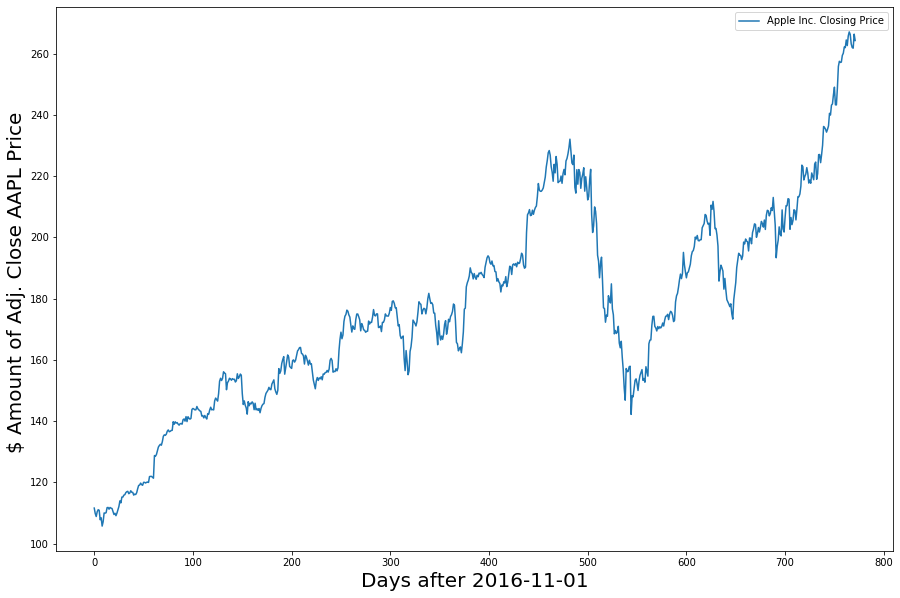

In [673]:
plt.figure(figsize=(15, 10))
plt.plot(np.array(df['adj close'][df.index > '2016-11-01']), label = "Apple Inc. Closing Price")
plt.legend(loc="upper right")
plt.xlabel("Days after 2016-11-01", size=20)
plt.ylabel("$ Amount of Adj. Close AAPL Price ", size=20)
plt.savefig("Figure_1.png")
plt.show()

In [598]:
def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)


In [599]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.values
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [600]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)


In [601]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    d = 0.3
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                          input_shape=(22, 5), 
                          return_sequences=True,
                          name = "LSTM_1"))
    model.add(layers.Dropout(d))
    model.add(layers.LSTM(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                          input_shape=(22, 5), 
                          return_sequences=False,
                          name = "LSTM_2"))
    model.add(layers.Dropout(d))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, kernel_initializer="uniform", activation='relu', name = "Dense_1"))
    model.add(layers.Dense(1,kernel_initializer="uniform",activation='linear', name = "Dense_2"))
    start = time.time()
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse', 'mape', 'mae'])
    print("Compilation Time : ", time.time() - start)
    return model

In [715]:
def build_model_gs(learning_rate, units, layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(units, input_shape=(layers[1], layers[0]), return_sequences=True, name="LSTM_1"))
    model.add(Dropout(d))
        
    model.add(LSTM(units, input_shape=(layers[1], layers[0]), return_sequences=False, name="LSTM_2"))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu', name="Dense_1"))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear', name="Dense_2"))
    start = time.time()    
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mse', 'mape', 'mae'])
    
    print("Compilation Time : ", time.time() - start)
    return model

In [716]:
# Defining the grid for grid search tuning

learning_rate_ = [1e-2, 1e-3, 1e-4]
units_ = np.arange(32, 544, 32)

grid_ = np.zeros((len(learning_rate_), len(units_), 2))
for i in range(len(learning_rate_)):
    for j in range(len(units_)):
        grid_[i, j] = [learning_rate_[i], units_[j]]



In [717]:
%%time
grid_search_results = {'Validation Loss':[], 'Learning Rate': [], 'Units': []}


for i in range(3):
    for j in range(16):
        lr_ = grid_[i][j][0]
        num_units = int(grid_[i][j][1])
        model_grid_search = build_model_gs(learning_rate= lr_, units = num_units, layers = [5, 22, 1])
        GS_model = model_grid_search.fit(X_train,y_train,batch_size=512,epochs=10,validation_data = (X_test, y_test),verbose=1)
        last_epoch_val_loss = GS_model.history['val_loss'][-1]
        grid_search_results['Validation Loss'].append(last_epoch_val_loss)
        grid_search_results['Learning Rate'].append(lr_)
        grid_search_results['Units'].append(num_units)
        print("Validation Loss (MSE) from Last Epoch: " + str(last_epoch_val_loss) + '; Learning Rate:' + str(lr_) +
              '; Number of Units in each LSTM Layer: ' + str(num_units))

Compilation Time :  0.06173300743103027
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 48s - loss: 0.0172 - mse: 0.0172 - mape: 100.2319 - mae: 0.060 - ETA: 23s - loss: 0.0156 - mse: 0.0156 - mape: 338.4128 - mae: 0.060 - ETA: 15s - loss: 0.0141 - mse: 0.0141 - mape: 910.3698 - mae: 0.064 - ETA: 10s - loss: 0.0136 - mse: 0.0136 - mape: 1769.2910 - mae: 0.07 - ETA: 8s - loss: 0.0121 - mse: 0.0121 - mape: 25786.9512 - mae: 0.07 - ETA: 6s - loss: 0.0112 - mse: 0.0112 - mape: 21702.1504 - mae: 0.06 - ETA: 5s - loss: 0.0102 - mse: 0.0102 - mape: 18741.6738 - mae: 0.06 - ETA: 4s - loss: 0.0090 - mse: 0.0090 - mape: 16518.2168 - mae: 0.05 - ETA: 3s - loss: 0.0085 - mse: 0.0085 - mape: 14773.9199 - mae: 0.05 - ETA: 2s - loss: 0.0079 - mse: 0.0079 - mape: 13344.8096 - mae: 0.05 - ETA: 2s - loss: 0.0073 - mse: 0.0073 - mape: 12144.5586 - mae: 0.05 - ETA: 1s - loss: 0.0069 - mse: 0.0069 - mape: 11155.6055 - mae: 0.04 - ETA: 1s - loss: 0

8820/8820 [==============================] - ETA: 1s - loss: 1.5895e-04 - mse: 1.5895e-04 - mape: 196.8056 - mae: 0.00 - ETA: 1s - loss: 1.8868e-04 - mse: 1.8868e-04 - mape: 184.2760 - mae: 0.00 - ETA: 1s - loss: 1.9503e-04 - mse: 1.9503e-04 - mape: 175.2207 - mae: 0.00 - ETA: 1s - loss: 1.8957e-04 - mse: 1.8957e-04 - mape: 2513.3328 - mae: 0.007 - ETA: 1s - loss: 1.8241e-04 - mse: 1.8241e-04 - mape: 2036.0764 - mae: 0.007 - ETA: 0s - loss: 1.8544e-04 - mse: 1.8544e-04 - mape: 1720.1733 - mae: 0.007 - ETA: 0s - loss: 1.9800e-04 - mse: 1.9800e-04 - mape: 1496.3868 - mae: 0.007 - ETA: 0s - loss: 1.9941e-04 - mse: 1.9941e-04 - mape: 1332.9294 - mae: 0.007 - ETA: 0s - loss: 2.1039e-04 - mse: 2.1039e-04 - mape: 1207.7788 - mae: 0.007 - ETA: 0s - loss: 2.1502e-04 - mse: 2.1502e-04 - mape: 1105.6263 - mae: 0.007 - ETA: 0s - loss: 2.1741e-04 - mse: 2.1741e-04 - mape: 1020.5273 - mae: 0.007 - ETA: 0s - loss: 2.1711e-04 - mse: 2.1711e-04 - mape: 950.6811 - mae: 0.007 - ETA: 0s - loss: 2.1658e-04

8820/8820 [==============================] - ETA: 53s - loss: 0.0178 - mse: 0.0178 - mape: 99.2525 - mae: 0.06 - ETA: 26s - loss: 0.0153 - mse: 0.0153 - mape: 412.2345 - mae: 0.060 - ETA: 17s - loss: 0.0132 - mse: 0.0132 - mape: 1843.7062 - mae: 0.07 - ETA: 12s - loss: 0.0117 - mse: 0.0117 - mape: 20934.4062 - mae: 0.066 - ETA: 9s - loss: 0.0100 - mse: 0.0100 - mape: 16914.7773 - mae: 0.060 - ETA: 7s - loss: 0.0088 - mse: 0.0088 - mape: 14240.6523 - mae: 0.05 - ETA: 6s - loss: 0.0077 - mse: 0.0077 - mape: 12313.3682 - mae: 0.05 - ETA: 5s - loss: 0.0070 - mse: 0.0070 - mape: 10855.1191 - mae: 0.04 - ETA: 4s - loss: 0.0063 - mse: 0.0063 - mape: 9677.3760 - mae: 0.0456 - ETA: 3s - loss: 0.0058 - mse: 0.0058 - mape: 8727.1738 - mae: 0.042 - ETA: 2s - loss: 0.0054 - mse: 0.0054 - mape: 7958.0034 - mae: 0.040 - ETA: 2s - loss: 0.0050 - mse: 0.0050 - mape: 7306.4067 - mae: 0.038 - ETA: 1s - loss: 0.0047 - mse: 0.0047 - mape: 6764.6362 - mae: 0.036 - ETA: 1s - loss: 0.0044 - mse: 0.0044 - mape

8820/8820 [==============================] - ETA: 2s - loss: 1.3639e-04 - mse: 1.3639e-04 - mape: 11300.6162 - mae: 0.00 - ETA: 2s - loss: 1.3513e-04 - mse: 1.3513e-04 - mape: 5701.5508 - mae: 0.0061 - ETA: 2s - loss: 1.3550e-04 - mse: 1.3550e-04 - mape: 3838.0723 - mae: 0.006 - ETA: 2s - loss: 1.3489e-04 - mse: 1.3489e-04 - mape: 2918.2483 - mae: 0.006 - ETA: 1s - loss: 1.5164e-04 - mse: 1.5164e-04 - mape: 2359.2771 - mae: 0.006 - ETA: 1s - loss: 1.4852e-04 - mse: 1.4852e-04 - mape: 1983.5468 - mae: 0.006 - ETA: 1s - loss: 1.4918e-04 - mse: 1.4918e-04 - mape: 1719.1198 - mae: 0.006 - ETA: 1s - loss: 1.5237e-04 - mse: 1.5237e-04 - mape: 1527.6841 - mae: 0.006 - ETA: 1s - loss: 1.4705e-04 - mse: 1.4705e-04 - mape: 1372.2089 - mae: 0.006 - ETA: 1s - loss: 1.4919e-04 - mse: 1.4919e-04 - mape: 1245.3080 - mae: 0.006 - ETA: 1s - loss: 1.4913e-04 - mse: 1.4913e-04 - mape: 1142.9208 - mae: 0.006 - ETA: 0s - loss: 1.4476e-04 - mse: 1.4476e-04 - mape: 1060.1278 - mae: 0.006 - ETA: 0s - loss: 1.

8820/8820 [==============================] - ETA: 40s - loss: 0.0157 - mse: 0.0157 - mape: 99.6686 - mae: 0.05 - ETA: 20s - loss: 0.0136 - mse: 0.0136 - mape: 482.1095 - mae: 0.058 - ETA: 14s - loss: 0.0309 - mse: 0.0309 - mape: 167561.2500 - mae: 0.12 - ETA: 10s - loss: 0.0247 - mse: 0.0247 - mape: 126011.3203 - mae: 0.10 - ETA: 8s - loss: 0.0221 - mse: 0.0221 - mape: 100921.7344 - mae: 0.0938 - ETA: 6s - loss: 0.0208 - mse: 0.0208 - mape: 84184.2266 - mae: 0.088 - ETA: 5s - loss: 0.0195 - mse: 0.0195 - mape: 72220.6328 - mae: 0.08 - ETA: 4s - loss: 0.0188 - mse: 0.0188 - mape: 63243.4062 - mae: 0.07 - ETA: 3s - loss: 0.0178 - mse: 0.0178 - mape: 56265.0625 - mae: 0.07 - ETA: 3s - loss: 0.0168 - mse: 0.0168 - mape: 50715.5859 - mae: 0.07 - ETA: 2s - loss: 0.0157 - mse: 0.0157 - mape: 46199.9727 - mae: 0.07 - ETA: 2s - loss: 0.0147 - mse: 0.0147 - mape: 42415.3789 - mae: 0.06 - ETA: 1s - loss: 0.0139 - mse: 0.0139 - mape: 39227.8984 - mae: 0.06 - ETA: 1s - loss: 0.0132 - mse: 0.0132 - 

8820/8820 [==============================] - ETA: 3s - loss: 8.7296e-05 - mse: 8.7296e-05 - mape: 129.7152 - mae: 0.00 - ETA: 3s - loss: 1.2859e-04 - mse: 1.2859e-04 - mape: 119.9291 - mae: 0.00 - ETA: 3s - loss: 1.1555e-04 - mse: 1.1555e-04 - mape: 113.0999 - mae: 0.00 - ETA: 2s - loss: 1.3284e-04 - mse: 1.3284e-04 - mape: 107.5045 - mae: 0.00 - ETA: 2s - loss: 1.2533e-04 - mse: 1.2533e-04 - mape: 105.1374 - mae: 0.00 - ETA: 2s - loss: 1.3506e-04 - mse: 1.3506e-04 - mape: 929.7833 - mae: 0.00 - ETA: 2s - loss: 1.3447e-04 - mse: 1.3447e-04 - mape: 813.1716 - mae: 0.00 - ETA: 1s - loss: 1.4044e-04 - mse: 1.4044e-04 - mape: 721.9230 - mae: 0.00 - ETA: 1s - loss: 1.3714e-04 - mse: 1.3714e-04 - mape: 650.5674 - mae: 0.00 - ETA: 1s - loss: 1.3899e-04 - mse: 1.3899e-04 - mape: 595.4639 - mae: 0.00 - ETA: 1s - loss: 1.4353e-04 - mse: 1.4353e-04 - mape: 549.6375 - mae: 0.00 - ETA: 1s - loss: 1.4877e-04 - mse: 1.4877e-04 - mape: 511.2989 - mae: 0.00 - ETA: 0s - loss: 1.4426e-04 - mse: 1.4426e-0

8820/8820 [==============================] - ETA: 46s - loss: 0.0176 - mse: 0.0176 - mape: 102.1668 - mae: 0.063 - ETA: 23s - loss: 0.0145 - mse: 0.0145 - mape: 352.7467 - mae: 0.058 - ETA: 16s - loss: 0.0200 - mse: 0.0200 - mape: 2793.1604 - mae: 0.09 - ETA: 12s - loss: 0.0178 - mse: 0.0178 - mape: 2300.1306 - mae: 0.08 - ETA: 9s - loss: 0.0164 - mse: 0.0164 - mape: 9742.5254 - mae: 0.0802 - ETA: 8s - loss: 0.0155 - mse: 0.0155 - mape: 8277.7734 - mae: 0.075 - ETA: 6s - loss: 0.0151 - mse: 0.0151 - mape: 7216.3228 - mae: 0.073 - ETA: 5s - loss: 0.0142 - mse: 0.0142 - mape: 6467.5415 - mae: 0.070 - ETA: 4s - loss: 0.0132 - mse: 0.0132 - mape: 5979.4121 - mae: 0.069 - ETA: 3s - loss: 0.0121 - mse: 0.0121 - mape: 5494.2461 - mae: 0.066 - ETA: 3s - loss: 0.0111 - mse: 0.0111 - mape: 5079.1499 - mae: 0.063 - ETA: 2s - loss: 0.0103 - mse: 0.0103 - mape: 4665.8125 - mae: 0.059 - ETA: 2s - loss: 0.0097 - mse: 0.0097 - mape: 4324.0303 - mae: 0.056 - ETA: 1s - loss: 0.0091 - mse: 0.0091 - mape:

8820/8820 [==============================] - ETA: 4s - loss: 1.1139e-04 - mse: 1.1139e-04 - mape: 79.3769 - mae: 0.005 - ETA: 4s - loss: 1.0548e-04 - mse: 1.0548e-04 - mape: 83.4192 - mae: 0.005 - ETA: 3s - loss: 1.0842e-04 - mse: 1.0842e-04 - mape: 82.7733 - mae: 0.005 - ETA: 3s - loss: 1.1835e-04 - mse: 1.1835e-04 - mape: 81.5575 - mae: 0.005 - ETA: 3s - loss: 1.2130e-04 - mse: 1.2130e-04 - mape: 78.1031 - mae: 0.005 - ETA: 3s - loss: 1.3148e-04 - mse: 1.3148e-04 - mape: 88.9912 - mae: 0.005 - ETA: 2s - loss: 1.4522e-04 - mse: 1.4522e-04 - mape: 95.9502 - mae: 0.006 - ETA: 2s - loss: 1.4064e-04 - mse: 1.4064e-04 - mape: 94.4824 - mae: 0.005 - ETA: 2s - loss: 1.4341e-04 - mse: 1.4341e-04 - mape: 94.7395 - mae: 0.006 - ETA: 1s - loss: 1.4168e-04 - mse: 1.4168e-04 - mape: 99.0243 - mae: 0.006 - ETA: 1s - loss: 1.3797e-04 - mse: 1.3797e-04 - mape: 1204.5577 - mae: 0.006 - ETA: 1s - loss: 1.3563e-04 - mse: 1.3563e-04 - mape: 1111.6207 - mae: 0.006 - ETA: 1s - loss: 1.3724e-04 - mse: 1.372

8820/8820 [==============================] - ETA: 45s - loss: 0.0166 - mse: 0.0166 - mape: 99.8214 - mae: 0.06 - ETA: 23s - loss: 0.0148 - mse: 0.0148 - mape: 355.2824 - mae: 0.061 - ETA: 16s - loss: 0.0736 - mse: 0.0736 - mape: 7237.9575 - mae: 0.18 - ETA: 12s - loss: 0.0587 - mse: 0.0587 - mape: 15571.1074 - mae: 0.154 - ETA: 10s - loss: 0.0498 - mse: 0.0498 - mape: 12569.5664 - mae: 0.135 - ETA: 8s - loss: 0.0441 - mse: 0.0441 - mape: 10578.0742 - mae: 0.122 - ETA: 7s - loss: 0.0395 - mse: 0.0395 - mape: 9163.9619 - mae: 0.1128 - ETA: 6s - loss: 0.0357 - mse: 0.0357 - mape: 8105.7441 - mae: 0.105 - ETA: 5s - loss: 0.0324 - mse: 0.0324 - mape: 7362.7119 - mae: 0.099 - ETA: 4s - loss: 0.0300 - mse: 0.0300 - mape: 6940.2891 - mae: 0.098 - ETA: 3s - loss: 0.0275 - mse: 0.0275 - mape: 6335.3667 - mae: 0.091 - ETA: 2s - loss: 0.0255 - mse: 0.0255 - mape: 5823.8013 - mae: 0.086 - ETA: 2s - loss: 0.0236 - mse: 0.0236 - mape: 5394.0947 - mae: 0.080 - ETA: 1s - loss: 0.0223 - mse: 0.0223 - ma

8820/8820 [==============================] - ETA: 5s - loss: 1.2351e-04 - mse: 1.2351e-04 - mape: 128.5652 - mae: 0.00 - ETA: 5s - loss: 1.0312e-04 - mse: 1.0312e-04 - mape: 105.1034 - mae: 0.00 - ETA: 4s - loss: 9.6779e-05 - mse: 9.6779e-05 - mape: 98.7999 - mae: 0.0048 - ETA: 4s - loss: 9.5980e-05 - mse: 9.5980e-05 - mape: 98.1730 - mae: 0.004 - ETA: 4s - loss: 9.6338e-05 - mse: 9.6338e-05 - mape: 91.1325 - mae: 0.004 - ETA: 3s - loss: 1.0376e-04 - mse: 1.0376e-04 - mape: 91.4170 - mae: 0.004 - ETA: 3s - loss: 1.0605e-04 - mse: 1.0605e-04 - mape: 993.4553 - mae: 0.00 - ETA: 3s - loss: 1.0600e-04 - mse: 1.0600e-04 - mape: 881.7986 - mae: 0.00 - ETA: 2s - loss: 1.0552e-04 - mse: 1.0552e-04 - mape: 795.1312 - mae: 0.00 - ETA: 2s - loss: 1.0509e-04 - mse: 1.0509e-04 - mape: 725.9756 - mae: 0.00 - ETA: 2s - loss: 1.0310e-04 - mse: 1.0310e-04 - mape: 669.1434 - mae: 0.00 - ETA: 1s - loss: 1.0427e-04 - mse: 1.0427e-04 - mape: 619.6184 - mae: 0.00 - ETA: 1s - loss: 1.0343e-04 - mse: 1.0343e-

8820/8820 [==============================] - ETA: 3:12 - loss: 0.0139 - mse: 0.0139 - mape: 99.7182 - mae: 0.053 - ETA: 1:33 - loss: 0.0124 - mse: 0.0124 - mape: 445.1194 - mae: 0.05 - ETA: 1:00 - loss: 0.1648 - mse: 0.1648 - mape: 8669.9102 - mae: 0.263 - ETA: 43s - loss: 0.1267 - mse: 0.1267 - mape: 6758.4990 - mae: 0.212 - ETA: 32s - loss: 0.1035 - mse: 0.1035 - mape: 5493.5151 - mae: 0.18 - ETA: 25s - loss: 0.0885 - mse: 0.0885 - mape: 4620.7529 - mae: 0.15 - ETA: 20s - loss: 0.0783 - mse: 0.0783 - mape: 3995.0933 - mae: 0.14 - ETA: 16s - loss: 0.0699 - mse: 0.0699 - mape: 3528.3403 - mae: 0.13 - ETA: 13s - loss: 0.0632 - mse: 0.0632 - mape: 3176.8638 - mae: 0.12 - ETA: 11s - loss: 0.0578 - mse: 0.0578 - mape: 2947.1216 - mae: 0.11 - ETA: 8s - loss: 0.0532 - mse: 0.0532 - mape: 2748.4355 - mae: 0.1095 - ETA: 7s - loss: 0.0492 - mse: 0.0492 - mape: 2574.4570 - mae: 0.103 - ETA: 5s - loss: 0.0458 - mse: 0.0458 - mape: 2919.7085 - mae: 0.097 - ETA: 3s - loss: 0.0427 - mse: 0.0427 - ma

8820/8820 [==============================] - ETA: 5s - loss: 3.9086e-04 - mse: 3.9086e-04 - mape: 149.5487 - mae: 0.00 - ETA: 5s - loss: 3.8315e-04 - mse: 3.8315e-04 - mape: 156.4420 - mae: 0.01 - ETA: 4s - loss: 5.4139e-04 - mse: 5.4139e-04 - mape: 161.8382 - mae: 0.01 - ETA: 4s - loss: 5.0539e-04 - mse: 5.0539e-04 - mape: 3125.5264 - mae: 0.010 - ETA: 4s - loss: 5.0709e-04 - mse: 5.0709e-04 - mape: 2541.2805 - mae: 0.011 - ETA: 3s - loss: 4.8478e-04 - mse: 4.8478e-04 - mape: 2151.7371 - mae: 0.010 - ETA: 3s - loss: 4.8286e-04 - mse: 4.8286e-04 - mape: 1862.9612 - mae: 0.010 - ETA: 3s - loss: 4.6104e-04 - mse: 4.6104e-04 - mape: 1657.6812 - mae: 0.010 - ETA: 2s - loss: 4.3445e-04 - mse: 4.3445e-04 - mape: 1489.4095 - mae: 0.010 - ETA: 2s - loss: 4.2074e-04 - mse: 4.2074e-04 - mape: 1359.3279 - mae: 0.010 - ETA: 2s - loss: 4.0336e-04 - mse: 4.0336e-04 - mape: 1254.3036 - mae: 0.010 - ETA: 1s - loss: 3.9068e-04 - mse: 3.9068e-04 - mape: 1165.7507 - mae: 0.009 - ETA: 1s - loss: 3.7948e-0

8820/8820 [==============================] - ETA: 47s - loss: 0.0176 - mse: 0.0176 - mape: 97.5725 - mae: 0.06 - ETA: 26s - loss: 0.0115 - mse: 0.0115 - mape: 800.1373 - mae: 0.058 - ETA: 18s - loss: 0.4652 - mse: 0.4652 - mape: 11075.1260 - mae: 0.425 - ETA: 14s - loss: 0.3512 - mse: 0.3512 - mape: 8750.5117 - mae: 0.336 - ETA: 11s - loss: 0.2834 - mse: 0.2834 - mape: 7227.8037 - mae: 0.28 - ETA: 10s - loss: 0.2388 - mse: 0.2388 - mape: 6241.7051 - mae: 0.24 - ETA: 8s - loss: 0.2065 - mse: 0.2065 - mape: 5646.1221 - mae: 0.2221 - ETA: 7s - loss: 0.1823 - mse: 0.1823 - mape: 5198.5991 - mae: 0.204 - ETA: 6s - loss: 0.1632 - mse: 0.1632 - mape: 4892.1270 - mae: 0.190 - ETA: 5s - loss: 0.1474 - mse: 0.1474 - mape: 4590.7988 - mae: 0.176 - ETA: 4s - loss: 0.1355 - mse: 0.1355 - mape: 4442.3945 - mae: 0.170 - ETA: 3s - loss: 0.1255 - mse: 0.1255 - mape: 4109.5474 - mae: 0.161 - ETA: 2s - loss: 0.1170 - mse: 0.1170 - mape: 3808.9834 - mae: 0.153 - ETA: 2s - loss: 0.1097 - mse: 0.1097 - mape

8820/8820 [==============================] - ETA: 7s - loss: 2.9506e-04 - mse: 2.9506e-04 - mape: 168.2896 - mae: 0.01 - ETA: 6s - loss: 3.4108e-04 - mse: 3.4108e-04 - mape: 158.9271 - mae: 0.01 - ETA: 6s - loss: 3.5394e-04 - mse: 3.5394e-04 - mape: 146.3353 - mae: 0.01 - ETA: 6s - loss: 3.3533e-04 - mse: 3.3533e-04 - mape: 144.7927 - mae: 0.01 - ETA: 5s - loss: 3.5201e-04 - mse: 3.5201e-04 - mape: 142.6689 - mae: 0.01 - ETA: 5s - loss: 3.3105e-04 - mse: 3.3105e-04 - mape: 140.3006 - mae: 0.01 - ETA: 4s - loss: 3.3140e-04 - mse: 3.3140e-04 - mape: 147.9028 - mae: 0.01 - ETA: 4s - loss: 3.2509e-04 - mse: 3.2509e-04 - mape: 147.5855 - mae: 0.01 - ETA: 3s - loss: 3.1495e-04 - mse: 3.1495e-04 - mape: 151.8733 - mae: 0.01 - ETA: 3s - loss: 3.1425e-04 - mse: 3.1425e-04 - mape: 156.2289 - mae: 0.01 - ETA: 2s - loss: 3.1159e-04 - mse: 3.1159e-04 - mape: 156.3300 - mae: 0.01 - ETA: 2s - loss: 3.0799e-04 - mse: 3.0799e-04 - mape: 332.7560 - mae: 0.01 - ETA: 1s - loss: 3.0779e-04 - mse: 3.0779e-0

8820/8820 [==============================] - ETA: 52s - loss: 0.0154 - mse: 0.0154 - mape: 100.3835 - mae: 0.059 - ETA: 29s - loss: 0.0123 - mse: 0.0123 - mape: 451.4385 - mae: 0.056 - ETA: 20s - loss: 0.3388 - mse: 0.3388 - mape: 13883.5273 - mae: 0.366 - ETA: 16s - loss: 0.2576 - mse: 0.2576 - mape: 11784.5215 - mae: 0.302 - ETA: 13s - loss: 0.2088 - mse: 0.2088 - mape: 9494.4453 - mae: 0.252 - ETA: 11s - loss: 0.1760 - mse: 0.1760 - mape: 7983.2075 - mae: 0.21 - ETA: 9s - loss: 0.1525 - mse: 0.1525 - mape: 6882.7891 - mae: 0.1948 - ETA: 8s - loss: 0.1342 - mse: 0.1342 - mape: 6040.5210 - mae: 0.175 - ETA: 6s - loss: 0.1335 - mse: 0.1335 - mape: 6822.9746 - mae: 0.194 - ETA: 5s - loss: 0.1216 - mse: 0.1216 - mape: 6463.8213 - mae: 0.184 - ETA: 4s - loss: 0.1119 - mse: 0.1119 - mape: 5928.0503 - mae: 0.173 - ETA: 3s - loss: 0.1039 - mse: 0.1039 - mape: 5488.9531 - mae: 0.165 - ETA: 3s - loss: 0.0974 - mse: 0.0974 - mape: 5101.1484 - mae: 0.157 - ETA: 2s - loss: 0.0916 - mse: 0.0916 - 

8820/8820 [==============================] - ETA: 8s - loss: 0.0131 - mse: 0.0131 - mape: 2365.0337 - mae: 0.079 - ETA: 8s - loss: 0.0130 - mse: 0.0130 - mape: 2090.1831 - mae: 0.078 - ETA: 7s - loss: 0.0123 - mse: 0.0123 - mape: 2024.7904 - mae: 0.075 - ETA: 7s - loss: 0.0121 - mse: 0.0121 - mape: 1971.7571 - mae: 0.073 - ETA: 6s - loss: 0.0115 - mse: 0.0115 - mape: 1985.2893 - mae: 0.072 - ETA: 6s - loss: 0.0118 - mse: 0.0118 - mape: 1968.4781 - mae: 0.072 - ETA: 5s - loss: 0.0117 - mse: 0.0117 - mape: 1982.3741 - mae: 0.072 - ETA: 5s - loss: 0.0119 - mse: 0.0119 - mape: 2023.3890 - mae: 0.073 - ETA: 4s - loss: 0.0123 - mse: 0.0123 - mape: 2035.2765 - mae: 0.074 - ETA: 3s - loss: 0.0126 - mse: 0.0126 - mape: 2084.6958 - mae: 0.076 - ETA: 3s - loss: 0.0126 - mse: 0.0126 - mape: 2173.0762 - mae: 0.077 - ETA: 2s - loss: 0.0127 - mse: 0.0127 - mape: 2277.3074 - mae: 0.078 - ETA: 2s - loss: 0.0128 - mse: 0.0128 - mape: 2294.3718 - mae: 0.079 - ETA: 1s - loss: 0.0127 - mse: 0.0127 - mape: 

8820/8820 [==============================] - ETA: 54s - loss: 0.0141 - mse: 0.0141 - mape: 97.6806 - mae: 0.05 - ETA: 30s - loss: 0.0108 - mse: 0.0108 - mape: 845.1423 - mae: 0.054 - ETA: 21s - loss: 0.7756 - mse: 0.7756 - mape: 18930.8613 - mae: 0.539 - ETA: 17s - loss: 0.5918 - mse: 0.5918 - mape: 16285.0898 - mae: 0.452 - ETA: 14s - loss: 0.4757 - mse: 0.4757 - mape: 13178.3281 - mae: 0.373 - ETA: 12s - loss: 0.4000 - mse: 0.4000 - mape: 11670.9336 - mae: 0.332 - ETA: 10s - loss: 0.3443 - mse: 0.3443 - mape: 10379.6582 - mae: 0.291 - ETA: 8s - loss: 0.3032 - mse: 0.3032 - mape: 9207.9844 - mae: 0.2639  - ETA: 7s - loss: 0.2713 - mse: 0.2713 - mape: 8298.4414 - mae: 0.242 - ETA: 6s - loss: 0.2457 - mse: 0.2457 - mape: 7626.4385 - mae: 0.226 - ETA: 5s - loss: 0.2246 - mse: 0.2246 - mape: 6996.5942 - mae: 0.212 - ETA: 4s - loss: 0.2063 - mse: 0.2063 - mape: 6435.7363 - mae: 0.197 - ETA: 3s - loss: 0.1910 - mse: 0.1910 - mape: 6046.3184 - mae: 0.186 - ETA: 2s - loss: 0.1777 - mse: 0.177

8820/8820 [==============================] - ETA: 10s - loss: 2.4057e-04 - mse: 2.4057e-04 - mape: 242.0384 - mae: 0.009 - ETA: 9s - loss: 2.1251e-04 - mse: 2.1251e-04 - mape: 225.6984 - mae: 0.009 - ETA: 9s - loss: 2.0710e-04 - mse: 2.0710e-04 - mape: 219.2293 - mae: 0.00 - ETA: 8s - loss: 1.8680e-04 - mse: 1.8680e-04 - mape: 191.1492 - mae: 0.00 - ETA: 7s - loss: 1.8238e-04 - mse: 1.8238e-04 - mape: 178.8958 - mae: 0.00 - ETA: 7s - loss: 1.7996e-04 - mse: 1.7996e-04 - mape: 166.7816 - mae: 0.00 - ETA: 6s - loss: 1.7750e-04 - mse: 1.7750e-04 - mape: 161.6901 - mae: 0.00 - ETA: 5s - loss: 1.7862e-04 - mse: 1.7862e-04 - mape: 159.0726 - mae: 0.00 - ETA: 5s - loss: 1.7275e-04 - mse: 1.7275e-04 - mape: 156.1475 - mae: 0.00 - ETA: 4s - loss: 1.7414e-04 - mse: 1.7414e-04 - mape: 405.1571 - mae: 0.00 - ETA: 4s - loss: 1.7548e-04 - mse: 1.7548e-04 - mape: 381.0696 - mae: 0.00 - ETA: 3s - loss: 1.7590e-04 - mse: 1.7590e-04 - mape: 362.6108 - mae: 0.00 - ETA: 2s - loss: 1.7118e-04 - mse: 1.7118

8820/8820 [==============================] - ETA: 54s - loss: 0.0137 - mse: 0.0137 - mape: 150.0904 - mae: 0.053 - ETA: 30s - loss: 0.0116 - mse: 0.0116 - mape: 488.4305 - mae: 0.053 - ETA: 22s - loss: 0.5653 - mse: 0.5653 - mape: 20312.9668 - mae: 0.465 - ETA: 18s - loss: 0.4337 - mse: 0.4337 - mape: 16973.6875 - mae: 0.395 - ETA: 15s - loss: 0.3489 - mse: 0.3489 - mape: 13655.9238 - mae: 0.325 - ETA: 12s - loss: 0.2939 - mse: 0.2939 - mape: 12357.6016 - mae: 0.291 - ETA: 11s - loss: 0.2529 - mse: 0.2529 - mape: 10837.7012 - mae: 0.258 - ETA: 9s - loss: 0.2257 - mse: 0.2257 - mape: 10307.3965 - mae: 0.247 - ETA: 8s - loss: 0.2025 - mse: 0.2025 - mape: 9211.1611 - mae: 0.2273 - ETA: 6s - loss: 0.1893 - mse: 0.1893 - mape: 9347.0176 - mae: 0.229 - ETA: 5s - loss: 0.1742 - mse: 0.1742 - mape: 8542.0693 - mae: 0.216 - ETA: 4s - loss: 0.1615 - mse: 0.1615 - mape: 7974.5430 - mae: 0.206 - ETA: 3s - loss: 0.1512 - mse: 0.1512 - mape: 7415.7012 - mae: 0.197 - ETA: 2s - loss: 0.1418 - mse: 0.1

8820/8820 [==============================] - ETA: 12s - loss: 7.2560e-04 - mse: 7.2560e-04 - mape: 398.8991 - mae: 0.016 - ETA: 12s - loss: 6.6557e-04 - mse: 6.6557e-04 - mape: 394.0254 - mae: 0.016 - ETA: 11s - loss: 6.8986e-04 - mse: 6.8986e-04 - mape: 429.4361 - mae: 0.016 - ETA: 10s - loss: 6.7718e-04 - mse: 6.7718e-04 - mape: 452.7314 - mae: 0.016 - ETA: 9s - loss: 6.5735e-04 - mse: 6.5735e-04 - mape: 432.8382 - mae: 0.016 - ETA: 8s - loss: 6.6126e-04 - mse: 6.6126e-04 - mape: 418.2420 - mae: 0.01 - ETA: 8s - loss: 6.3314e-04 - mse: 6.3314e-04 - mape: 3439.3242 - mae: 0.015 - ETA: 7s - loss: 6.1601e-04 - mse: 6.1601e-04 - mape: 3047.9250 - mae: 0.015 - ETA: 14:34 - loss: 6.1537e-04 - mse: 6.1537e-04 - mape: 2750.6631 - mae: 0.01 - ETA: 11:32 - loss: 5.9582e-04 - mse: 5.9582e-04 - mape: 2506.3110 - mae: 0.01 - ETA: 9:02 - loss: 5.8171e-04 - mse: 5.8171e-04 - mape: 2313.5166 - mae: 0.0154 - ETA: 6:57 - loss: 5.6708e-04 - mse: 5.6708e-04 - mape: 2162.2078 - mae: 0.015 - ETA: 5:12 - l

8820/8820 [==============================] - ETA: 53s - loss: 0.0149 - mse: 0.0149 - mape: 99.5196 - mae: 0.05 - ETA: 31s - loss: 0.0134 - mse: 0.0134 - mape: 408.6304 - mae: 0.059 - ETA: 24s - loss: 0.6143 - mse: 0.6143 - mape: 974376.1875 - mae: 0.48 - ETA: 19s - loss: 0.4668 - mse: 0.4668 - mape: 732244.1250 - mae: 0.40 - ETA: 16s - loss: 0.3758 - mse: 0.3758 - mape: 586119.4375 - mae: 0.33 - ETA: 14s - loss: 0.3152 - mse: 0.3152 - mape: 488456.1250 - mae: 0.28 - ETA: 12s - loss: 0.3018 - mse: 0.3018 - mape: 421593.6875 - mae: 0.31 - ETA: 10s - loss: 0.2663 - mse: 0.2663 - mape: 368944.8125 - mae: 0.28 - ETA: 9s - loss: 0.2385 - mse: 0.2385 - mape: 327971.2188 - mae: 0.2563 - ETA: 8s - loss: 0.2159 - mse: 0.2159 - mape: 295262.9375 - mae: 0.236 - ETA: 6s - loss: 0.1972 - mse: 0.1972 - mape: 268652.7188 - mae: 0.222 - ETA: 5s - loss: 0.1820 - mse: 0.1820 - mape: 246533.2031 - mae: 0.211 - ETA: 4s - loss: 0.1689 - mse: 0.1689 - mape: 227777.1406 - mae: 0.201 - ETA: 3s - loss: 0.1579 -

8820/8820 [==============================] - ETA: 13s - loss: 0.0139 - mse: 0.0139 - mape: 17547.3359 - mae: 0.060 - ETA: 13s - loss: 0.0153 - mse: 0.0153 - mape: 8935.1504 - mae: 0.063 - ETA: 12s - loss: 0.0158 - mse: 0.0158 - mape: 6021.7012 - mae: 0.06 - ETA: 11s - loss: 0.0153 - mse: 0.0153 - mape: 4536.4185 - mae: 0.06 - ETA: 10s - loss: 0.0150 - mse: 0.0150 - mape: 3657.3047 - mae: 0.05 - ETA: 9s - loss: 0.0152 - mse: 0.0152 - mape: 3090.2385 - mae: 0.0587 - ETA: 8s - loss: 0.0154 - mse: 0.0154 - mape: 2700.5913 - mae: 0.059 - ETA: 8s - loss: 0.0153 - mse: 0.0153 - mape: 2427.3262 - mae: 0.059 - ETA: 7s - loss: 0.0154 - mse: 0.0154 - mape: 2243.8728 - mae: 0.059 - ETA: 6s - loss: 0.0154 - mse: 0.0154 - mape: 2095.8130 - mae: 0.060 - ETA: 5s - loss: 0.0154 - mse: 0.0154 - mape: 1973.6980 - mae: 0.060 - ETA: 4s - loss: 0.0152 - mse: 0.0152 - mape: 1897.0089 - mae: 0.061 - ETA: 3s - loss: 0.0152 - mse: 0.0152 - mape: 1834.4634 - mae: 0.061 - ETA: 2s - loss: 0.0149 - mse: 0.0149 - ma

8820/8820 [==============================] - ETA: 57s - loss: 0.0167 - mse: 0.0167 - mape: 99.8107 - mae: 0.06 - ETA: 34s - loss: 0.0115 - mse: 0.0115 - mape: 572.2034 - mae: 0.054 - ETA: 25s - loss: 1.3150 - mse: 1.3150 - mape: 1341260.1250 - mae: 0.694 - ETA: 20s - loss: 0.9971 - mse: 0.9971 - mape: 1008042.1250 - mae: 0.570 - ETA: 17s - loss: 0.8008 - mse: 0.8008 - mape: 806471.7500 - mae: 0.467 - ETA: 15s - loss: 0.6698 - mse: 0.6698 - mape: 672198.8750 - mae: 0.40 - ETA: 13s - loss: 0.5760 - mse: 0.5760 - mape: 576470.9375 - mae: 0.35 - ETA: 11s - loss: 0.5059 - mse: 0.5059 - mape: 505009.1875 - mae: 0.32 - ETA: 9s - loss: 0.4512 - mse: 0.4512 - mape: 449270.0312 - mae: 0.2976 - ETA: 8s - loss: 0.4072 - mse: 0.4072 - mape: 404526.3125 - mae: 0.275 - ETA: 7s - loss: 0.3714 - mse: 0.3714 - mape: 367887.7188 - mae: 0.256 - ETA: 6s - loss: 0.3420 - mse: 0.3420 - mape: 337313.5000 - mae: 0.241 - ETA: 4s - loss: 0.3166 - mse: 0.3166 - mape: 311465.9375 - mae: 0.227 - ETA: 3s - loss: 0.2

8820/8820 [==============================] - ETA: 15s - loss: 0.0112 - mse: 0.0112 - mape: 2107.9390 - mae: 0.07 - ETA: 14s - loss: 0.0127 - mse: 0.0127 - mape: 2285.3887 - mae: 0.07 - ETA: 13s - loss: 0.0126 - mse: 0.0126 - mape: 2426.5771 - mae: 0.08 - ETA: 12s - loss: 0.0126 - mse: 0.0126 - mape: 2543.5469 - mae: 0.08 - ETA: 11s - loss: 0.0126 - mse: 0.0126 - mape: 2562.9292 - mae: 0.08 - ETA: 10s - loss: 0.0127 - mse: 0.0127 - mape: 2470.5942 - mae: 0.08 - ETA: 9s - loss: 0.0127 - mse: 0.0127 - mape: 2410.2747 - mae: 0.0809 - ETA: 8s - loss: 0.0129 - mse: 0.0129 - mape: 2395.5293 - mae: 0.080 - ETA: 7s - loss: 0.0129 - mse: 0.0129 - mape: 2318.1389 - mae: 0.080 - ETA: 6s - loss: 0.0129 - mse: 0.0129 - mape: 2308.2800 - mae: 0.080 - ETA: 6s - loss: 0.0127 - mse: 0.0127 - mape: 17138.9766 - mae: 0.08 - ETA: 5s - loss: 0.0126 - mse: 0.0126 - mape: 15902.9990 - mae: 0.08 - ETA: 4s - loss: 0.0125 - mse: 0.0125 - mape: 14852.9316 - mae: 0.08 - ETA: 3s - loss: 0.0125 - mse: 0.0125 - mape:

8820/8820 [==============================] - ETA: 59s - loss: 0.0151 - mse: 0.0151 - mape: 97.7960 - mae: 0.05 - ETA: 35s - loss: 0.0113 - mse: 0.0113 - mape: 528.7475 - mae: 0.053 - ETA: 26s - loss: 1.0766 - mse: 1.0766 - mape: 25595.8457 - mae: 0.630 - ETA: 22s - loss: 0.8112 - mse: 0.8112 - mape: 19740.4766 - mae: 0.493 - ETA: 18s - loss: 0.6537 - mse: 0.6537 - mape: 16407.9902 - mae: 0.421 - ETA: 16s - loss: 0.5471 - mse: 0.5471 - mape: 13703.9102 - mae: 0.360 - ETA: 14s - loss: 0.4708 - mse: 0.4708 - mape: 11953.4609 - mae: 0.317 - ETA: 12s - loss: 0.4134 - mse: 0.4134 - mape: 10745.6299 - mae: 0.287 - ETA: 10s - loss: 0.3691 - mse: 0.3691 - mape: 9942.1943 - mae: 0.266 - ETA: 9s - loss: 0.3335 - mse: 0.3335 - mape: 9140.4189 - mae: 0.2476 - ETA: 7s - loss: 0.3042 - mse: 0.3042 - mape: 8435.5996 - mae: 0.231 - ETA: 6s - loss: 0.2801 - mse: 0.2801 - mape: 7888.7437 - mae: 0.218 - ETA: 5s - loss: 0.2594 - mse: 0.2594 - mape: 7461.8745 - mae: 0.207 - ETA: 3s - loss: 0.2418 - mse: 0.2

8820/8820 [==============================] - ETA: 16s - loss: 0.0131 - mse: 0.0131 - mape: 2275.1191 - mae: 0.08 - ETA: 15s - loss: 0.0129 - mse: 0.0129 - mape: 2447.0317 - mae: 0.08 - ETA: 14s - loss: 0.0129 - mse: 0.0129 - mape: 2428.8577 - mae: 0.07 - ETA: 13s - loss: 0.0130 - mse: 0.0130 - mape: 2281.0337 - mae: 0.07 - ETA: 12s - loss: 0.0130 - mse: 0.0130 - mape: 2280.1411 - mae: 0.07 - ETA: 11s - loss: 0.0126 - mse: 0.0126 - mape: 2206.9187 - mae: 0.07 - ETA: 10s - loss: 0.0129 - mse: 0.0129 - mape: 2148.6624 - mae: 0.07 - ETA: 9s - loss: 0.0126 - mse: 0.0126 - mape: 2181.2322 - mae: 0.0786 - ETA: 8s - loss: 0.0124 - mse: 0.0124 - mape: 17567.6484 - mae: 0.07 - ETA: 7s - loss: 0.0126 - mse: 0.0126 - mape: 16041.9814 - mae: 0.07 - ETA: 6s - loss: 0.0126 - mse: 0.0126 - mape: 14806.8242 - mae: 0.07 - ETA: 5s - loss: 0.0126 - mse: 0.0126 - mape: 13784.9141 - mae: 0.07 - ETA: 4s - loss: 0.0126 - mse: 0.0126 - mape: 12904.9834 - mae: 0.07 - ETA: 3s - loss: 0.0125 - mse: 0.0125 - mape:

8820/8820 [==============================] - ETA: 57s - loss: 0.0157 - mse: 0.0157 - mape: 101.3658 - mae: 0.060 - ETA: 36s - loss: 0.0122 - mse: 0.0122 - mape: 534.1870 - mae: 0.057 - ETA: 28s - loss: 0.9618 - mse: 0.9618 - mape: 21103.9941 - mae: 0.600 - ETA: 23s - loss: 0.7262 - mse: 0.7262 - mape: 16894.8555 - mae: 0.479 - ETA: 20s - loss: 0.5841 - mse: 0.5841 - mape: 13666.7471 - mae: 0.396 - ETA: 17s - loss: 0.4888 - mse: 0.4888 - mape: 11890.8203 - mae: 0.343 - ETA: 15s - loss: 0.4206 - mse: 0.4206 - mape: 10494.8125 - mae: 0.304 - ETA: 13s - loss: 0.3697 - mse: 0.3697 - mape: 9437.3809 - mae: 0.276 - ETA: 11s - loss: 0.3301 - mse: 0.3301 - mape: 8661.1328 - mae: 0.25 - ETA: 10s - loss: 0.2985 - mse: 0.2985 - mape: 8060.8018 - mae: 0.23 - ETA: 8s - loss: 0.2726 - mse: 0.2726 - mape: 7519.1167 - mae: 0.2235 - ETA: 7s - loss: 0.2509 - mse: 0.2509 - mape: 7089.5957 - mae: 0.211 - ETA: 5s - loss: 0.2324 - mse: 0.2324 - mape: 6674.1431 - mae: 0.200 - ETA: 4s - loss: 0.2167 - mse: 0.2

8820/8820 [==============================] - ETA: 19s - loss: 0.0126 - mse: 0.0126 - mape: 2007.7540 - mae: 0.07 - ETA: 18s - loss: 0.0139 - mse: 0.0139 - mape: 2017.3604 - mae: 0.08 - ETA: 17s - loss: 0.0135 - mse: 0.0135 - mape: 46711.1211 - mae: 0.080 - ETA: 16s - loss: 0.0137 - mse: 0.0137 - mape: 35623.4062 - mae: 0.081 - ETA: 15s - loss: 0.0131 - mse: 0.0131 - mape: 28918.9961 - mae: 0.080 - ETA: 13s - loss: 0.0129 - mse: 0.0129 - mape: 24463.4824 - mae: 0.079 - ETA: 12s - loss: 0.0127 - mse: 0.0127 - mape: 21318.7383 - mae: 0.079 - ETA: 11s - loss: 0.0128 - mse: 0.0128 - mape: 18883.4609 - mae: 0.079 - ETA: 10s - loss: 0.0126 - mse: 0.0126 - mape: 16987.2266 - mae: 0.078 - ETA: 9s - loss: 0.0127 - mse: 0.0127 - mape: 15524.1816 - mae: 0.078 - ETA: 7s - loss: 0.0126 - mse: 0.0126 - mape: 14282.9531 - mae: 0.07 - ETA: 6s - loss: 0.0125 - mse: 0.0125 - mape: 13307.6436 - mae: 0.07 - ETA: 5s - loss: 0.0126 - mse: 0.0126 - mape: 12447.9238 - mae: 0.07 - ETA: 4s - loss: 0.0128 - mse: 

8820/8820 [==============================] - ETA: 1:05 - loss: 0.0159 - mse: 0.0159 - mape: 102.7231 - mae: 0.05 - ETA: 41s - loss: 0.0118 - mse: 0.0118 - mape: 413.0718 - mae: 0.0530 - ETA: 32s - loss: 1.0854 - mse: 1.0854 - mape: 20998.1465 - mae: 0.632 - ETA: 26s - loss: 0.8277 - mse: 0.8277 - mape: 15954.5352 - mae: 0.508 - ETA: 24s - loss: 0.6652 - mse: 0.6652 - mape: 12810.4121 - mae: 0.418 - ETA: 20s - loss: 0.5572 - mse: 0.5572 - mape: 10703.3740 - mae: 0.359 - ETA: 18s - loss: 0.4801 - mse: 0.4801 - mape: 9209.5879 - mae: 0.316 - ETA: 15s - loss: 0.4218 - mse: 0.4218 - mape: 8107.5845 - mae: 0.28 - ETA: 13s - loss: 0.3763 - mse: 0.3763 - mape: 7298.8247 - mae: 0.25 - ETA: 11s - loss: 0.3398 - mse: 0.3398 - mape: 6797.1768 - mae: 0.23 - ETA: 9s - loss: 0.3109 - mse: 0.3109 - mape: 6676.0078 - mae: 0.2292 - ETA: 8s - loss: 0.2865 - mse: 0.2865 - mape: 6528.9199 - mae: 0.221 - ETA: 6s - loss: 0.2660 - mse: 0.2660 - mape: 6373.8794 - mae: 0.213 - ETA: 4s - loss: 0.2477 - mse: 0.24

8820/8820 [==============================] - ETA: 20s - loss: 0.0023 - mse: 0.0023 - mape: 901.7909 - mae: 0.031 - ETA: 19s - loss: 0.0024 - mse: 0.0024 - mape: 819.3375 - mae: 0.031 - ETA: 17s - loss: 0.0024 - mse: 0.0024 - mape: 724.1057 - mae: 0.030 - ETA: 16s - loss: 0.0022 - mse: 0.0022 - mape: 651.4658 - mae: 0.028 - ETA: 15s - loss: 0.0022 - mse: 0.0022 - mape: 612.4755 - mae: 0.027 - ETA: 14s - loss: 0.0093 - mse: 0.0093 - mape: 2366.8464 - mae: 0.05 - ETA: 12s - loss: 0.0207 - mse: 0.0207 - mape: 3752.6145 - mae: 0.08 - ETA: 11s - loss: 0.0210 - mse: 0.0210 - mape: 3863.7432 - mae: 0.09 - ETA: 10s - loss: 0.0224 - mse: 0.0224 - mape: 4098.6606 - mae: 0.10 - ETA: 9s - loss: 0.0218 - mse: 0.0218 - mape: 3773.2808 - mae: 0.0970 - ETA: 7s - loss: 0.0212 - mse: 0.0212 - mape: 3444.1670 - mae: 0.093 - ETA: 6s - loss: 0.0204 - mse: 0.0204 - mape: 3172.0925 - mae: 0.089 - ETA: 5s - loss: 0.0202 - mse: 0.0202 - mape: 2945.0981 - mae: 0.087 - ETA: 4s - loss: 0.0199 - mse: 0.0199 - mape:

8820/8820 [==============================] - ETA: 1:05 - loss: 0.0152 - mse: 0.0152 - mape: 101.4827 - mae: 0.05 - ETA: 40s - loss: 0.0104 - mse: 0.0104 - mape: 485.5634 - mae: 0.0508 - ETA: 31s - loss: 1.5866 - mse: 1.5866 - mape: 28458.7480 - mae: 0.757 - ETA: 26s - loss: 1.1939 - mse: 1.1939 - mape: 22239.1641 - mae: 0.595 - ETA: 23s - loss: 0.9585 - mse: 0.9585 - mape: 17929.3340 - mae: 0.489 - ETA: 20s - loss: 0.8020 - mse: 0.8020 - mape: 14976.2705 - mae: 0.420 - ETA: 18s - loss: 0.6897 - mse: 0.6897 - mape: 12853.9189 - mae: 0.368 - ETA: 15s - loss: 0.6052 - mse: 0.6052 - mape: 11330.4385 - mae: 0.329 - ETA: 14s - loss: 0.5393 - mse: 0.5393 - mape: 10295.9834 - mae: 0.301 - ETA: 12s - loss: 0.4869 - mse: 0.4869 - mape: 9621.6367 - mae: 0.282 - ETA: 10s - loss: 0.4439 - mse: 0.4439 - mape: 21858.6816 - mae: 0.264 - ETA: 8s - loss: 0.4080 - mse: 0.4080 - mape: 20208.7441 - mae: 0.249 - ETA: 6s - loss: 0.3776 - mse: 0.3776 - mape: 18746.8926 - mae: 0.23 - ETA: 5s - loss: 0.3515 - m

8820/8820 [==============================] - ETA: 26s - loss: 0.0133 - mse: 0.0133 - mape: 3090.1006 - mae: 0.08 - ETA: 24s - loss: 0.0135 - mse: 0.0135 - mape: 2600.3542 - mae: 0.08 - ETA: 22s - loss: 0.0137 - mse: 0.0137 - mape: 2526.4265 - mae: 0.08 - ETA: 21s - loss: 0.0132 - mse: 0.0132 - mape: 2354.3599 - mae: 0.08 - ETA: 19s - loss: 0.0129 - mse: 0.0129 - mape: 2347.7200 - mae: 0.08 - ETA: 17s - loss: 0.0128 - mse: 0.0128 - mape: 2281.9670 - mae: 0.08 - ETA: 16s - loss: 0.0126 - mse: 0.0126 - mape: 2351.5239 - mae: 0.07 - ETA: 14s - loss: 0.0124 - mse: 0.0124 - mape: 16928.9316 - mae: 0.078 - ETA: 13s - loss: 0.0126 - mse: 0.0126 - mape: 15270.4043 - mae: 0.078 - ETA: 11s - loss: 0.0125 - mse: 0.0125 - mape: 13962.3574 - mae: 0.078 - ETA: 9s - loss: 0.0127 - mse: 0.0127 - mape: 12873.6318 - mae: 0.079 - ETA: 8s - loss: 0.0127 - mse: 0.0127 - mape: 12027.7588 - mae: 0.07 - ETA: 6s - loss: 0.0127 - mse: 0.0127 - mape: 11291.0781 - mae: 0.07 - ETA: 5s - loss: 0.0127 - mse: 0.0127 -

8820/8820 [==============================] - ETA: 47s - loss: 0.0157 - mse: 0.0157 - mape: 98.9457 - mae: 0.06 - ETA: 22s - loss: 0.0149 - mse: 0.0149 - mape: 92.0212 - mae: 0.05 - ETA: 14s - loss: 0.0137 - mse: 0.0137 - mape: 108.2986 - mae: 0.053 - ETA: 10s - loss: 0.0134 - mse: 0.0134 - mape: 117.2716 - mae: 0.052 - ETA: 7s - loss: 0.0140 - mse: 0.0140 - mape: 146.3564 - mae: 0.053 - ETA: 6s - loss: 0.0144 - mse: 0.0144 - mape: 171.7084 - mae: 0.05 - ETA: 4s - loss: 0.0144 - mse: 0.0144 - mape: 204.6766 - mae: 0.05 - ETA: 3s - loss: 0.0145 - mse: 0.0145 - mape: 228.5948 - mae: 0.05 - ETA: 3s - loss: 0.0148 - mse: 0.0148 - mape: 263.0015 - mae: 0.05 - ETA: 2s - loss: 0.0144 - mse: 0.0144 - mape: 3674.7720 - mae: 0.056 - ETA: 2s - loss: 0.0145 - mse: 0.0145 - mape: 3406.9541 - mae: 0.057 - ETA: 1s - loss: 0.0144 - mse: 0.0144 - mape: 3190.1135 - mae: 0.057 - ETA: 1s - loss: 0.0140 - mse: 0.0140 - mape: 3016.5781 - mae: 0.057 - ETA: 0s - loss: 0.0137 - mse: 0.0137 - mape: 2897.0728 - m

8820/8820 [==============================] - ETA: 1s - loss: 2.7802e-04 - mse: 2.7802e-04 - mape: 87.7091 - mae: 0.007 - ETA: 1s - loss: 2.5313e-04 - mse: 2.5313e-04 - mape: 93.7673 - mae: 0.007 - ETA: 1s - loss: 2.6929e-04 - mse: 2.6929e-04 - mape: 88.6926 - mae: 0.007 - ETA: 1s - loss: 2.5721e-04 - mse: 2.5721e-04 - mape: 91.1700 - mae: 0.007 - ETA: 0s - loss: 2.6799e-04 - mse: 2.6799e-04 - mape: 89.4559 - mae: 0.007 - ETA: 0s - loss: 2.6732e-04 - mse: 2.6732e-04 - mape: 88.8710 - mae: 0.007 - ETA: 0s - loss: 2.7129e-04 - mse: 2.7129e-04 - mape: 88.7770 - mae: 0.007 - ETA: 0s - loss: 2.6704e-04 - mse: 2.6704e-04 - mape: 93.3917 - mae: 0.007 - ETA: 0s - loss: 2.5885e-04 - mse: 2.5885e-04 - mape: 96.9311 - mae: 0.007 - ETA: 0s - loss: 2.6514e-04 - mse: 2.6514e-04 - mape: 95.5221 - mae: 0.007 - ETA: 0s - loss: 2.5939e-04 - mse: 2.5939e-04 - mape: 98.9236 - mae: 0.007 - ETA: 0s - loss: 2.6273e-04 - mse: 2.6273e-04 - mape: 102.3660 - mae: 0.00 - ETA: 0s - loss: 2.6272e-04 - mse: 2.6272e-0

8820/8820 [==============================] - ETA: 45s - loss: 0.0174 - mse: 0.0174 - mape: 100.7747 - mae: 0.062 - ETA: 22s - loss: 0.0156 - mse: 0.0156 - mape: 101.9534 - mae: 0.057 - ETA: 14s - loss: 0.0155 - mse: 0.0155 - mape: 104.5477 - mae: 0.057 - ETA: 10s - loss: 0.0150 - mse: 0.0150 - mape: 2877.7563 - mae: 0.05 - ETA: 8s - loss: 0.0149 - mse: 0.0149 - mape: 2355.1812 - mae: 0.0556 - ETA: 6s - loss: 0.0150 - mse: 0.0150 - mape: 2030.0573 - mae: 0.056 - ETA: 5s - loss: 0.0144 - mse: 0.0144 - mape: 1803.3209 - mae: 0.055 - ETA: 4s - loss: 0.0141 - mse: 0.0141 - mape: 1662.7982 - mae: 0.055 - ETA: 3s - loss: 0.0136 - mse: 0.0136 - mape: 1554.8199 - mae: 0.055 - ETA: 3s - loss: 0.0138 - mse: 0.0138 - mape: 1486.6702 - mae: 0.056 - ETA: 2s - loss: 0.0133 - mse: 0.0133 - mape: 1469.2849 - mae: 0.056 - ETA: 2s - loss: 0.0129 - mse: 0.0129 - mape: 1468.9137 - mae: 0.056 - ETA: 1s - loss: 0.0124 - mse: 0.0124 - mape: 1510.9327 - mae: 0.057 - ETA: 1s - loss: 0.0120 - mse: 0.0120 - mape:

8820/8820 [==============================] - ETA: 2s - loss: 1.3130e-04 - mse: 1.3130e-04 - mape: 57.6780 - mae: 0.005 - ETA: 2s - loss: 1.8001e-04 - mse: 1.8001e-04 - mape: 54.5279 - mae: 0.006 - ETA: 2s - loss: 1.7216e-04 - mse: 1.7216e-04 - mape: 55.3225 - mae: 0.005 - ETA: 2s - loss: 1.6844e-04 - mse: 1.6844e-04 - mape: 55.9304 - mae: 0.005 - ETA: 2s - loss: 1.5543e-04 - mse: 1.5543e-04 - mape: 56.4371 - mae: 0.005 - ETA: 1s - loss: 1.6128e-04 - mse: 1.6128e-04 - mape: 60.2880 - mae: 0.005 - ETA: 1s - loss: 1.6817e-04 - mse: 1.6817e-04 - mape: 474.0908 - mae: 0.00 - ETA: 1s - loss: 1.6879e-04 - mse: 1.6879e-04 - mape: 423.8087 - mae: 0.00 - ETA: 1s - loss: 1.6879e-04 - mse: 1.6879e-04 - mape: 383.4001 - mae: 0.00 - ETA: 1s - loss: 1.6820e-04 - mse: 1.6820e-04 - mape: 351.2868 - mae: 0.00 - ETA: 1s - loss: 1.6513e-04 - mse: 1.6513e-04 - mape: 324.8210 - mae: 0.00 - ETA: 0s - loss: 1.6173e-04 - mse: 1.6173e-04 - mape: 302.9478 - mae: 0.00 - ETA: 0s - loss: 1.6143e-04 - mse: 1.6143e-0

8820/8820 [==============================] - ETA: 49s - loss: 0.0133 - mse: 0.0133 - mape: 99.1859 - mae: 0.04 - ETA: 24s - loss: 0.0155 - mse: 0.0155 - mape: 90.8756 - mae: 0.05 - ETA: 16s - loss: 0.0155 - mse: 0.0155 - mape: 99.4158 - mae: 0.05 - ETA: 12s - loss: 0.0145 - mse: 0.0145 - mape: 125.2609 - mae: 0.053 - ETA: 9s - loss: 0.0144 - mse: 0.0144 - mape: 147.0257 - mae: 0.053 - ETA: 7s - loss: 0.0142 - mse: 0.0142 - mape: 190.7980 - mae: 0.05 - ETA: 6s - loss: 0.0137 - mse: 0.0137 - mape: 228.7972 - mae: 0.05 - ETA: 5s - loss: 0.0136 - mse: 0.0136 - mape: 325.8788 - mae: 0.05 - ETA: 4s - loss: 0.0130 - mse: 0.0130 - mape: 399.2158 - mae: 0.05 - ETA: 3s - loss: 0.0124 - mse: 0.0124 - mape: 533.0928 - mae: 0.05 - ETA: 2s - loss: 0.0118 - mse: 0.0118 - mape: 667.5813 - mae: 0.05 - ETA: 2s - loss: 0.0112 - mse: 0.0112 - mape: 882.3503 - mae: 0.05 - ETA: 1s - loss: 0.0108 - mse: 0.0108 - mape: 1063.9518 - mae: 0.058 - ETA: 1s - loss: 0.0104 - mse: 0.0104 - mape: 1175.0505 - mae: 0.05

8820/8820 [==============================] - ETA: 3s - loss: 1.6415e-04 - mse: 1.6415e-04 - mape: 49.8235 - mae: 0.005 - ETA: 3s - loss: 1.5980e-04 - mse: 1.5980e-04 - mape: 46.2596 - mae: 0.005 - ETA: 2s - loss: 1.6388e-04 - mse: 1.6388e-04 - mape: 43.0312 - mae: 0.005 - ETA: 2s - loss: 1.5295e-04 - mse: 1.5295e-04 - mape: 43.5264 - mae: 0.005 - ETA: 2s - loss: 1.6384e-04 - mse: 1.6384e-04 - mape: 42.5498 - mae: 0.005 - ETA: 2s - loss: 1.6634e-04 - mse: 1.6634e-04 - mape: 43.1863 - mae: 0.005 - ETA: 2s - loss: 1.5780e-04 - mse: 1.5780e-04 - mape: 43.5498 - mae: 0.005 - ETA: 1s - loss: 1.5396e-04 - mse: 1.5396e-04 - mape: 42.4247 - mae: 0.005 - ETA: 1s - loss: 1.5303e-04 - mse: 1.5303e-04 - mape: 41.9333 - mae: 0.005 - ETA: 1s - loss: 1.5438e-04 - mse: 1.5438e-04 - mape: 42.1498 - mae: 0.005 - ETA: 1s - loss: 1.5307e-04 - mse: 1.5307e-04 - mape: 41.9528 - mae: 0.005 - ETA: 1s - loss: 1.5235e-04 - mse: 1.5235e-04 - mape: 41.8008 - mae: 0.005 - ETA: 0s - loss: 1.5389e-04 - mse: 1.5389e-0

8820/8820 [==============================] - ETA: 47s - loss: 0.0182 - mse: 0.0182 - mape: 99.7990 - mae: 0.06 - ETA: 24s - loss: 0.0165 - mse: 0.0165 - mape: 93.1334 - mae: 0.05 - ETA: 16s - loss: 0.0158 - mse: 0.0158 - mape: 105.5306 - mae: 0.057 - ETA: 12s - loss: 0.0163 - mse: 0.0163 - mape: 128.3750 - mae: 0.059 - ETA: 9s - loss: 0.0154 - mse: 0.0154 - mape: 173.5349 - mae: 0.057 - ETA: 8s - loss: 0.0150 - mse: 0.0150 - mape: 227.9289 - mae: 0.05 - ETA: 6s - loss: 0.0143 - mse: 0.0143 - mape: 295.1396 - mae: 0.05 - ETA: 5s - loss: 0.0136 - mse: 0.0136 - mape: 399.6525 - mae: 0.05 - ETA: 4s - loss: 0.0127 - mse: 0.0127 - mape: 517.0930 - mae: 0.05 - ETA: 3s - loss: 0.0119 - mse: 0.0119 - mape: 694.3102 - mae: 0.05 - ETA: 3s - loss: 0.0113 - mse: 0.0113 - mape: 906.5333 - mae: 0.05 - ETA: 2s - loss: 0.0108 - mse: 0.0108 - mape: 1060.3613 - mae: 0.058 - ETA: 2s - loss: 0.0102 - mse: 0.0102 - mape: 9400.5107 - mae: 0.058 - ETA: 1s - loss: 0.0096 - mse: 0.0096 - mape: 8844.6865 - mae: 

8820/8820 [==============================] - ETA: 4s - loss: 1.3448e-04 - mse: 1.3448e-04 - mape: 35.2265 - mae: 0.004 - ETA: 4s - loss: 1.5010e-04 - mse: 1.5010e-04 - mape: 35.9172 - mae: 0.004 - ETA: 3s - loss: 1.5527e-04 - mse: 1.5527e-04 - mape: 35.0437 - mae: 0.005 - ETA: 3s - loss: 1.3927e-04 - mse: 1.3927e-04 - mape: 35.2246 - mae: 0.004 - ETA: 3s - loss: 1.2913e-04 - mse: 1.2913e-04 - mape: 34.6787 - mae: 0.004 - ETA: 3s - loss: 1.3108e-04 - mse: 1.3108e-04 - mape: 34.1249 - mae: 0.004 - ETA: 2s - loss: 1.3654e-04 - mse: 1.3654e-04 - mape: 34.8485 - mae: 0.004 - ETA: 2s - loss: 1.3437e-04 - mse: 1.3437e-04 - mape: 34.8679 - mae: 0.004 - ETA: 2s - loss: 1.4300e-04 - mse: 1.4300e-04 - mape: 35.2711 - mae: 0.005 - ETA: 1s - loss: 1.4617e-04 - mse: 1.4617e-04 - mape: 35.7682 - mae: 0.005 - ETA: 1s - loss: 1.4653e-04 - mse: 1.4653e-04 - mape: 36.8122 - mae: 0.005 - ETA: 1s - loss: 1.4350e-04 - mse: 1.4350e-04 - mape: 37.0205 - mae: 0.005 - ETA: 1s - loss: 1.4815e-04 - mse: 1.4815e-0

8820/8820 [==============================] - ETA: 47s - loss: 0.0130 - mse: 0.0130 - mape: 99.4585 - mae: 0.05 - ETA: 24s - loss: 0.0154 - mse: 0.0154 - mape: 97.3454 - mae: 0.05 - ETA: 17s - loss: 0.0157 - mse: 0.0157 - mape: 117.4245 - mae: 0.057 - ETA: 13s - loss: 0.0155 - mse: 0.0155 - mape: 3709.6333 - mae: 0.05 - ETA: 10s - loss: 0.0151 - mse: 0.0151 - mape: 3051.6162 - mae: 0.05 - ETA: 8s - loss: 0.0145 - mse: 0.0145 - mape: 2650.9001 - mae: 0.0565 - ETA: 7s - loss: 0.0138 - mse: 0.0138 - mape: 2398.7524 - mae: 0.056 - ETA: 6s - loss: 0.0127 - mse: 0.0127 - mape: 2322.6423 - mae: 0.056 - ETA: 5s - loss: 0.0119 - mse: 0.0119 - mape: 2380.7649 - mae: 0.057 - ETA: 4s - loss: 0.0113 - mse: 0.0113 - mape: 2483.4771 - mae: 0.059 - ETA: 3s - loss: 0.0106 - mse: 0.0106 - mape: 2495.0454 - mae: 0.059 - ETA: 2s - loss: 0.0099 - mse: 0.0099 - mape: 2409.6431 - mae: 0.057 - ETA: 2s - loss: 0.0092 - mse: 0.0092 - mape: 2312.4705 - mae: 0.055 - ETA: 1s - loss: 0.0086 - mse: 0.0086 - mape: 219

8820/8820 [==============================] - ETA: 5s - loss: 1.4576e-04 - mse: 1.4576e-04 - mape: 40.9584 - mae: 0.005 - ETA: 5s - loss: 1.1576e-04 - mse: 1.1576e-04 - mape: 35.7278 - mae: 0.004 - ETA: 4s - loss: 1.1443e-04 - mse: 1.1443e-04 - mape: 38.1895 - mae: 0.004 - ETA: 4s - loss: 1.1059e-04 - mse: 1.1059e-04 - mape: 36.5039 - mae: 0.004 - ETA: 4s - loss: 1.1757e-04 - mse: 1.1757e-04 - mape: 36.3949 - mae: 0.004 - ETA: 3s - loss: 1.1511e-04 - mse: 1.1511e-04 - mape: 35.4365 - mae: 0.004 - ETA: 3s - loss: 1.1164e-04 - mse: 1.1164e-04 - mape: 34.9759 - mae: 0.004 - ETA: 3s - loss: 1.1438e-04 - mse: 1.1438e-04 - mape: 34.2574 - mae: 0.004 - ETA: 2s - loss: 1.1895e-04 - mse: 1.1895e-04 - mape: 34.0095 - mae: 0.004 - ETA: 2s - loss: 1.1533e-04 - mse: 1.1533e-04 - mape: 33.7370 - mae: 0.004 - ETA: 2s - loss: 1.1406e-04 - mse: 1.1406e-04 - mape: 33.1680 - mae: 0.004 - ETA: 1s - loss: 1.1123e-04 - mse: 1.1123e-04 - mape: 32.6305 - mae: 0.004 - ETA: 1s - loss: 1.1134e-04 - mse: 1.1134e-0

8820/8820 [==============================] - ETA: 1:51 - loss: 0.0148 - mse: 0.0148 - mape: 99.6010 - mae: 0.055 - ETA: 55s - loss: 0.0159 - mse: 0.0159 - mape: 104.8810 - mae: 0.058 - ETA: 36s - loss: 0.0158 - mse: 0.0158 - mape: 115.4986 - mae: 0.058 - ETA: 26s - loss: 0.0158 - mse: 0.0158 - mape: 3518.3215 - mae: 0.05 - ETA: 20s - loss: 0.0148 - mse: 0.0148 - mape: 2885.4688 - mae: 0.05 - ETA: 16s - loss: 0.0140 - mse: 0.0140 - mape: 2519.8503 - mae: 0.05 - ETA: 13s - loss: 0.0126 - mse: 0.0126 - mape: 2352.8904 - mae: 0.05 - ETA: 11s - loss: 0.0115 - mse: 0.0115 - mape: 2335.8906 - mae: 0.05 - ETA: 9s - loss: 0.0109 - mse: 0.0109 - mape: 2412.2148 - mae: 0.0571 - ETA: 7s - loss: 0.0102 - mse: 0.0102 - mape: 2396.8108 - mae: 0.057 - ETA: 6s - loss: 0.0094 - mse: 0.0094 - mape: 2295.2588 - mae: 0.055 - ETA: 4s - loss: 0.0088 - mse: 0.0088 - mape: 2164.9827 - mae: 0.053 - ETA: 3s - loss: 0.0082 - mse: 0.0082 - mape: 2048.3303 - mae: 0.050 - ETA: 2s - loss: 0.0077 - mse: 0.0077 - mape:

8820/8820 [==============================] - ETA: 6s - loss: 5.2271e-05 - mse: 5.2271e-05 - mape: 28.5482 - mae: 0.003 - ETA: 5s - loss: 6.9220e-05 - mse: 6.9220e-05 - mape: 30.2321 - mae: 0.003 - ETA: 5s - loss: 8.2011e-05 - mse: 8.2011e-05 - mape: 29.4495 - mae: 0.004 - ETA: 5s - loss: 8.2909e-05 - mse: 8.2909e-05 - mape: 29.7783 - mae: 0.004 - ETA: 4s - loss: 8.1694e-05 - mse: 8.1694e-05 - mape: 31.0028 - mae: 0.004 - ETA: 4s - loss: 8.9149e-05 - mse: 8.9149e-05 - mape: 40.8186 - mae: 0.004 - ETA: 4s - loss: 8.7843e-05 - mse: 8.7843e-05 - mape: 38.9738 - mae: 0.004 - ETA: 3s - loss: 9.0384e-05 - mse: 9.0384e-05 - mape: 37.4749 - mae: 0.004 - ETA: 3s - loss: 8.9093e-05 - mse: 8.9093e-05 - mape: 36.1212 - mae: 0.004 - ETA: 2s - loss: 9.2904e-05 - mse: 9.2904e-05 - mape: 34.9245 - mae: 0.004 - ETA: 2s - loss: 9.2135e-05 - mse: 9.2135e-05 - mape: 33.6980 - mae: 0.004 - ETA: 2s - loss: 9.3294e-05 - mse: 9.3294e-05 - mape: 33.4939 - mae: 0.004 - ETA: 1s - loss: 9.1599e-05 - mse: 9.1599e-0

8820/8820 [==============================] - ETA: 1:01 - loss: 0.0204 - mse: 0.0204 - mape: 100.2823 - mae: 0.06 - ETA: 33s - loss: 0.0168 - mse: 0.0168 - mape: 98.5987 - mae: 0.0605 - ETA: 23s - loss: 0.0159 - mse: 0.0159 - mape: 111.0376 - mae: 0.058 - ETA: 18s - loss: 0.0153 - mse: 0.0153 - mape: 141.0403 - mae: 0.057 - ETA: 14s - loss: 0.0143 - mse: 0.0143 - mape: 203.8492 - mae: 0.055 - ETA: 12s - loss: 0.0130 - mse: 0.0130 - mape: 319.2920 - mae: 0.054 - ETA: 10s - loss: 0.0117 - mse: 0.0117 - mape: 499.8596 - mae: 0.053 - ETA: 8s - loss: 0.0111 - mse: 0.0111 - mape: 747.3436 - mae: 0.056 - ETA: 7s - loss: 0.0103 - mse: 0.0103 - mape: 937.1666 - mae: 0.05 - ETA: 6s - loss: 0.0095 - mse: 0.0095 - mape: 1021.7879 - mae: 0.055 - ETA: 5s - loss: 0.0087 - mse: 0.0087 - mape: 1004.6823 - mae: 0.052 - ETA: 4s - loss: 0.0081 - mse: 0.0081 - mape: 969.0762 - mae: 0.050 - ETA: 3s - loss: 0.0076 - mse: 0.0076 - mape: 921.5136 - mae: 0.04 - ETA: 2s - loss: 0.0071 - mse: 0.0071 - mape: 873.77

8820/8820 [==============================] - ETA: 8s - loss: 6.3985e-05 - mse: 6.3985e-05 - mape: 31.1405 - mae: 0.003 - ETA: 8s - loss: 8.0388e-05 - mse: 8.0388e-05 - mape: 46.8614 - mae: 0.004 - ETA: 7s - loss: 8.3749e-05 - mse: 8.3749e-05 - mape: 43.0325 - mae: 0.004 - ETA: 7s - loss: 7.8398e-05 - mse: 7.8398e-05 - mape: 39.1116 - mae: 0.004 - ETA: 6s - loss: 8.1317e-05 - mse: 8.1317e-05 - mape: 37.2190 - mae: 0.004 - ETA: 5s - loss: 8.5075e-05 - mse: 8.5075e-05 - mape: 35.2879 - mae: 0.004 - ETA: 5s - loss: 8.7019e-05 - mse: 8.7019e-05 - mape: 33.7218 - mae: 0.004 - ETA: 4s - loss: 8.8882e-05 - mse: 8.8882e-05 - mape: 32.7673 - mae: 0.004 - ETA: 4s - loss: 8.9471e-05 - mse: 8.9471e-05 - mape: 32.6569 - mae: 0.004 - ETA: 3s - loss: 9.1386e-05 - mse: 9.1386e-05 - mape: 32.2175 - mae: 0.004 - ETA: 3s - loss: 8.9545e-05 - mse: 8.9545e-05 - mape: 31.7800 - mae: 0.004 - ETA: 2s - loss: 8.8794e-05 - mse: 8.8794e-05 - mape: 31.9000 - mae: 0.004 - ETA: 2s - loss: 8.9111e-05 - mse: 8.9111e-0

8820/8820 [==============================] - ETA: 54s - loss: 0.0161 - mse: 0.0161 - mape: 100.3127 - mae: 0.059 - ETA: 30s - loss: 0.0153 - mse: 0.0153 - mape: 95.5946 - mae: 0.056 - ETA: 21s - loss: 0.0153 - mse: 0.0153 - mape: 111.1994 - mae: 0.056 - ETA: 17s - loss: 0.0153 - mse: 0.0153 - mape: 155.7256 - mae: 0.057 - ETA: 14s - loss: 0.0143 - mse: 0.0143 - mape: 236.2353 - mae: 0.055 - ETA: 11s - loss: 0.0131 - mse: 0.0131 - mape: 355.7864 - mae: 0.054 - ETA: 10s - loss: 0.0118 - mse: 0.0118 - mape: 615.7076 - mae: 0.054 - ETA: 8s - loss: 0.0113 - mse: 0.0113 - mape: 978.0939 - mae: 0.058 - ETA: 7s - loss: 0.0104 - mse: 0.0104 - mape: 1109.0259 - mae: 0.058 - ETA: 6s - loss: 0.0095 - mse: 0.0095 - mape: 1119.8428 - mae: 0.056 - ETA: 5s - loss: 0.0088 - mse: 0.0088 - mape: 1082.1241 - mae: 0.053 - ETA: 4s - loss: 0.0083 - mse: 0.0083 - mape: 1024.6066 - mae: 0.051 - ETA: 3s - loss: 0.0078 - mse: 0.0078 - mape: 964.7656 - mae: 0.049 - ETA: 2s - loss: 0.0073 - mse: 0.0073 - mape: 907

8820/8820 [==============================] - ETA: 10s - loss: 9.0730e-05 - mse: 9.0730e-05 - mape: 39.3194 - mae: 0.00 - ETA: 9s - loss: 8.7956e-05 - mse: 8.7956e-05 - mape: 36.4716 - mae: 0.0042 - ETA: 8s - loss: 8.4332e-05 - mse: 8.4332e-05 - mape: 34.9334 - mae: 0.004 - ETA: 8s - loss: 8.5712e-05 - mse: 8.5712e-05 - mape: 33.6736 - mae: 0.004 - ETA: 7s - loss: 8.8858e-05 - mse: 8.8858e-05 - mape: 64.6542 - mae: 0.004 - ETA: 7s - loss: 8.7214e-05 - mse: 8.7214e-05 - mape: 58.9675 - mae: 0.004 - ETA: 6s - loss: 8.9746e-05 - mse: 8.9746e-05 - mape: 54.5840 - mae: 0.004 - ETA: 5s - loss: 8.9887e-05 - mse: 8.9887e-05 - mape: 51.0319 - mae: 0.004 - ETA: 5s - loss: 9.1872e-05 - mse: 9.1872e-05 - mape: 48.4625 - mae: 0.004 - ETA: 4s - loss: 9.4211e-05 - mse: 9.4211e-05 - mape: 46.0481 - mae: 0.004 - ETA: 3s - loss: 9.2922e-05 - mse: 9.2922e-05 - mape: 44.3853 - mae: 0.004 - ETA: 3s - loss: 9.2250e-05 - mse: 9.2250e-05 - mape: 42.8539 - mae: 0.004 - ETA: 2s - loss: 9.2410e-05 - mse: 9.2410e-

8820/8820 [==============================] - ETA: 56s - loss: 0.0157 - mse: 0.0157 - mape: 98.0064 - mae: 0.05 - ETA: 31s - loss: 0.0137 - mse: 0.0137 - mape: 101.2365 - mae: 0.051 - ETA: 23s - loss: 0.0129 - mse: 0.0129 - mape: 176.1650 - mae: 0.050 - ETA: 18s - loss: 0.0116 - mse: 0.0116 - mape: 256.9770 - mae: 0.048 - ETA: 15s - loss: 0.0100 - mse: 0.0100 - mape: 435.6905 - mae: 0.048 - ETA: 12s - loss: 0.0096 - mse: 0.0096 - mape: 23218.1641 - mae: 0.054 - ETA: 10s - loss: 0.0086 - mse: 0.0086 - mape: 20179.4473 - mae: 0.053 - ETA: 9s - loss: 0.0077 - mse: 0.0077 - mape: 17802.0605 - mae: 0.050 - ETA: 8s - loss: 0.0071 - mse: 0.0071 - mape: 15874.9180 - mae: 0.04 - ETA: 6s - loss: 0.0066 - mse: 0.0066 - mape: 14320.5840 - mae: 0.04 - ETA: 5s - loss: 0.0062 - mse: 0.0062 - mape: 13034.7070 - mae: 0.04 - ETA: 4s - loss: 0.0057 - mse: 0.0057 - mape: 11957.9092 - mae: 0.04 - ETA: 3s - loss: 0.0053 - mse: 0.0053 - mape: 11043.4014 - mae: 0.03 - ETA: 2s - loss: 0.0050 - mse: 0.0050 - map

8820/8820 [==============================] - ETA: 10s - loss: 6.7766e-05 - mse: 6.7766e-05 - mape: 43.1165 - mae: 0.00 - ETA: 10s - loss: 6.7081e-05 - mse: 6.7081e-05 - mape: 44.2273 - mae: 0.00 - ETA: 9s - loss: 6.6206e-05 - mse: 6.6206e-05 - mape: 43.2748 - mae: 0.0035 - ETA: 8s - loss: 6.5161e-05 - mse: 6.5161e-05 - mape: 44.4696 - mae: 0.003 - ETA: 8s - loss: 6.8764e-05 - mse: 6.8764e-05 - mape: 43.0237 - mae: 0.003 - ETA: 7s - loss: 7.1698e-05 - mse: 7.1698e-05 - mape: 41.3226 - mae: 0.003 - ETA: 6s - loss: 7.5364e-05 - mse: 7.5364e-05 - mape: 41.1659 - mae: 0.003 - ETA: 6s - loss: 7.4302e-05 - mse: 7.4302e-05 - mape: 40.1257 - mae: 0.003 - ETA: 5s - loss: 7.4143e-05 - mse: 7.4143e-05 - mape: 39.1081 - mae: 0.003 - ETA: 4s - loss: 7.3173e-05 - mse: 7.3173e-05 - mape: 38.3469 - mae: 0.003 - ETA: 4s - loss: 7.5539e-05 - mse: 7.5539e-05 - mape: 37.8043 - mae: 0.003 - ETA: 3s - loss: 7.3651e-05 - mse: 7.3651e-05 - mape: 37.4810 - mae: 0.003 - ETA: 2s - loss: 7.2144e-05 - mse: 7.2144e-

8820/8820 [==============================] - ETA: 56s - loss: 0.0149 - mse: 0.0149 - mape: 99.5454 - mae: 0.05 - ETA: 32s - loss: 0.0159 - mse: 0.0159 - mape: 107.8361 - mae: 0.058 - ETA: 23s - loss: 0.0154 - mse: 0.0154 - mape: 125.9462 - mae: 0.057 - ETA: 19s - loss: 0.0139 - mse: 0.0139 - mape: 236.3043 - mae: 0.054 - ETA: 15s - loss: 0.0119 - mse: 0.0119 - mape: 430.9276 - mae: 0.051 - ETA: 13s - loss: 0.0108 - mse: 0.0108 - mape: 904.6223 - mae: 0.055 - ETA: 11s - loss: 0.0098 - mse: 0.0098 - mape: 1028.8997 - mae: 0.05 - ETA: 9s - loss: 0.0087 - mse: 0.0087 - mape: 1046.9271 - mae: 0.0521 - ETA: 8s - loss: 0.0079 - mse: 0.0079 - mape: 1005.3821 - mae: 0.049 - ETA: 7s - loss: 0.0073 - mse: 0.0073 - mape: 941.1432 - mae: 0.046 - ETA: 6s - loss: 0.0067 - mse: 0.0067 - mape: 868.4952 - mae: 0.04 - ETA: 5s - loss: 0.0062 - mse: 0.0062 - mape: 806.1980 - mae: 0.04 - ETA: 4s - loss: 0.0058 - mse: 0.0058 - mape: 1233.5911 - mae: 0.038 - ETA: 3s - loss: 0.0054 - mse: 0.0054 - mape: 1151.2

8820/8820 [==============================] - ETA: 12s - loss: 8.9716e-05 - mse: 8.9716e-05 - mape: 23.9344 - mae: 0.00 - ETA: 11s - loss: 8.4680e-05 - mse: 8.4680e-05 - mape: 23.7658 - mae: 0.00 - ETA: 11s - loss: 8.1762e-05 - mse: 8.1762e-05 - mape: 24.4554 - mae: 0.00 - ETA: 10s - loss: 8.3390e-05 - mse: 8.3390e-05 - mape: 26.2113 - mae: 0.00 - ETA: 9s - loss: 8.1522e-05 - mse: 8.1522e-05 - mape: 24.8954 - mae: 0.0038 - ETA: 8s - loss: 7.8619e-05 - mse: 7.8618e-05 - mape: 24.9870 - mae: 0.003 - ETA: 7s - loss: 8.0189e-05 - mse: 8.0189e-05 - mape: 24.9319 - mae: 0.003 - ETA: 7s - loss: 7.8763e-05 - mse: 7.8763e-05 - mape: 25.5739 - mae: 0.003 - ETA: 6s - loss: 7.9184e-05 - mse: 7.9184e-05 - mape: 26.4109 - mae: 0.003 - ETA: 5s - loss: 7.6606e-05 - mse: 7.6606e-05 - mape: 27.0218 - mae: 0.003 - ETA: 4s - loss: 7.6025e-05 - mse: 7.6025e-05 - mape: 27.4734 - mae: 0.003 - ETA: 4s - loss: 7.9239e-05 - mse: 7.9239e-05 - mape: 99.8810 - mae: 0.003 - ETA: 3s - loss: 7.9510e-05 - mse: 7.9510e-

8820/8820 [==============================] - ETA: 59s - loss: 0.0143 - mse: 0.0143 - mape: 97.6468 - mae: 0.05 - ETA: 34s - loss: 0.0152 - mse: 0.0152 - mape: 103.3941 - mae: 0.056 - ETA: 25s - loss: 0.0140 - mse: 0.0140 - mape: 173.7487 - mae: 0.053 - ETA: 20s - loss: 0.0122 - mse: 0.0122 - mape: 340.2391 - mae: 0.051 - ETA: 17s - loss: 0.0104 - mse: 0.0104 - mape: 656.1927 - mae: 0.051 - ETA: 14s - loss: 0.0107 - mse: 0.0107 - mape: 1108.4720 - mae: 0.06 - ETA: 13s - loss: 0.0094 - mse: 0.0094 - mape: 11196.1895 - mae: 0.057 - ETA: 11s - loss: 0.0085 - mse: 0.0085 - mape: 9864.4004 - mae: 0.053 - ETA: 9s - loss: 0.0079 - mse: 0.0079 - mape: 8818.1836 - mae: 0.0508 - ETA: 8s - loss: 0.0076 - mse: 0.0076 - mape: 7953.5444 - mae: 0.048 - ETA: 7s - loss: 0.0075 - mse: 0.0075 - mape: 7242.0513 - mae: 0.047 - ETA: 6s - loss: 0.0073 - mse: 0.0073 - mape: 6649.1836 - mae: 0.046 - ETA: 4s - loss: 0.0069 - mse: 0.0069 - mape: 6147.9009 - mae: 0.044 - ETA: 3s - loss: 0.0065 - mse: 0.0065 - mape

8820/8820 [==============================] - ETA: 14s - loss: 5.4497e-05 - mse: 5.4497e-05 - mape: 25.2825 - mae: 0.00 - ETA: 13s - loss: 7.4379e-05 - mse: 7.4379e-05 - mape: 26.1299 - mae: 0.00 - ETA: 13s - loss: 7.9398e-05 - mse: 7.9398e-05 - mape: 27.0672 - mae: 0.00 - ETA: 12s - loss: 7.2851e-05 - mse: 7.2851e-05 - mape: 27.1650 - mae: 0.00 - ETA: 11s - loss: 8.0324e-05 - mse: 8.0324e-05 - mape: 26.4239 - mae: 0.00 - ETA: 10s - loss: 8.2356e-05 - mse: 8.2356e-05 - mape: 25.7776 - mae: 0.00 - ETA: 9s - loss: 8.0310e-05 - mse: 8.0310e-05 - mape: 25.1990 - mae: 0.0040 - ETA: 8s - loss: 7.9685e-05 - mse: 7.9685e-05 - mape: 25.3858 - mae: 0.003 - ETA: 7s - loss: 7.9903e-05 - mse: 7.9903e-05 - mape: 68.6605 - mae: 0.003 - ETA: 6s - loss: 7.7426e-05 - mse: 7.7426e-05 - mape: 64.1626 - mae: 0.003 - ETA: 5s - loss: 7.6280e-05 - mse: 7.6280e-05 - mape: 60.5076 - mae: 0.003 - ETA: 4s - loss: 7.5374e-05 - mse: 7.5374e-05 - mape: 57.3725 - mae: 0.003 - ETA: 3s - loss: 7.4122e-05 - mse: 7.4122e-

8820/8820 [==============================] - ETA: 58s - loss: 0.0186 - mse: 0.0186 - mape: 100.4435 - mae: 0.066 - ETA: 34s - loss: 0.0154 - mse: 0.0154 - mape: 3058.4302 - mae: 0.05 - ETA: 26s - loss: 0.0146 - mse: 0.0146 - mape: 2123.8591 - mae: 0.05 - ETA: 21s - loss: 0.0127 - mse: 0.0127 - mape: 1770.9191 - mae: 0.05 - ETA: 18s - loss: 0.0107 - mse: 0.0107 - mape: 1762.1947 - mae: 0.05 - ETA: 15s - loss: 0.0102 - mse: 0.0102 - mape: 1949.3765 - mae: 0.05 - ETA: 13s - loss: 0.0090 - mse: 0.0090 - mape: 1931.2578 - mae: 0.05 - ETA: 11s - loss: 0.0082 - mse: 0.0082 - mape: 1767.0581 - mae: 0.05 - ETA: 10s - loss: 0.0076 - mse: 0.0076 - mape: 1604.6775 - mae: 0.04 - ETA: 8s - loss: 0.0072 - mse: 0.0072 - mape: 1461.2413 - mae: 0.0468 - ETA: 7s - loss: 0.0067 - mse: 0.0067 - mape: 1338.5636 - mae: 0.044 - ETA: 6s - loss: 0.0062 - mse: 0.0062 - mape: 1234.5682 - mae: 0.041 - ETA: 4s - loss: 0.0058 - mse: 0.0058 - mape: 1144.6223 - mae: 0.039 - ETA: 3s - loss: 0.0055 - mse: 0.0055 - mape:

8820/8820 [==============================] - ETA: 16s - loss: 8.4949e-05 - mse: 8.4949e-05 - mape: 34.6651 - mae: 0.00 - ETA: 15s - loss: 1.0299e-04 - mse: 1.0299e-04 - mape: 37.7926 - mae: 0.00 - ETA: 14s - loss: 9.0870e-05 - mse: 9.0870e-05 - mape: 34.3266 - mae: 0.00 - ETA: 13s - loss: 8.5908e-05 - mse: 8.5908e-05 - mape: 33.3247 - mae: 0.00 - ETA: 12s - loss: 8.1810e-05 - mse: 8.1810e-05 - mape: 32.3032 - mae: 0.00 - ETA: 11s - loss: 8.1471e-05 - mse: 8.1471e-05 - mape: 31.5836 - mae: 0.00 - ETA: 10s - loss: 8.5598e-05 - mse: 8.5598e-05 - mape: 31.9928 - mae: 0.00 - ETA: 9s - loss: 8.5278e-05 - mse: 8.5278e-05 - mape: 221.6761 - mae: 0.00 - ETA: 8s - loss: 8.4092e-05 - mse: 8.4092e-05 - mape: 201.9062 - mae: 0.00 - ETA: 7s - loss: 8.3601e-05 - mse: 8.3601e-05 - mape: 184.9183 - mae: 0.00 - ETA: 6s - loss: 8.5047e-05 - mse: 8.5047e-05 - mape: 171.9483 - mae: 0.00 - ETA: 5s - loss: 8.4278e-05 - mse: 8.4278e-05 - mape: 160.3263 - mae: 0.00 - ETA: 4s - loss: 8.4945e-05 - mse: 8.4945e-0

8820/8820 [==============================] - ETA: 1:03 - loss: 0.0158 - mse: 0.0158 - mape: 100.8626 - mae: 0.05 - ETA: 37s - loss: 0.0157 - mse: 0.0157 - mape: 91.3243 - mae: 0.0590 - ETA: 28s - loss: 0.0142 - mse: 0.0142 - mape: 157.9629 - mae: 0.055 - ETA: 22s - loss: 0.0134 - mse: 0.0134 - mape: 244.8548 - mae: 0.055 - ETA: 19s - loss: 0.0113 - mse: 0.0113 - mape: 503.9652 - mae: 0.052 - ETA: 16s - loss: 0.0118 - mse: 0.0118 - mape: 997.4680 - mae: 0.063 - ETA: 14s - loss: 0.0104 - mse: 0.0104 - mape: 1090.9246 - mae: 0.06 - ETA: 12s - loss: 0.0094 - mse: 0.0094 - mape: 1036.2770 - mae: 0.05 - ETA: 11s - loss: 0.0088 - mse: 0.0088 - mape: 958.6213 - mae: 0.0537 - ETA: 9s - loss: 0.0085 - mse: 0.0085 - mape: 878.0584 - mae: 0.051 - ETA: 8s - loss: 0.0082 - mse: 0.0082 - mape: 812.4517 - mae: 0.05 - ETA: 6s - loss: 0.0079 - mse: 0.0079 - mape: 755.4055 - mae: 0.04 - ETA: 5s - loss: 0.0075 - mse: 0.0075 - mape: 705.0670 - mae: 0.04 - ETA: 4s - loss: 0.0070 - mse: 0.0070 - mape: 660.02

8820/8820 [==============================] - ETA: 17s - loss: 9.8904e-05 - mse: 9.8904e-05 - mape: 29.7652 - mae: 0.00 - ETA: 16s - loss: 9.1038e-05 - mse: 9.1038e-05 - mape: 28.0819 - mae: 0.00 - ETA: 15s - loss: 7.8927e-05 - mse: 7.8927e-05 - mape: 27.6634 - mae: 0.00 - ETA: 14s - loss: 7.0742e-05 - mse: 7.0742e-05 - mape: 26.7973 - mae: 0.00 - ETA: 13s - loss: 6.6064e-05 - mse: 6.6064e-05 - mape: 26.6389 - mae: 0.00 - ETA: 12s - loss: 6.8808e-05 - mse: 6.8808e-05 - mape: 26.3345 - mae: 0.00 - ETA: 11s - loss: 7.1879e-05 - mse: 7.1879e-05 - mape: 26.4788 - mae: 0.00 - ETA: 10s - loss: 7.0525e-05 - mse: 7.0525e-05 - mape: 26.8536 - mae: 0.00 - ETA: 9s - loss: 7.0225e-05 - mse: 7.0225e-05 - mape: 26.3822 - mae: 0.0037 - ETA: 7s - loss: 7.0354e-05 - mse: 7.0354e-05 - mape: 26.4405 - mae: 0.003 - ETA: 6s - loss: 6.8733e-05 - mse: 6.8733e-05 - mape: 26.5891 - mae: 0.003 - ETA: 5s - loss: 7.0114e-05 - mse: 7.0114e-05 - mape: 26.8373 - mae: 0.003 - ETA: 4s - loss: 7.1111e-05 - mse: 7.1111e-

8820/8820 [==============================] - ETA: 1:03 - loss: 0.0158 - mse: 0.0158 - mape: 100.4738 - mae: 0.05 - ETA: 38s - loss: 0.0169 - mse: 0.0169 - mape: 100.8391 - mae: 0.0612 - ETA: 29s - loss: 0.0169 - mse: 0.0169 - mape: 126.2491 - mae: 0.062 - ETA: 24s - loss: 0.0149 - mse: 0.0149 - mape: 229.2955 - mae: 0.058 - ETA: 20s - loss: 0.0126 - mse: 0.0126 - mape: 433.6834 - mae: 0.054 - ETA: 18s - loss: 0.0127 - mse: 0.0127 - mape: 975.8461 - mae: 0.064 - ETA: 15s - loss: 0.0112 - mse: 0.0112 - mape: 1053.1731 - mae: 0.06 - ETA: 13s - loss: 0.0102 - mse: 0.0102 - mape: 1000.7469 - mae: 0.05 - ETA: 12s - loss: 0.0097 - mse: 0.0097 - mape: 936.6003 - mae: 0.0557 - ETA: 10s - loss: 0.0092 - mse: 0.0092 - mape: 868.3802 - mae: 0.053 - ETA: 8s - loss: 0.0087 - mse: 0.0087 - mape: 1581.1226 - mae: 0.051 - ETA: 7s - loss: 0.0082 - mse: 0.0082 - mape: 1456.2357 - mae: 0.048 - ETA: 5s - loss: 0.0076 - mse: 0.0076 - mape: 1348.7355 - mae: 0.045 - ETA: 4s - loss: 0.0071 - mse: 0.0071 - mape

8820/8820 [==============================] - ETA: 19s - loss: 7.1768e-05 - mse: 7.1768e-05 - mape: 24.0364 - mae: 0.00 - ETA: 18s - loss: 7.5788e-05 - mse: 7.5788e-05 - mape: 23.5772 - mae: 0.00 - ETA: 17s - loss: 7.2884e-05 - mse: 7.2884e-05 - mape: 24.6355 - mae: 0.00 - ETA: 15s - loss: 7.5890e-05 - mse: 7.5890e-05 - mape: 24.6280 - mae: 0.00 - ETA: 14s - loss: 6.9960e-05 - mse: 6.9960e-05 - mape: 24.8061 - mae: 0.00 - ETA: 13s - loss: 7.0213e-05 - mse: 7.0213e-05 - mape: 24.8734 - mae: 0.00 - ETA: 12s - loss: 7.0479e-05 - mse: 7.0479e-05 - mape: 25.4682 - mae: 0.00 - ETA: 11s - loss: 7.0592e-05 - mse: 7.0592e-05 - mape: 25.4625 - mae: 0.00 - ETA: 10s - loss: 6.8271e-05 - mse: 6.8271e-05 - mape: 26.7730 - mae: 0.00 - ETA: 8s - loss: 6.6236e-05 - mse: 6.6236e-05 - mape: 28.6627 - mae: 0.0036 - ETA: 7s - loss: 6.6352e-05 - mse: 6.6352e-05 - mape: 30.1087 - mae: 0.003 - ETA: 6s - loss: 6.4866e-05 - mse: 6.4866e-05 - mape: 30.0026 - mae: 0.003 - ETA: 5s - loss: 6.6715e-05 - mse: 6.6715e-

8820/8820 [==============================] - ETA: 1:06 - loss: 0.0154 - mse: 0.0154 - mape: 101.0488 - mae: 0.05 - ETA: 40s - loss: 0.0151 - mse: 0.0151 - mape: 96.6893 - mae: 0.0563 - ETA: 31s - loss: 0.0135 - mse: 0.0135 - mape: 164.7358 - mae: 0.052 - ETA: 25s - loss: 0.0118 - mse: 0.0118 - mape: 10061.7451 - mae: 0.051 - ETA: 22s - loss: 0.0108 - mse: 0.0108 - mape: 8654.4629 - mae: 0.057 - ETA: 19s - loss: 0.0093 - mse: 0.0093 - mape: 7436.8359 - mae: 0.05 - ETA: 17s - loss: 0.0083 - mse: 0.0083 - mape: 6495.4233 - mae: 0.05 - ETA: 15s - loss: 0.0076 - mse: 0.0076 - mape: 5735.1299 - mae: 0.04 - ETA: 13s - loss: 0.0069 - mse: 0.0069 - mape: 5127.6938 - mae: 0.04 - ETA: 11s - loss: 0.0063 - mse: 0.0063 - mape: 4624.6021 - mae: 0.04 - ETA: 9s - loss: 0.0058 - mse: 0.0058 - mape: 4209.8535 - mae: 0.0390 - ETA: 8s - loss: 0.0055 - mse: 0.0055 - mape: 3872.5862 - mae: 0.037 - ETA: 6s - loss: 0.0051 - mse: 0.0051 - mape: 3588.6072 - mae: 0.035 - ETA: 4s - loss: 0.0048 - mse: 0.0048 - ma

8820/8820 [==============================] - ETA: 21s - loss: 5.7173e-05 - mse: 5.7173e-05 - mape: 34.7201 - mae: 0.00 - ETA: 20s - loss: 7.0809e-05 - mse: 7.0809e-05 - mape: 35.1543 - mae: 0.00 - ETA: 18s - loss: 6.5643e-05 - mse: 6.5643e-05 - mape: 31.7340 - mae: 0.00 - ETA: 17s - loss: 6.1814e-05 - mse: 6.1814e-05 - mape: 30.8100 - mae: 0.00 - ETA: 16s - loss: 6.3599e-05 - mse: 6.3599e-05 - mape: 29.6069 - mae: 0.00 - ETA: 15s - loss: 6.6464e-05 - mse: 6.6464e-05 - mape: 28.9780 - mae: 0.00 - ETA: 13s - loss: 6.6792e-05 - mse: 6.6792e-05 - mape: 236.0972 - mae: 0.003 - ETA: 12s - loss: 6.7733e-05 - mse: 6.7733e-05 - mape: 209.3184 - mae: 0.003 - ETA: 11s - loss: 6.9254e-05 - mse: 6.9254e-05 - mape: 189.6136 - mae: 0.003 - ETA: 9s - loss: 6.7115e-05 - mse: 6.7115e-05 - mape: 173.2842 - mae: 0.003 - ETA: 8s - loss: 6.6826e-05 - mse: 6.6826e-05 - mape: 159.8769 - mae: 0.00 - ETA: 7s - loss: 6.8053e-05 - mse: 6.8053e-05 - mape: 148.3455 - mae: 0.00 - ETA: 5s - loss: 6.7664e-05 - mse: 6.

8820/8820 [==============================] - ETA: 2:43 - loss: 0.0132 - mse: 0.0132 - mape: 100.0355 - mae: 0.05 - ETA: 1:27 - loss: 0.0148 - mse: 0.0148 - mape: 97.9180 - mae: 0.0575 - ETA: 1:00 - loss: 0.0138 - mse: 0.0138 - mape: 144.8077 - mae: 0.05 - ETA: 47s - loss: 0.0121 - mse: 0.0121 - mape: 281.7812 - mae: 0.0522 - ETA: 38s - loss: 0.0106 - mse: 0.0106 - mape: 679.7640 - mae: 0.054 - ETA: 31s - loss: 0.0091 - mse: 0.0091 - mape: 854.6948 - mae: 0.052 - ETA: 27s - loss: 0.0080 - mse: 0.0080 - mape: 862.5269 - mae: 0.049 - ETA: 23s - loss: 0.0073 - mse: 0.0073 - mape: 815.1664 - mae: 0.045 - ETA: 19s - loss: 0.0065 - mse: 0.0065 - mape: 746.0377 - mae: 0.041 - ETA: 16s - loss: 0.0060 - mse: 0.0060 - mape: 680.2288 - mae: 0.039 - ETA: 13s - loss: 0.0055 - mse: 0.0055 - mape: 624.5132 - mae: 0.036 - ETA: 11s - loss: 0.0051 - mse: 0.0051 - mape: 828.7796 - mae: 0.034 - ETA: 8s - loss: 0.0048 - mse: 0.0048 - mape: 770.7148 - mae: 0.033 - ETA: 6s - loss: 0.0045 - mse: 0.0045 - mape:

8820/8820 [==============================] - ETA: 24s - loss: 5.0587e-05 - mse: 5.0587e-05 - mape: 25.5451 - mae: 0.00 - ETA: 22s - loss: 7.3065e-05 - mse: 7.3065e-05 - mape: 36.2478 - mae: 0.00 - ETA: 21s - loss: 7.6300e-05 - mse: 7.6300e-05 - mape: 41.9260 - mae: 0.00 - ETA: 19s - loss: 8.5089e-05 - mse: 8.5089e-05 - mape: 41.4026 - mae: 0.00 - ETA: 18s - loss: 7.9895e-05 - mse: 7.9895e-05 - mape: 40.0928 - mae: 0.00 - ETA: 16s - loss: 7.5208e-05 - mse: 7.5208e-05 - mape: 39.1113 - mae: 0.00 - ETA: 15s - loss: 7.3926e-05 - mse: 7.3926e-05 - mape: 39.2580 - mae: 0.00 - ETA: 13s - loss: 7.0813e-05 - mse: 7.0813e-05 - mape: 38.2875 - mae: 0.00 - ETA: 12s - loss: 6.9657e-05 - mse: 6.9657e-05 - mape: 37.5886 - mae: 0.00 - ETA: 10s - loss: 6.8371e-05 - mse: 6.8371e-05 - mape: 37.0172 - mae: 0.00 - ETA: 9s - loss: 6.7817e-05 - mse: 6.7817e-05 - mape: 35.8372 - mae: 0.0035 - ETA: 7s - loss: 6.7699e-05 - mse: 6.7699e-05 - mape: 266.6247 - mae: 0.00 - ETA: 6s - loss: 6.6240e-05 - mse: 6.6240e-

8820/8820 [==============================] - ETA: 48s - loss: 0.0160 - mse: 0.0160 - mape: 102.0836 - mae: 0.058 - ETA: 23s - loss: 0.0163 - mse: 0.0163 - mape: 99.3618 - mae: 0.059 - ETA: 14s - loss: 0.0159 - mse: 0.0159 - mape: 97.3963 - mae: 0.05 - ETA: 10s - loss: 0.0156 - mse: 0.0156 - mape: 95.3475 - mae: 0.05 - ETA: 8s - loss: 0.0154 - mse: 0.0154 - mape: 93.7853 - mae: 0.0573 - ETA: 6s - loss: 0.0155 - mse: 0.0155 - mape: 92.3941 - mae: 0.057 - ETA: 5s - loss: 0.0157 - mse: 0.0157 - mape: 91.1143 - mae: 0.057 - ETA: 4s - loss: 0.0155 - mse: 0.0155 - mape: 90.0136 - mae: 0.057 - ETA: 3s - loss: 0.0158 - mse: 0.0158 - mape: 325.3290 - mae: 0.05 - ETA: 2s - loss: 0.0154 - mse: 0.0154 - mape: 300.7300 - mae: 0.05 - ETA: 2s - loss: 0.0155 - mse: 0.0155 - mape: 281.0455 - mae: 0.05 - ETA: 1s - loss: 0.0157 - mse: 0.0157 - mape: 264.8202 - mae: 0.05 - ETA: 1s - loss: 0.0157 - mse: 0.0157 - mape: 251.6359 - mae: 0.05 - ETA: 0s - loss: 0.0158 - mse: 0.0158 - mape: 239.9103 - mae: 0.05 -

Epoch 7/10
8820/8820 [==============================] - ETA: 1s - loss: 0.0142 - mse: 0.0142 - mape: 846.4155 - mae: 0.06 - ETA: 1s - loss: 0.0109 - mse: 0.0109 - mape: 932.6047 - mae: 0.05 - ETA: 1s - loss: 0.0110 - mse: 0.0110 - mape: 16734.5918 - mae: 0.05 - ETA: 1s - loss: 0.0109 - mse: 0.0109 - mape: 12778.4414 - mae: 0.05 - ETA: 0s - loss: 0.0110 - mse: 0.0110 - mape: 10431.1865 - mae: 0.05 - ETA: 0s - loss: 0.0105 - mse: 0.0105 - mape: 8912.3955 - mae: 0.0572 - ETA: 0s - loss: 0.0104 - mse: 0.0104 - mape: 7800.3901 - mae: 0.057 - ETA: 0s - loss: 0.0104 - mse: 0.0104 - mape: 6945.8691 - mae: 0.057 - ETA: 0s - loss: 0.0103 - mse: 0.0103 - mape: 6281.3457 - mae: 0.057 - ETA: 0s - loss: 0.0102 - mse: 0.0102 - mape: 5761.6895 - mae: 0.057 - ETA: 0s - loss: 0.0100 - mse: 0.0100 - mape: 5370.4277 - mae: 0.056 - ETA: 0s - loss: 0.0099 - mse: 0.0099 - mape: 5013.9717 - mae: 0.056 - ETA: 0s - loss: 0.0097 - mse: 0.0097 - mape: 4721.3076 - mae: 0.056 - ETA: 0s - loss: 0.0096 - mse: 0.0096 

8820/8820 [==============================] - ETA: 2s - loss: 0.0200 - mse: 0.0200 - mape: 103.3209 - mae: 0.06 - ETA: 2s - loss: 0.0161 - mse: 0.0161 - mape: 99.6591 - mae: 0.0578 - ETA: 2s - loss: 0.0154 - mse: 0.0154 - mape: 117.3940 - mae: 0.05 - ETA: 2s - loss: 0.0150 - mse: 0.0150 - mape: 124.7016 - mae: 0.05 - ETA: 1s - loss: 0.0149 - mse: 0.0149 - mape: 124.7393 - mae: 0.05 - ETA: 1s - loss: 0.0152 - mse: 0.0152 - mape: 1366.0151 - mae: 0.056 - ETA: 1s - loss: 0.0150 - mse: 0.0150 - mape: 1192.0228 - mae: 0.055 - ETA: 1s - loss: 0.0150 - mse: 0.0150 - mape: 1058.9967 - mae: 0.055 - ETA: 1s - loss: 0.0151 - mse: 0.0151 - mape: 961.3779 - mae: 0.055 - ETA: 1s - loss: 0.0153 - mse: 0.0153 - mape: 883.8683 - mae: 0.05 - ETA: 0s - loss: 0.0152 - mse: 0.0152 - mape: 820.8043 - mae: 0.05 - ETA: 0s - loss: 0.0149 - mse: 0.0149 - mape: 768.2214 - mae: 0.05 - ETA: 0s - loss: 0.0153 - mse: 0.0153 - mape: 722.6863 - mae: 0.05 - ETA: 0s - loss: 0.0151 - mse: 0.0151 - mape: 685.0555 - mae: 0.

8820/8820 [==============================] - ETA: 2s - loss: 8.9429e-04 - mse: 8.9429e-04 - mape: 956.9991 - mae: 0.02 - ETA: 2s - loss: 9.2041e-04 - mse: 9.2041e-04 - mape: 925.6190 - mae: 0.02 - ETA: 2s - loss: 9.7041e-04 - mse: 9.7041e-04 - mape: 865.1413 - mae: 0.02 - ETA: 2s - loss: 0.0010 - mse: 0.0010 - mape: 829.0913 - mae: 0.0239       - ETA: 1s - loss: 9.8012e-04 - mse: 9.8012e-04 - mape: 823.9178 - mae: 0.02 - ETA: 1s - loss: 9.1678e-04 - mse: 9.1678e-04 - mape: 789.9540 - mae: 0.02 - ETA: 1s - loss: 9.1340e-04 - mse: 9.1340e-04 - mape: 772.4186 - mae: 0.02 - ETA: 1s - loss: 8.7822e-04 - mse: 8.7822e-04 - mape: 752.0371 - mae: 0.02 - ETA: 1s - loss: 8.5203e-04 - mse: 8.5203e-04 - mape: 743.2341 - mae: 0.02 - ETA: 1s - loss: 8.2093e-04 - mse: 8.2093e-04 - mape: 734.4391 - mae: 0.02 - ETA: 0s - loss: 7.9974e-04 - mse: 7.9974e-04 - mape: 719.5759 - mae: 0.02 - ETA: 0s - loss: 7.7905e-04 - mse: 7.7905e-04 - mape: 711.9411 - mae: 0.02 - ETA: 0s - loss: 7.4481e-04 - mse: 7.4481e-0

8820/8820 [==============================] - ETA: 3s - loss: 0.0155 - mse: 0.0155 - mape: 146.4055 - mae: 0.05 - ETA: 3s - loss: 0.0173 - mse: 0.0173 - mape: 145.0806 - mae: 0.06 - ETA: 2s - loss: 0.0171 - mse: 0.0171 - mape: 149.1192 - mae: 0.06 - ETA: 2s - loss: 0.0162 - mse: 0.0162 - mape: 144.8629 - mae: 0.05 - ETA: 2s - loss: 0.0153 - mse: 0.0153 - mape: 147.9199 - mae: 0.05 - ETA: 2s - loss: 0.0156 - mse: 0.0156 - mape: 149.6606 - mae: 0.05 - ETA: 2s - loss: 0.0153 - mse: 0.0153 - mape: 152.1885 - mae: 0.05 - ETA: 1s - loss: 0.0152 - mse: 0.0152 - mape: 159.1431 - mae: 0.05 - ETA: 1s - loss: 0.0153 - mse: 0.0153 - mape: 160.7984 - mae: 0.05 - ETA: 1s - loss: 0.0151 - mse: 0.0151 - mape: 166.0601 - mae: 0.05 - ETA: 1s - loss: 0.0150 - mse: 0.0150 - mape: 169.5867 - mae: 0.05 - ETA: 1s - loss: 0.0149 - mse: 0.0149 - mape: 173.4417 - mae: 0.05 - ETA: 0s - loss: 0.0147 - mse: 0.0147 - mape: 176.6149 - mae: 0.05 - ETA: 0s - loss: 0.0146 - mse: 0.0146 - mape: 184.5576 - mae: 0.05 - ETA

8820/8820 [==============================] - ETA: 3s - loss: 2.7555e-04 - mse: 2.7555e-04 - mape: 287.4360 - mae: 0.01 - ETA: 3s - loss: 2.5026e-04 - mse: 2.5026e-04 - mape: 274.8771 - mae: 0.01 - ETA: 2s - loss: 2.4668e-04 - mse: 2.4668e-04 - mape: 269.1386 - mae: 0.00 - ETA: 2s - loss: 2.3033e-04 - mse: 2.3033e-04 - mape: 262.1722 - mae: 0.00 - ETA: 2s - loss: 2.3065e-04 - mse: 2.3065e-04 - mape: 265.5925 - mae: 0.00 - ETA: 2s - loss: 2.2307e-04 - mse: 2.2307e-04 - mape: 256.1301 - mae: 0.00 - ETA: 2s - loss: 2.2080e-04 - mse: 2.2080e-04 - mape: 252.8217 - mae: 0.00 - ETA: 1s - loss: 2.2100e-04 - mse: 2.2100e-04 - mape: 244.9007 - mae: 0.00 - ETA: 1s - loss: 2.2776e-04 - mse: 2.2776e-04 - mape: 1443.3392 - mae: 0.009 - ETA: 1s - loss: 2.3439e-04 - mse: 2.3439e-04 - mape: 1312.7605 - mae: 0.009 - ETA: 1s - loss: 2.3040e-04 - mse: 2.3040e-04 - mape: 1209.2806 - mae: 0.009 - ETA: 1s - loss: 2.2915e-04 - mse: 2.2915e-04 - mape: 1120.6598 - mae: 0.009 - ETA: 0s - loss: 2.3763e-04 - mse: 2

8820/8820 [==============================] - ETA: 4s - loss: 0.0161 - mse: 0.0161 - mape: 103.7820 - mae: 0.05 - ETA: 4s - loss: 0.0148 - mse: 0.0148 - mape: 113.5040 - mae: 0.05 - ETA: 4s - loss: 0.0154 - mse: 0.0154 - mape: 119.3572 - mae: 0.05 - ETA: 3s - loss: 0.0162 - mse: 0.0162 - mape: 128.8468 - mae: 0.05 - ETA: 3s - loss: 0.0150 - mse: 0.0150 - mape: 139.2832 - mae: 0.05 - ETA: 3s - loss: 0.0147 - mse: 0.0147 - mape: 1700.1265 - mae: 0.054 - ETA: 2s - loss: 0.0148 - mse: 0.0148 - mape: 1480.6526 - mae: 0.054 - ETA: 2s - loss: 0.0147 - mse: 0.0147 - mape: 1315.2441 - mae: 0.054 - ETA: 2s - loss: 0.0146 - mse: 0.0146 - mape: 1191.7826 - mae: 0.054 - ETA: 2s - loss: 0.0144 - mse: 0.0144 - mape: 1095.2211 - mae: 0.054 - ETA: 1s - loss: 0.0142 - mse: 0.0142 - mape: 1015.1677 - mae: 0.053 - ETA: 1s - loss: 0.0143 - mse: 0.0143 - mape: 948.7673 - mae: 0.054 - ETA: 1s - loss: 0.0143 - mse: 0.0143 - mape: 893.7115 - mae: 0.05 - ETA: 0s - loss: 0.0140 - mse: 0.0140 - mape: 849.8065 - ma

8820/8820 [==============================] - ETA: 4s - loss: 2.4127e-04 - mse: 2.4127e-04 - mape: 140.8118 - mae: 0.00 - ETA: 4s - loss: 1.9238e-04 - mse: 1.9238e-04 - mape: 150.9701 - mae: 0.00 - ETA: 3s - loss: 2.0875e-04 - mse: 2.0875e-04 - mape: 157.1971 - mae: 0.00 - ETA: 3s - loss: 2.0174e-04 - mse: 2.0174e-04 - mape: 152.1337 - mae: 0.00 - ETA: 3s - loss: 2.1407e-04 - mse: 2.1407e-04 - mape: 1887.8375 - mae: 0.008 - ETA: 3s - loss: 2.1179e-04 - mse: 2.1179e-04 - mape: 1602.5415 - mae: 0.008 - ETA: 2s - loss: 2.0813e-04 - mse: 2.0813e-04 - mape: 1392.3759 - mae: 0.008 - ETA: 2s - loss: 2.0265e-04 - mse: 2.0265e-04 - mape: 1235.6809 - mae: 0.007 - ETA: 2s - loss: 1.9928e-04 - mse: 1.9928e-04 - mape: 1112.4124 - mae: 0.007 - ETA: 2s - loss: 2.0381e-04 - mse: 2.0381e-04 - mape: 1015.8978 - mae: 0.007 - ETA: 1s - loss: 2.0227e-04 - mse: 2.0227e-04 - mape: 934.3051 - mae: 0.007 - ETA: 1s - loss: 2.0066e-04 - mse: 2.0066e-04 - mape: 867.4663 - mae: 0.00 - ETA: 1s - loss: 1.9983e-04 - m

8820/8820 [==============================] - ETA: 5s - loss: 0.0126 - mse: 0.0126 - mape: 111.2230 - mae: 0.04 - ETA: 4s - loss: 0.0133 - mse: 0.0133 - mape: 140.1394 - mae: 0.05 - ETA: 4s - loss: 0.0137 - mse: 0.0137 - mape: 141.0530 - mae: 0.05 - ETA: 4s - loss: 0.0137 - mse: 0.0137 - mape: 140.0692 - mae: 0.05 - ETA: 3s - loss: 0.0138 - mse: 0.0138 - mape: 140.4542 - mae: 0.05 - ETA: 3s - loss: 0.0139 - mse: 0.0139 - mape: 147.1461 - mae: 0.05 - ETA: 3s - loss: 0.0145 - mse: 0.0145 - mape: 153.7974 - mae: 0.05 - ETA: 2s - loss: 0.0148 - mse: 0.0148 - mape: 163.7676 - mae: 0.05 - ETA: 2s - loss: 0.0151 - mse: 0.0151 - mape: 1498.9635 - mae: 0.055 - ETA: 2s - loss: 0.0149 - mse: 0.0149 - mape: 1369.3248 - mae: 0.055 - ETA: 1s - loss: 0.0149 - mse: 0.0149 - mape: 1262.7964 - mae: 0.055 - ETA: 1s - loss: 0.0147 - mse: 0.0147 - mape: 1174.8636 - mae: 0.055 - ETA: 1s - loss: 0.0146 - mse: 0.0146 - mape: 1103.2196 - mae: 0.054 - ETA: 1s - loss: 0.0146 - mse: 0.0146 - mape: 1044.6930 - mae:

8820/8820 [==============================] - ETA: 5s - loss: 1.4303e-04 - mse: 1.4303e-04 - mape: 118.3834 - mae: 0.00 - ETA: 5s - loss: 1.3135e-04 - mse: 1.3135e-04 - mape: 119.2255 - mae: 0.00 - ETA: 4s - loss: 1.3587e-04 - mse: 1.3587e-04 - mape: 119.6249 - mae: 0.00 - ETA: 4s - loss: 1.4290e-04 - mse: 1.4290e-04 - mape: 121.1508 - mae: 0.00 - ETA: 4s - loss: 1.4593e-04 - mse: 1.4593e-04 - mape: 1454.2472 - mae: 0.006 - ETA: 3s - loss: 1.4711e-04 - mse: 1.4711e-04 - mape: 1230.5096 - mae: 0.006 - ETA: 3s - loss: 1.5708e-04 - mse: 1.5708e-04 - mape: 1067.3927 - mae: 0.006 - ETA: 3s - loss: 1.6020e-04 - mse: 1.6020e-04 - mape: 944.9573 - mae: 0.006 - ETA: 2s - loss: 1.5615e-04 - mse: 1.5615e-04 - mape: 852.0832 - mae: 0.00 - ETA: 2s - loss: 1.5817e-04 - mse: 1.5817e-04 - mape: 778.7773 - mae: 0.00 - ETA: 2s - loss: 1.5846e-04 - mse: 1.5846e-04 - mape: 718.0583 - mae: 0.00 - ETA: 1s - loss: 1.6153e-04 - mse: 1.6153e-04 - mape: 666.9999 - mae: 0.00 - ETA: 1s - loss: 1.5829e-04 - mse: 1.

8820/8820 [==============================] - ETA: 6s - loss: 0.0126 - mse: 0.0126 - mape: 135.3327 - mae: 0.05 - ETA: 5s - loss: 0.0120 - mse: 0.0120 - mape: 134.2196 - mae: 0.04 - ETA: 5s - loss: 0.0124 - mse: 0.0124 - mape: 143.2996 - mae: 0.05 - ETA: 5s - loss: 0.0128 - mse: 0.0128 - mape: 147.1761 - mae: 0.05 - ETA: 4s - loss: 0.0132 - mse: 0.0132 - mape: 153.5818 - mae: 0.05 - ETA: 4s - loss: 0.0136 - mse: 0.0136 - mape: 159.4482 - mae: 0.05 - ETA: 3s - loss: 0.0136 - mse: 0.0136 - mape: 164.4161 - mae: 0.05 - ETA: 3s - loss: 0.0135 - mse: 0.0135 - mape: 163.9570 - mae: 0.05 - ETA: 3s - loss: 0.0135 - mse: 0.0135 - mape: 179.0977 - mae: 0.05 - ETA: 2s - loss: 0.0136 - mse: 0.0136 - mape: 192.3872 - mae: 0.05 - ETA: 2s - loss: 0.0138 - mse: 0.0138 - mape: 1636.4279 - mae: 0.053 - ETA: 2s - loss: 0.0136 - mse: 0.0136 - mape: 1523.6016 - mae: 0.053 - ETA: 1s - loss: 0.0133 - mse: 0.0133 - mape: 1430.9896 - mae: 0.052 - ETA: 1s - loss: 0.0131 - mse: 0.0131 - mape: 1359.9159 - mae: 0.0

8820/8820 [==============================] - ETA: 7s - loss: 1.6082e-04 - mse: 1.6082e-04 - mape: 123.1387 - mae: 0.00 - ETA: 6s - loss: 1.6296e-04 - mse: 1.6296e-04 - mape: 120.2988 - mae: 0.00 - ETA: 6s - loss: 1.6067e-04 - mse: 1.6067e-04 - mape: 128.9372 - mae: 0.00 - ETA: 5s - loss: 1.5329e-04 - mse: 1.5329e-04 - mape: 2275.3047 - mae: 0.007 - ETA: 5s - loss: 1.5535e-04 - mse: 1.5535e-04 - mape: 1846.3873 - mae: 0.007 - ETA: 4s - loss: 1.6116e-04 - mse: 1.6116e-04 - mape: 1559.8951 - mae: 0.007 - ETA: 4s - loss: 1.5805e-04 - mse: 1.5805e-04 - mape: 1356.2291 - mae: 0.007 - ETA: 3s - loss: 1.6002e-04 - mse: 1.6002e-04 - mape: 1207.3300 - mae: 0.007 - ETA: 3s - loss: 1.5801e-04 - mse: 1.5801e-04 - mape: 1089.5894 - mae: 0.007 - ETA: 3s - loss: 1.5981e-04 - mse: 1.5981e-04 - mape: 994.8500 - mae: 0.007 - ETA: 2s - loss: 1.6422e-04 - mse: 1.6422e-04 - mape: 917.6328 - mae: 0.00 - ETA: 2s - loss: 1.6622e-04 - mse: 1.6622e-04 - mape: 856.1592 - mae: 0.00 - ETA: 1s - loss: 1.6659e-04 - m

8820/8820 [==============================] - ETA: 8s - loss: 0.0121 - mse: 0.0121 - mape: 149.7511 - mae: 0.04 - ETA: 7s - loss: 0.0124 - mse: 0.0124 - mape: 177.8581 - mae: 0.05 - ETA: 7s - loss: 0.0132 - mse: 0.0132 - mape: 4213.9185 - mae: 0.052 - ETA: 6s - loss: 0.0126 - mse: 0.0126 - mape: 3227.7769 - mae: 0.050 - ETA: 5s - loss: 0.0121 - mse: 0.0121 - mape: 2626.2852 - mae: 0.049 - ETA: 5s - loss: 0.0123 - mse: 0.0123 - mape: 2234.4397 - mae: 0.050 - ETA: 5s - loss: 0.0123 - mse: 0.0123 - mape: 1968.4540 - mae: 0.051 - ETA: 4s - loss: 0.0121 - mse: 0.0121 - mape: 1763.8162 - mae: 0.050 - ETA: 4s - loss: 0.0119 - mse: 0.0119 - mape: 1621.2286 - mae: 0.050 - ETA: 3s - loss: 0.0118 - mse: 0.0118 - mape: 1507.6379 - mae: 0.050 - ETA: 3s - loss: 0.0119 - mse: 0.0119 - mape: 1410.4255 - mae: 0.051 - ETA: 2s - loss: 0.0118 - mse: 0.0118 - mape: 1333.8560 - mae: 0.051 - ETA: 2s - loss: 0.0115 - mse: 0.0115 - mape: 1271.2971 - mae: 0.050 - ETA: 1s - loss: 0.0112 - mse: 0.0112 - mape: 1227

8820/8820 [==============================] - ETA: 7s - loss: 1.3074e-04 - mse: 1.3074e-04 - mape: 93.9262 - mae: 0.006 - ETA: 7s - loss: 1.2348e-04 - mse: 1.2348e-04 - mape: 111.2215 - mae: 0.00 - ETA: 6s - loss: 1.2348e-04 - mse: 1.2348e-04 - mape: 113.6331 - mae: 0.00 - ETA: 6s - loss: 1.3082e-04 - mse: 1.3082e-04 - mape: 122.7964 - mae: 0.00 - ETA: 5s - loss: 1.2776e-04 - mse: 1.2776e-04 - mape: 123.9186 - mae: 0.00 - ETA: 5s - loss: 1.2834e-04 - mse: 1.2834e-04 - mape: 124.1775 - mae: 0.00 - ETA: 4s - loss: 1.2766e-04 - mse: 1.2766e-04 - mape: 1269.9542 - mae: 0.006 - ETA: 4s - loss: 1.2572e-04 - mse: 1.2572e-04 - mape: 1129.4119 - mae: 0.006 - ETA: 4s - loss: 1.2893e-04 - mse: 1.2893e-04 - mape: 1021.2888 - mae: 0.006 - ETA: 3s - loss: 1.2810e-04 - mse: 1.2810e-04 - mape: 933.7042 - mae: 0.006 - ETA: 3s - loss: 1.2802e-04 - mse: 1.2802e-04 - mape: 859.9041 - mae: 0.00 - ETA: 2s - loss: 1.2849e-04 - mse: 1.2849e-04 - mape: 801.5449 - mae: 0.00 - ETA: 2s - loss: 1.2907e-04 - mse: 1.

8820/8820 [==============================] - ETA: 9s - loss: 0.0123 - mse: 0.0123 - mape: 235.4590 - mae: 0.05 - ETA: 9s - loss: 0.0124 - mse: 0.0124 - mape: 224.4323 - mae: 0.05 - ETA: 8s - loss: 0.0128 - mse: 0.0128 - mape: 4996.7710 - mae: 0.053 - ETA: 7s - loss: 0.0125 - mse: 0.0125 - mape: 3821.2715 - mae: 0.052 - ETA: 7s - loss: 0.0120 - mse: 0.0120 - mape: 3121.8054 - mae: 0.051 - ETA: 6s - loss: 0.0120 - mse: 0.0120 - mape: 2666.0422 - mae: 0.051 - ETA: 6s - loss: 0.0119 - mse: 0.0119 - mape: 2341.1001 - mae: 0.051 - ETA: 5s - loss: 0.0115 - mse: 0.0115 - mape: 2116.1865 - mae: 0.050 - ETA: 4s - loss: 0.0110 - mse: 0.0110 - mape: 1933.5477 - mae: 0.049 - ETA: 4s - loss: 0.0109 - mse: 0.0109 - mape: 1786.6711 - mae: 0.049 - ETA: 3s - loss: 0.0106 - mse: 0.0106 - mape: 1673.2059 - mae: 0.049 - ETA: 3s - loss: 0.0102 - mse: 0.0102 - mape: 1592.8827 - mae: 0.048 - ETA: 2s - loss: 0.0100 - mse: 0.0100 - mape: 1542.2112 - mae: 0.048 - ETA: 1s - loss: 0.0097 - mse: 0.0097 - mape: 1499

8820/8820 [==============================] - ETA: 9s - loss: 1.0717e-04 - mse: 1.0717e-04 - mape: 92.4764 - mae: 0.005 - ETA: 9s - loss: 1.1258e-04 - mse: 1.1258e-04 - mape: 95.1961 - mae: 0.005 - ETA: 8s - loss: 1.2271e-04 - mse: 1.2271e-04 - mape: 106.7997 - mae: 0.00 - ETA: 8s - loss: 1.2506e-04 - mse: 1.2506e-04 - mape: 106.3532 - mae: 0.00 - ETA: 7s - loss: 1.2635e-04 - mse: 1.2635e-04 - mape: 108.1663 - mae: 0.00 - ETA: 6s - loss: 1.2875e-04 - mse: 1.2875e-04 - mape: 109.1825 - mae: 0.00 - ETA: 6s - loss: 1.2324e-04 - mse: 1.2324e-04 - mape: 107.2695 - mae: 0.00 - ETA: 5s - loss: 1.2668e-04 - mse: 1.2668e-04 - mape: 106.3871 - mae: 0.00 - ETA: 4s - loss: 1.2581e-04 - mse: 1.2581e-04 - mape: 798.7247 - mae: 0.00 - ETA: 4s - loss: 1.2181e-04 - mse: 1.2181e-04 - mape: 729.3163 - mae: 0.00 - ETA: 3s - loss: 1.1824e-04 - mse: 1.1824e-04 - mape: 672.7791 - mae: 0.00 - ETA: 3s - loss: 1.2119e-04 - mse: 1.2119e-04 - mape: 624.7409 - mae: 0.00 - ETA: 2s - loss: 1.2077e-04 - mse: 1.2077e-0

8820/8820 [==============================] - ETA: 10s - loss: 0.0107 - mse: 0.0107 - mape: 254.4804 - mae: 0.044 - ETA: 10s - loss: 0.0117 - mse: 0.0117 - mape: 280.9183 - mae: 0.049 - ETA: 9s - loss: 0.0110 - mse: 0.0110 - mape: 295.9317 - mae: 0.048 - ETA: 8s - loss: 0.0106 - mse: 0.0106 - mape: 315.8429 - mae: 0.04 - ETA: 8s - loss: 0.0106 - mse: 0.0106 - mape: 336.9373 - mae: 0.04 - ETA: 7s - loss: 0.0103 - mse: 0.0103 - mape: 373.0688 - mae: 0.04 - ETA: 6s - loss: 0.0100 - mse: 0.0100 - mape: 403.4932 - mae: 0.04 - ETA: 6s - loss: 0.0096 - mse: 0.0096 - mape: 424.7560 - mae: 0.04 - ETA: 5s - loss: 0.0091 - mse: 0.0091 - mape: 475.1329 - mae: 0.04 - ETA: 4s - loss: 0.0087 - mse: 0.0087 - mape: 513.3868 - mae: 0.04 - ETA: 4s - loss: 0.0083 - mse: 0.0083 - mape: 547.0736 - mae: 0.04 - ETA: 3s - loss: 0.0079 - mse: 0.0079 - mape: 579.8777 - mae: 0.04 - ETA: 2s - loss: 0.0075 - mse: 0.0075 - mape: 5563.0674 - mae: 0.044 - ETA: 2s - loss: 0.0071 - mse: 0.0071 - mape: 5283.4224 - mae: 0.

8820/8820 [==============================] - ETA: 11s - loss: 1.0626e-04 - mse: 1.0626e-04 - mape: 99.5103 - mae: 0.00 - ETA: 10s - loss: 1.0289e-04 - mse: 1.0289e-04 - mape: 102.5226 - mae: 0.005 - ETA: 9s - loss: 9.8094e-05 - mse: 9.8094e-05 - mape: 112.4730 - mae: 0.005 - ETA: 9s - loss: 9.4590e-05 - mse: 9.4590e-05 - mape: 106.2571 - mae: 0.00 - ETA: 8s - loss: 9.5897e-05 - mse: 9.5897e-05 - mape: 106.0286 - mae: 0.00 - ETA: 7s - loss: 9.3007e-05 - mse: 9.3007e-05 - mape: 105.6249 - mae: 0.00 - ETA: 7s - loss: 9.3170e-05 - mse: 9.3170e-05 - mape: 108.8036 - mae: 0.00 - ETA: 6s - loss: 9.0924e-05 - mse: 9.0924e-05 - mape: 107.5916 - mae: 0.00 - ETA: 5s - loss: 9.2013e-05 - mse: 9.2013e-05 - mape: 107.9594 - mae: 0.00 - ETA: 4s - loss: 9.1493e-05 - mse: 9.1493e-05 - mape: 108.2303 - mae: 0.00 - ETA: 4s - loss: 9.2153e-05 - mse: 9.2153e-05 - mape: 107.9430 - mae: 0.00 - ETA: 3s - loss: 9.2544e-05 - mse: 9.2544e-05 - mape: 106.7758 - mae: 0.00 - ETA: 2s - loss: 9.2789e-05 - mse: 9.2789

8820/8820 [==============================] - ETA: 12s - loss: 0.0129 - mse: 0.0129 - mape: 306.2057 - mae: 0.055 - ETA: 11s - loss: 0.0118 - mse: 0.0118 - mape: 303.2025 - mae: 0.051 - ETA: 10s - loss: 0.0112 - mse: 0.0112 - mape: 317.2952 - mae: 0.049 - ETA: 10s - loss: 0.0110 - mse: 0.0110 - mape: 351.7113 - mae: 0.049 - ETA: 9s - loss: 0.0105 - mse: 0.0105 - mape: 365.4236 - mae: 0.049 - ETA: 8s - loss: 0.0101 - mse: 0.0101 - mape: 383.5992 - mae: 0.04 - ETA: 7s - loss: 0.0098 - mse: 0.0098 - mape: 423.2321 - mae: 0.04 - ETA: 7s - loss: 0.0093 - mse: 0.0093 - mape: 455.7163 - mae: 0.04 - ETA: 6s - loss: 0.0089 - mse: 0.0089 - mape: 484.9651 - mae: 0.04 - ETA: 5s - loss: 0.0084 - mse: 0.0084 - mape: 536.0826 - mae: 0.04 - ETA: 4s - loss: 0.0080 - mse: 0.0080 - mape: 590.3676 - mae: 0.04 - ETA: 4s - loss: 0.0075 - mse: 0.0075 - mape: 648.0212 - mae: 0.04 - ETA: 3s - loss: 0.0071 - mse: 0.0071 - mape: 732.5986 - mae: 0.04 - ETA: 2s - loss: 0.0068 - mse: 0.0068 - mape: 7111.2148 - mae: 

8820/8820 [==============================] - ETA: 12s - loss: 1.1557e-04 - mse: 1.1557e-04 - mape: 115.5111 - mae: 0.005 - ETA: 11s - loss: 9.6170e-05 - mse: 9.6170e-05 - mape: 114.4433 - mae: 0.005 - ETA: 10s - loss: 9.5872e-05 - mse: 9.5872e-05 - mape: 126.6540 - mae: 0.005 - ETA: 10s - loss: 9.5127e-05 - mse: 9.5127e-05 - mape: 135.0237 - mae: 0.005 - ETA: 9s - loss: 9.3495e-05 - mse: 9.3495e-05 - mape: 136.1292 - mae: 0.005 - ETA: 8s - loss: 9.6049e-05 - mse: 9.6049e-05 - mape: 1363.7937 - mae: 0.005 - ETA: 7s - loss: 9.5563e-05 - mse: 9.5563e-05 - mape: 1185.8646 - mae: 0.005 - ETA: 7s - loss: 9.2792e-05 - mse: 9.2792e-05 - mape: 1052.9304 - mae: 0.005 - ETA: 6s - loss: 9.1662e-05 - mse: 9.1662e-05 - mape: 947.7625 - mae: 0.005 - ETA: 5s - loss: 8.9424e-05 - mse: 8.9424e-05 - mape: 863.7504 - mae: 0.00 - ETA: 4s - loss: 9.1334e-05 - mse: 9.1334e-05 - mape: 794.5932 - mae: 0.00 - ETA: 4s - loss: 9.3002e-05 - mse: 9.3002e-05 - mape: 736.6680 - mae: 0.00 - ETA: 3s - loss: 9.5220e-05 

8820/8820 [==============================] - ETA: 14s - loss: 0.0132 - mse: 0.0132 - mape: 295.4734 - mae: 0.053 - ETA: 13s - loss: 0.0114 - mse: 0.0114 - mape: 310.1885 - mae: 0.048 - ETA: 12s - loss: 0.0111 - mse: 0.0111 - mape: 6321.0288 - mae: 0.04 - ETA: 11s - loss: 0.0110 - mse: 0.0110 - mape: 4820.5776 - mae: 0.04 - ETA: 11s - loss: 0.0104 - mse: 0.0104 - mape: 3963.4851 - mae: 0.04 - ETA: 10s - loss: 0.0101 - mse: 0.0101 - mape: 3380.4727 - mae: 0.04 - ETA: 9s - loss: 0.0096 - mse: 0.0096 - mape: 2987.4104 - mae: 0.0473 - ETA: 8s - loss: 0.0091 - mse: 0.0091 - mape: 2709.5752 - mae: 0.046 - ETA: 7s - loss: 0.0085 - mse: 0.0085 - mape: 2499.4153 - mae: 0.045 - ETA: 6s - loss: 0.0081 - mse: 0.0081 - mape: 2344.1194 - mae: 0.045 - ETA: 5s - loss: 0.0077 - mse: 0.0077 - mape: 2226.0447 - mae: 0.044 - ETA: 4s - loss: 0.0073 - mse: 0.0073 - mape: 2172.3713 - mae: 0.044 - ETA: 3s - loss: 0.0068 - mse: 0.0068 - mape: 2130.1777 - mae: 0.043 - ETA: 2s - loss: 0.0065 - mse: 0.0065 - mape:

8820/8820 [==============================] - ETA: 14s - loss: 1.2896e-04 - mse: 1.2896e-04 - mape: 87.7910 - mae: 0.00 - ETA: 14s - loss: 1.2585e-04 - mse: 1.2585e-04 - mape: 86.4751 - mae: 0.00 - ETA: 13s - loss: 1.1687e-04 - mse: 1.1687e-04 - mape: 88.4834 - mae: 0.00 - ETA: 12s - loss: 1.1818e-04 - mse: 1.1818e-04 - mape: 91.5249 - mae: 0.00 - ETA: 11s - loss: 1.1244e-04 - mse: 1.1244e-04 - mape: 86.6798 - mae: 0.00 - ETA: 10s - loss: 1.0595e-04 - mse: 1.0595e-04 - mape: 87.1333 - mae: 0.00 - ETA: 9s - loss: 1.0625e-04 - mse: 1.0625e-04 - mape: 87.8955 - mae: 0.0051 - ETA: 8s - loss: 1.0830e-04 - mse: 1.0830e-04 - mape: 86.9528 - mae: 0.005 - ETA: 7s - loss: 1.0463e-04 - mse: 1.0463e-04 - mape: 86.0278 - mae: 0.005 - ETA: 6s - loss: 1.0085e-04 - mse: 1.0085e-04 - mape: 87.2040 - mae: 0.005 - ETA: 5s - loss: 1.0012e-04 - mse: 1.0012e-04 - mape: 540.0293 - mae: 0.00 - ETA: 4s - loss: 9.7116e-05 - mse: 9.7116e-05 - mape: 500.9109 - mae: 0.00 - ETA: 3s - loss: 1.0030e-04 - mse: 1.0030e-

8820/8820 [==============================] - ETA: 15s - loss: 0.0090 - mse: 0.0090 - mape: 338.6979 - mae: 0.045 - ETA: 14s - loss: 0.0085 - mse: 0.0085 - mape: 12369.5537 - mae: 0.044 - ETA: 13s - loss: 0.0079 - mse: 0.0079 - mape: 8388.6602 - mae: 0.043 - ETA: 12s - loss: 0.0078 - mse: 0.0078 - mape: 6459.8677 - mae: 0.04 - ETA: 11s - loss: 0.0073 - mse: 0.0073 - mape: 5311.0713 - mae: 0.04 - ETA: 10s - loss: 0.0071 - mse: 0.0071 - mape: 4546.6636 - mae: 0.04 - ETA: 9s - loss: 0.0066 - mse: 0.0066 - mape: 4044.0835 - mae: 0.0425 - ETA: 8s - loss: 0.0061 - mse: 0.0061 - mape: 3674.8787 - mae: 0.042 - ETA: 8s - loss: 0.0057 - mse: 0.0057 - mape: 3401.3071 - mae: 0.041 - ETA: 7s - loss: 0.0053 - mse: 0.0053 - mape: 3287.1633 - mae: 0.041 - ETA: 6s - loss: 0.0050 - mse: 0.0050 - mape: 3148.4124 - mae: 0.041 - ETA: 5s - loss: 0.0048 - mse: 0.0048 - mape: 3048.4651 - mae: 0.042 - ETA: 4s - loss: 0.0046 - mse: 0.0046 - mape: 2962.7004 - mae: 0.043 - ETA: 3s - loss: 0.0045 - mse: 0.0045 - ma

8820/8820 [==============================] - ETA: 16s - loss: 1.0037e-04 - mse: 1.0037e-04 - mape: 102.2183 - mae: 0.005 - ETA: 15s - loss: 9.9101e-05 - mse: 9.9101e-05 - mape: 89.9370 - mae: 0.005 - ETA: 14s - loss: 1.0323e-04 - mse: 1.0323e-04 - mape: 1962.4923 - mae: 0.00 - ETA: 13s - loss: 9.8012e-05 - mse: 9.8012e-05 - mape: 1493.2423 - mae: 0.00 - ETA: 12s - loss: 9.6328e-05 - mse: 9.6328e-05 - mape: 1212.0760 - mae: 0.00 - ETA: 11s - loss: 9.4506e-05 - mse: 9.4506e-05 - mape: 1029.5494 - mae: 0.00 - ETA: 10s - loss: 9.3906e-05 - mse: 9.3906e-05 - mape: 895.8845 - mae: 0.0050 - ETA: 9s - loss: 9.2920e-05 - mse: 9.2920e-05 - mape: 793.9245 - mae: 0.004 - ETA: 8s - loss: 9.2195e-05 - mse: 9.2195e-05 - mape: 713.5000 - mae: 0.00 - ETA: 7s - loss: 9.1706e-05 - mse: 9.1706e-05 - mape: 651.0673 - mae: 0.00 - ETA: 6s - loss: 9.1274e-05 - mse: 9.1274e-05 - mape: 597.8404 - mae: 0.00 - ETA: 5s - loss: 8.9479e-05 - mse: 8.9479e-05 - mape: 553.8591 - mae: 0.00 - ETA: 4s - loss: 8.8550e-05 -

8820/8820 [==============================] - ETA: 17s - loss: 0.0129 - mse: 0.0129 - mape: 310.9594 - mae: 0.054 - ETA: 16s - loss: 0.0117 - mse: 0.0117 - mape: 326.4897 - mae: 0.052 - ETA: 15s - loss: 0.0112 - mse: 0.0112 - mape: 349.1528 - mae: 0.050 - ETA: 14s - loss: 0.0103 - mse: 0.0103 - mape: 393.6675 - mae: 0.048 - ETA: 13s - loss: 0.0099 - mse: 0.0099 - mape: 415.9765 - mae: 0.048 - ETA: 12s - loss: 0.0095 - mse: 0.0095 - mape: 455.6089 - mae: 0.047 - ETA: 11s - loss: 0.0090 - mse: 0.0090 - mape: 504.6331 - mae: 0.047 - ETA: 10s - loss: 0.0085 - mse: 0.0085 - mape: 544.7534 - mae: 0.046 - ETA: 9s - loss: 0.0080 - mse: 0.0080 - mape: 647.2174 - mae: 0.046 - ETA: 8s - loss: 0.0075 - mse: 0.0075 - mape: 701.8394 - mae: 0.04 - ETA: 6s - loss: 0.0070 - mse: 0.0070 - mape: 775.3604 - mae: 0.04 - ETA: 5s - loss: 0.0067 - mse: 0.0067 - mape: 864.5154 - mae: 0.04 - ETA: 4s - loss: 0.0064 - mse: 0.0064 - mape: 8031.6685 - mae: 0.046 - ETA: 3s - loss: 0.0062 - mse: 0.0062 - mape: 7603.12

8820/8820 [==============================] - ETA: 17s - loss: 7.9937e-05 - mse: 7.9937e-05 - mape: 82.4433 - mae: 0.00 - ETA: 16s - loss: 9.4200e-05 - mse: 9.4200e-05 - mape: 81.7984 - mae: 0.00 - ETA: 15s - loss: 9.6148e-05 - mse: 9.6148e-05 - mape: 85.4883 - mae: 0.00 - ETA: 14s - loss: 9.7853e-05 - mse: 9.7853e-05 - mape: 85.7288 - mae: 0.00 - ETA: 13s - loss: 9.4625e-05 - mse: 9.4625e-05 - mape: 1027.3293 - mae: 0.00 - ETA: 12s - loss: 9.3121e-05 - mse: 9.3121e-05 - mape: 868.2969 - mae: 0.0048 - ETA: 11s - loss: 9.1543e-05 - mse: 9.1543e-05 - mape: 755.6373 - mae: 0.004 - ETA: 10s - loss: 8.8395e-05 - mse: 8.8395e-05 - mape: 671.8948 - mae: 0.004 - ETA: 9s - loss: 8.8451e-05 - mse: 8.8451e-05 - mape: 605.2919 - mae: 0.004 - ETA: 8s - loss: 8.9444e-05 - mse: 8.9444e-05 - mape: 555.8326 - mae: 0.00 - ETA: 6s - loss: 8.9714e-05 - mse: 8.9714e-05 - mape: 513.6636 - mae: 0.00 - ETA: 5s - loss: 9.0191e-05 - mse: 9.0191e-05 - mape: 476.4052 - mae: 0.00 - ETA: 4s - loss: 9.0448e-05 - mse:

8820/8820 [==============================] - ETA: 18s - loss: 0.0095 - mse: 0.0095 - mape: 305.0540 - mae: 0.046 - ETA: 17s - loss: 0.0090 - mse: 0.0090 - mape: 389.4402 - mae: 0.044 - ETA: 16s - loss: 0.0089 - mse: 0.0089 - mape: 478.4420 - mae: 0.045 - ETA: 15s - loss: 0.0087 - mse: 0.0087 - mape: 490.8201 - mae: 0.046 - ETA: 14s - loss: 0.0081 - mse: 0.0081 - mape: 539.7224 - mae: 0.045 - ETA: 13s - loss: 0.0076 - mse: 0.0076 - mape: 589.5131 - mae: 0.044 - ETA: 12s - loss: 0.0071 - mse: 0.0071 - mape: 674.2934 - mae: 0.044 - ETA: 11s - loss: 0.0065 - mse: 0.0065 - mape: 748.1182 - mae: 0.043 - ETA: 9s - loss: 0.0060 - mse: 0.0060 - mape: 9066.7949 - mae: 0.043 - ETA: 8s - loss: 0.0057 - mse: 0.0057 - mape: 8338.7627 - mae: 0.043 - ETA: 7s - loss: 0.0054 - mse: 0.0054 - mape: 7761.8955 - mae: 0.044 - ETA: 6s - loss: 0.0052 - mse: 0.0052 - mape: 7274.5063 - mae: 0.045 - ETA: 5s - loss: 0.0051 - mse: 0.0051 - mape: 6920.0244 - mae: 0.046 - ETA: 3s - loss: 0.0049 - mse: 0.0049 - mape: 

8820/8820 [==============================] - ETA: 23s - loss: 1.0543e-04 - mse: 1.0543e-04 - mape: 128.2299 - mae: 0.005 - ETA: 21s - loss: 9.3838e-05 - mse: 9.3838e-05 - mape: 133.1617 - mae: 0.005 - ETA: 20s - loss: 9.6872e-05 - mse: 9.6872e-05 - mape: 132.1226 - mae: 0.005 - ETA: 18s - loss: 1.0270e-04 - mse: 1.0270e-04 - mape: 125.6960 - mae: 0.005 - ETA: 16s - loss: 1.0132e-04 - mse: 1.0132e-04 - mape: 128.6763 - mae: 0.005 - ETA: 15s - loss: 1.0220e-04 - mse: 1.0220e-04 - mape: 121.7040 - mae: 0.005 - ETA: 14s - loss: 1.0051e-04 - mse: 1.0051e-04 - mape: 117.0781 - mae: 0.005 - ETA: 12s - loss: 9.9506e-05 - mse: 9.9506e-05 - mape: 116.1985 - mae: 0.005 - ETA: 11s - loss: 1.0284e-04 - mse: 1.0284e-04 - mape: 113.7206 - mae: 0.005 - ETA: 9s - loss: 9.9923e-05 - mse: 9.9923e-05 - mape: 114.8192 - mae: 0.005 - ETA: 8s - loss: 9.8162e-05 - mse: 9.8162e-05 - mape: 115.0570 - mae: 0.00 - ETA: 7s - loss: 9.8733e-05 - mse: 9.8733e-05 - mape: 115.0929 - mae: 0.00 - ETA: 5s - loss: 9.7943e-

8820/8820 [==============================] - ETA: 20s - loss: 0.0101 - mse: 0.0101 - mape: 419.1941 - mae: 0.045 - ETA: 19s - loss: 0.0095 - mse: 0.0095 - mape: 421.0375 - mae: 0.043 - ETA: 18s - loss: 0.0098 - mse: 0.0098 - mape: 413.1206 - mae: 0.046 - ETA: 17s - loss: 0.0094 - mse: 0.0094 - mape: 446.0650 - mae: 0.046 - ETA: 15s - loss: 0.0090 - mse: 0.0090 - mape: 7355.6860 - mae: 0.04 - ETA: 14s - loss: 0.0085 - mse: 0.0085 - mape: 6255.6641 - mae: 0.04 - ETA: 13s - loss: 0.0079 - mse: 0.0079 - mape: 5512.6514 - mae: 0.04 - ETA: 12s - loss: 0.0072 - mse: 0.0072 - mape: 4993.5654 - mae: 0.04 - ETA: 10s - loss: 0.0066 - mse: 0.0066 - mape: 4623.3135 - mae: 0.04 - ETA: 9s - loss: 0.0062 - mse: 0.0062 - mape: 4297.2568 - mae: 0.0443 - ETA: 8s - loss: 0.0059 - mse: 0.0059 - mape: 4116.1450 - mae: 0.045 - ETA: 6s - loss: 0.0057 - mse: 0.0057 - mape: 3902.8291 - mae: 0.046 - ETA: 5s - loss: 0.0055 - mse: 0.0055 - mape: 3756.4341 - mae: 0.046 - ETA: 4s - loss: 0.0053 - mse: 0.0053 - mape:

8820/8820 [==============================] - ETA: 21s - loss: 6.5947e-05 - mse: 6.5947e-05 - mape: 62.9621 - mae: 0.00 - ETA: 20s - loss: 7.4073e-05 - mse: 7.4073e-05 - mape: 73.9440 - mae: 0.00 - ETA: 18s - loss: 7.9804e-05 - mse: 7.9804e-05 - mape: 70.0964 - mae: 0.00 - ETA: 17s - loss: 8.0882e-05 - mse: 8.0882e-05 - mape: 68.1052 - mae: 0.00 - ETA: 16s - loss: 7.7862e-05 - mse: 7.7862e-05 - mape: 67.3529 - mae: 0.00 - ETA: 14s - loss: 7.6347e-05 - mse: 7.6347e-05 - mape: 68.8218 - mae: 0.00 - ETA: 13s - loss: 7.5274e-05 - mse: 7.5274e-05 - mape: 72.3061 - mae: 0.00 - ETA: 12s - loss: 7.8197e-05 - mse: 7.8197e-05 - mape: 71.8341 - mae: 0.00 - ETA: 10s - loss: 7.9026e-05 - mse: 7.9026e-05 - mape: 71.2234 - mae: 0.00 - ETA: 9s - loss: 8.0907e-05 - mse: 8.0907e-05 - mape: 70.7332 - mae: 0.0042 - ETA: 8s - loss: 8.1490e-05 - mse: 8.1490e-05 - mape: 464.0869 - mae: 0.00 - ETA: 6s - loss: 8.2130e-05 - mse: 8.2130e-05 - mape: 429.6801 - mae: 0.00 - ETA: 5s - loss: 8.1652e-05 - mse: 8.1652e-

8820/8820 [==============================] - ETA: 23s - loss: 0.0140 - mse: 0.0140 - mape: 161.2316 - mae: 0.054 - ETA: 22s - loss: 0.0131 - mse: 0.0131 - mape: 5294.8330 - mae: 0.05 - ETA: 20s - loss: 0.0137 - mse: 0.0137 - mape: 3601.7180 - mae: 0.05 - ETA: 19s - loss: 0.0137 - mse: 0.0137 - mape: 2766.6069 - mae: 0.05 - ETA: 18s - loss: 0.0132 - mse: 0.0132 - mape: 2255.7593 - mae: 0.05 - ETA: 16s - loss: 0.0130 - mse: 0.0130 - mape: 1930.1517 - mae: 0.05 - ETA: 15s - loss: 0.0128 - mse: 0.0128 - mape: 1713.4886 - mae: 0.05 - ETA: 13s - loss: 0.0122 - mse: 0.0122 - mape: 1557.0179 - mae: 0.05 - ETA: 12s - loss: 0.0116 - mse: 0.0116 - mape: 1449.9291 - mae: 0.05 - ETA: 10s - loss: 0.0112 - mse: 0.0112 - mape: 1383.8059 - mae: 0.05 - ETA: 9s - loss: 0.0107 - mse: 0.0107 - mape: 1316.9240 - mae: 0.0497 - ETA: 7s - loss: 0.0102 - mse: 0.0102 - mape: 1317.0009 - mae: 0.049 - ETA: 6s - loss: 0.0097 - mse: 0.0097 - mape: 1323.7878 - mae: 0.048 - ETA: 4s - loss: 0.0092 - mse: 0.0092 - mape:

8820/8820 [==============================] - ETA: 24s - loss: 1.1492e-04 - mse: 1.1492e-04 - mape: 205.6122 - mae: 0.006 - ETA: 23s - loss: 1.0119e-04 - mse: 1.0119e-04 - mape: 193.3040 - mae: 0.006 - ETA: 21s - loss: 1.1433e-04 - mse: 1.1433e-04 - mape: 173.0103 - mae: 0.006 - ETA: 20s - loss: 1.1147e-04 - mse: 1.1147e-04 - mape: 165.2559 - mae: 0.006 - ETA: 18s - loss: 1.1895e-04 - mse: 1.1895e-04 - mape: 159.3941 - mae: 0.006 - ETA: 17s - loss: 1.1394e-04 - mse: 1.1394e-04 - mape: 158.5637 - mae: 0.006 - ETA: 15s - loss: 1.1470e-04 - mse: 1.1470e-04 - mape: 1451.5129 - mae: 0.00 - ETA: 14s - loss: 1.1269e-04 - mse: 1.1269e-04 - mape: 1285.2156 - mae: 0.00 - ETA: 12s - loss: 1.1081e-04 - mse: 1.1081e-04 - mape: 1159.6655 - mae: 0.00 - ETA: 11s - loss: 1.1294e-04 - mse: 1.1294e-04 - mape: 1056.9819 - mae: 0.00 - ETA: 9s - loss: 1.1271e-04 - mse: 1.1271e-04 - mape: 975.2250 - mae: 0.0064 - ETA: 7s - loss: 1.1156e-04 - mse: 1.1156e-04 - mape: 906.9729 - mae: 0.00 - ETA: 6s - loss: 1.118

In [725]:
grid_search_results_df = pd.DataFrame(grid_search_results)
idx_min_loss = np.where(grid_search_results['Validation Loss'] == min(grid_search_results['Validation Loss']))[0][0]
grid_search_results_df.iloc[idx_min_loss]

Validation Loss      0.0048
Learning Rate        0.0010
Units              480.0000
Name: 30, dtype: float64

In [737]:
GS_df_lr1 = grid_search_results_df[:16]
GS_df_lr2 = grid_search_results_df[16:32]
GS_df_lr3 = grid_search_results_df[32:]

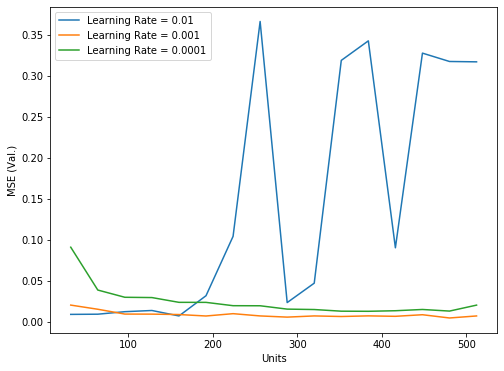

In [746]:
plt.figure(figsize=(8, 6))
plt.plot(GS_df_lr1['Units'], GS_df_lr1['Validation Loss'], label = 'Learning Rate = 0.01')
plt.plot(GS_df_lr2['Units'], GS_df_lr2['Validation Loss'], label = 'Learning Rate = 0.001')
plt.plot(GS_df_lr3['Units'], GS_df_lr3['Validation Loss'], label = 'Learning Rate = 0.0001')
plt.xlabel("Units")
plt.ylabel("MSE (Val.)")
plt.legend(loc='upper left')
plt.savefig("Figure_7")
plt.show()

In [736]:
GS_df_lr2

,Validation Loss,Learning Rate,Units
16,0.020504,0.001,32
17,0.015431,0.001,64
18,0.009556,0.001,96
19,0.009483,0.001,128
20,0.008991,0.001,160
21,0.007214,0.001,192
22,0.010047,0.001,224
23,0.007292,0.001,256
24,0.005845,0.001,288
25,0.007296,0.001,320


In [603]:
from kerastuner.engine.hyperparameters import HyperParameters

# hp_ = HyperParameters()

# model  = build_model(hp_, layers_ = [5, window, 1])

In [604]:
%%time

random_tuner3 = RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 10,
    seed=10,
    project_name='stock price prediction3_10')


random_tuner3.search(X_train, y_train,
                epochs = 10,
                batch_size = 512,
                validation_data = (X_test, y_test),
                verbose=1)

# random_params = random_tuner.get_best_hyperparameters()[0]

# random_model = random_tuner.model.build(random_params)

# random_model.fit(X_train, y_train, epochs=15)

# random_accuracy_df = pd.DataFrame(random_model.history.history)

# random_accuracy_df[['loss']].plot()
# plt.title('Loss and Accuracy per Epoch for Random Model')
# plt.xlabel('EPOCH')
# plt.ylabel('Accuracy')
# plt.show()



Compilation Time :  0.03760385513305664
Compilation Time :  0.04779791831970215
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 50s - loss: 0.0135 - mse: 0.0135 - mape: 99.7140 - mae: 0.05 - ETA: 29s - loss: 0.0146 - mse: 0.0146 - mape: 94.6557 - mae: 0.05 - ETA: 21s - loss: 0.0147 - mse: 0.0147 - mape: 141.4615 - mae: 0.056 - ETA: 17s - loss: 0.0132 - mse: 0.0132 - mape: 235.7218 - mae: 0.053 - ETA: 14s - loss: 0.0111 - mse: 0.0111 - mape: 463.1507 - mae: 0.051 - ETA: 12s - loss: 0.0108 - mse: 0.0108 - mape: 950.8474 - mae: 0.058 - ETA: 10s - loss: 0.0096 - mse: 0.0096 - mape: 1037.0450 - mae: 0.05 - ETA: 9s - loss: 0.0087 - mse: 0.0087 - mape: 1056.2240 - mae: 0.0537 - ETA: 8s - loss: 0.0081 - mse: 0.0081 - mape: 1002.9915 - mae: 0.051 - ETA: 7s - loss: 0.0076 - mse: 0.0076 - mape: 935.6415 - mae: 0.049 - ETA: 5s - loss: 0.0073 - mse: 0.0073 - mape: 868.0477 - mae: 0.04 - ETA: 4s - loss: 0.0068 - mse: 0.0068 - mape: 806.1172

8820/8820 [==============================] - ETA: 11s - loss: 7.0639e-05 - mse: 7.0639e-05 - mape: 35.5199 - mae: 0.00 - ETA: 10s - loss: 7.0173e-05 - mse: 7.0173e-05 - mape: 38.3033 - mae: 0.00 - ETA: 9s - loss: 7.8340e-05 - mse: 7.8340e-05 - mape: 36.3311 - mae: 0.0042 - ETA: 9s - loss: 7.7532e-05 - mse: 7.7532e-05 - mape: 36.5805 - mae: 0.004 - ETA: 8s - loss: 8.1750e-05 - mse: 8.1750e-05 - mape: 35.8898 - mae: 0.004 - ETA: 7s - loss: 8.6030e-05 - mse: 8.6030e-05 - mape: 36.0206 - mae: 0.004 - ETA: 7s - loss: 8.5722e-05 - mse: 8.5722e-05 - mape: 36.1494 - mae: 0.004 - ETA: 6s - loss: 8.5610e-05 - mse: 8.5610e-05 - mape: 36.5703 - mae: 0.004 - ETA: 5s - loss: 8.7085e-05 - mse: 8.7085e-05 - mape: 35.9170 - mae: 0.004 - ETA: 5s - loss: 8.9878e-05 - mse: 8.9878e-05 - mape: 34.8819 - mae: 0.004 - ETA: 4s - loss: 8.9319e-05 - mse: 8.9319e-05 - mape: 34.2968 - mae: 0.004 - ETA: 3s - loss: 8.8000e-05 - mse: 8.8000e-05 - mape: 33.5263 - mae: 0.004 - ETA: 2s - loss: 8.7086e-05 - mse: 8.7086e-

Compilation Time :  0.03809618949890137
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 49s - loss: 0.0175 - mse: 0.0175 - mape: 98.9445 - mae: 0.06 - ETA: 27s - loss: 0.0165 - mse: 0.0165 - mape: 98.1173 - mae: 0.05 - ETA: 20s - loss: 0.0158 - mse: 0.0158 - mape: 123.4006 - mae: 0.058 - ETA: 16s - loss: 0.0148 - mse: 0.0148 - mape: 199.7800 - mae: 0.057 - ETA: 13s - loss: 0.0134 - mse: 0.0134 - mape: 295.6405 - mae: 0.055 - ETA: 11s - loss: 0.0117 - mse: 0.0117 - mape: 507.8650 - mae: 0.054 - ETA: 9s - loss: 0.0111 - mse: 0.0111 - mape: 864.7667 - mae: 0.058 - ETA: 8s - loss: 0.0101 - mse: 0.0101 - mape: 14864.2812 - mae: 0.05 - ETA: 7s - loss: 0.0092 - mse: 0.0092 - mape: 13359.3428 - mae: 0.05 - ETA: 6s - loss: 0.0085 - mse: 0.0085 - mape: 12107.9902 - mae: 0.05 - ETA: 5s - loss: 0.0079 - mse: 0.0079 - mape: 11050.2080 - mae: 0.05 - ETA: 4s - loss: 0.0073 - mse: 0.0073 - mape: 10152.6592 - mae: 0.04 - ETA: 3s - loss: 0.0068

8820/8820 [==============================] - ETA: 8s - loss: 9.9758e-05 - mse: 9.9758e-05 - mape: 25.5829 - mae: 0.004 - ETA: 8s - loss: 9.4874e-05 - mse: 9.4874e-05 - mape: 26.7056 - mae: 0.004 - ETA: 7s - loss: 9.0372e-05 - mse: 9.0372e-05 - mape: 27.6646 - mae: 0.004 - ETA: 7s - loss: 8.8708e-05 - mse: 8.8708e-05 - mape: 28.1406 - mae: 0.004 - ETA: 6s - loss: 9.2137e-05 - mse: 9.2137e-05 - mape: 220.1333 - mae: 0.00 - ETA: 6s - loss: 8.9657e-05 - mse: 8.9657e-05 - mape: 187.8005 - mae: 0.00 - ETA: 5s - loss: 9.1298e-05 - mse: 9.1298e-05 - mape: 165.2547 - mae: 0.00 - ETA: 5s - loss: 9.0526e-05 - mse: 9.0526e-05 - mape: 147.9941 - mae: 0.00 - ETA: 4s - loss: 9.2116e-05 - mse: 9.2116e-05 - mape: 134.0576 - mae: 0.00 - ETA: 4s - loss: 9.0415e-05 - mse: 9.0415e-05 - mape: 122.6866 - mae: 0.00 - ETA: 3s - loss: 9.1349e-05 - mse: 9.1349e-05 - mape: 114.3393 - mae: 0.00 - ETA: 2s - loss: 9.0130e-05 - mse: 9.0130e-05 - mape: 106.7356 - mae: 0.00 - ETA: 2s - loss: 8.7588e-05 - mse: 8.7588e-0

Compilation Time :  0.03946709632873535
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 43s - loss: 0.0183 - mse: 0.0183 - mape: 100.0127 - mae: 0.065 - ETA: 22s - loss: 0.0161 - mse: 0.0161 - mape: 348.5159 - mae: 0.063 - ETA: 14s - loss: 0.0183 - mse: 0.0183 - mape: 2153.9836 - mae: 0.09 - ETA: 11s - loss: 0.0161 - mse: 0.0161 - mape: 1931.9310 - mae: 0.08 - ETA: 8s - loss: 0.0155 - mse: 0.0155 - mape: 1739.4558 - mae: 0.0778 - ETA: 7s - loss: 0.0148 - mse: 0.0148 - mape: 8434.1914 - mae: 0.073 - ETA: 5s - loss: 0.0146 - mse: 0.0146 - mape: 7354.1953 - mae: 0.072 - ETA: 4s - loss: 0.0140 - mse: 0.0140 - mape: 6554.1753 - mae: 0.069 - ETA: 4s - loss: 0.0129 - mse: 0.0129 - mape: 5967.7720 - mae: 0.066 - ETA: 3s - loss: 0.0119 - mse: 0.0119 - mape: 5473.6826 - mae: 0.063 - ETA: 2s - loss: 0.0112 - mse: 0.0112 - mape: 5081.4229 - mae: 0.061 - ETA: 2s - loss: 0.0104 - mse: 0.0104 - mape: 4687.2642 - mae: 0.058 - ETA: 1s - loss: 

8820/8820 [==============================] - ETA: 3s - loss: 1.0639e-04 - mse: 1.0639e-04 - mape: 443.5402 - mae: 0.00 - ETA: 3s - loss: 1.1854e-04 - mse: 1.1854e-04 - mape: 278.4718 - mae: 0.00 - ETA: 3s - loss: 1.2511e-04 - mse: 1.2511e-04 - mape: 225.7482 - mae: 0.00 - ETA: 2s - loss: 1.2599e-04 - mse: 1.2599e-04 - mape: 200.7415 - mae: 0.00 - ETA: 2s - loss: 1.3088e-04 - mse: 1.3088e-04 - mape: 198.6549 - mae: 0.00 - ETA: 2s - loss: 1.3063e-04 - mse: 1.3063e-04 - mape: 183.3986 - mae: 0.00 - ETA: 2s - loss: 1.2964e-04 - mse: 1.2964e-04 - mape: 171.8009 - mae: 0.00 - ETA: 2s - loss: 1.2718e-04 - mse: 1.2718e-04 - mape: 165.9889 - mae: 0.00 - ETA: 1s - loss: 1.2388e-04 - mse: 1.2388e-04 - mape: 161.4907 - mae: 0.00 - ETA: 1s - loss: 1.2861e-04 - mse: 1.2861e-04 - mape: 158.6106 - mae: 0.00 - ETA: 1s - loss: 1.2688e-04 - mse: 1.2688e-04 - mape: 154.3112 - mae: 0.00 - ETA: 1s - loss: 1.2363e-04 - mse: 1.2363e-04 - mape: 149.8906 - mae: 0.00 - ETA: 0s - loss: 1.2745e-04 - mse: 1.2745e-0

Compilation Time :  0.03632187843322754
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 48s - loss: 0.0190 - mse: 0.0190 - mape: 96.7931 - mae: 0.06 - ETA: 25s - loss: 0.0174 - mse: 0.0174 - mape: 93.2908 - mae: 0.06 - ETA: 18s - loss: 0.0160 - mse: 0.0160 - mape: 91.4517 - mae: 0.05 - ETA: 14s - loss: 0.0156 - mse: 0.0156 - mape: 90.0198 - mae: 0.05 - ETA: 11s - loss: 0.0161 - mse: 0.0161 - mape: 87.6966 - mae: 0.05 - ETA: 9s - loss: 0.0154 - mse: 0.0154 - mape: 89.1391 - mae: 0.0571 - ETA: 7s - loss: 0.0152 - mse: 0.0152 - mape: 87.7717 - mae: 0.056 - ETA: 6s - loss: 0.0150 - mse: 0.0150 - mape: 483.6180 - mae: 0.05 - ETA: 5s - loss: 0.0153 - mse: 0.0153 - mape: 442.1217 - mae: 0.05 - ETA: 4s - loss: 0.0152 - mse: 0.0152 - mape: 408.5470 - mae: 0.05 - ETA: 3s - loss: 0.0152 - mse: 0.0152 - mape: 380.2303 - mae: 0.05 - ETA: 3s - loss: 0.0153 - mse: 0.0153 - mape: 356.8617 - mae: 0.05 - ETA: 2s - loss: 0.0153 - mse: 0.0153 - m

8820/8820 [==============================] - ETA: 6s - loss: 1.9424e-04 - mse: 1.9424e-04 - mape: 108.1128 - mae: 0.00 - ETA: 5s - loss: 1.7671e-04 - mse: 1.7671e-04 - mape: 103.6792 - mae: 0.00 - ETA: 5s - loss: 1.6414e-04 - mse: 1.6414e-04 - mape: 97.1952 - mae: 0.0064 - ETA: 5s - loss: 1.6146e-04 - mse: 1.6146e-04 - mape: 89.1515 - mae: 0.006 - ETA: 4s - loss: 1.6637e-04 - mse: 1.6637e-04 - mape: 89.3974 - mae: 0.006 - ETA: 4s - loss: 1.5812e-04 - mse: 1.5812e-04 - mape: 990.8389 - mae: 0.00 - ETA: 4s - loss: 1.5791e-04 - mse: 1.5791e-04 - mape: 858.7656 - mae: 0.00 - ETA: 3s - loss: 1.5490e-04 - mse: 1.5490e-04 - mape: 764.0114 - mae: 0.00 - ETA: 3s - loss: 1.5164e-04 - mse: 1.5164e-04 - mape: 687.2346 - mae: 0.00 - ETA: 2s - loss: 1.5458e-04 - mse: 1.5458e-04 - mape: 627.6583 - mae: 0.00 - ETA: 2s - loss: 1.5432e-04 - mse: 1.5432e-04 - mape: 576.5040 - mae: 0.00 - ETA: 2s - loss: 1.5507e-04 - mse: 1.5507e-04 - mape: 535.2844 - mae: 0.00 - ETA: 1s - loss: 1.5627e-04 - mse: 1.5627e-

Compilation Time :  0.04129385948181152
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 45s - loss: 0.0158 - mse: 0.0158 - mape: 97.0187 - mae: 0.06 - ETA: 23s - loss: 0.0160 - mse: 0.0160 - mape: 93.9180 - mae: 0.06 - ETA: 16s - loss: 0.0149 - mse: 0.0149 - mape: 91.1008 - mae: 0.05 - ETA: 12s - loss: 0.0156 - mse: 0.0156 - mape: 89.1301 - mae: 0.05 - ETA: 9s - loss: 0.0160 - mse: 0.0160 - mape: 87.6853 - mae: 0.0588 - ETA: 7s - loss: 0.0162 - mse: 0.0162 - mape: 87.1619 - mae: 0.059 - ETA: 6s - loss: 0.0162 - mse: 0.0162 - mape: 86.1513 - mae: 0.059 - ETA: 5s - loss: 0.0160 - mse: 0.0160 - mape: 86.5423 - mae: 0.058 - ETA: 4s - loss: 0.0159 - mse: 0.0159 - mape: 404.9454 - mae: 0.05 - ETA: 3s - loss: 0.0157 - mse: 0.0157 - mape: 372.9602 - mae: 0.05 - ETA: 3s - loss: 0.0157 - mse: 0.0157 - mape: 346.9891 - mae: 0.05 - ETA: 2s - loss: 0.0159 - mse: 0.0159 - mape: 325.5145 - mae: 0.05 - ETA: 2s - loss: 0.0158 - mse: 0.0158 - m

8820/8820 [==============================] - ETA: 4s - loss: 2.1761e-04 - mse: 2.1761e-04 - mape: 432.5849 - mae: 0.01 - ETA: 5s - loss: 2.3737e-04 - mse: 2.3737e-04 - mape: 11418.3770 - mae: 0.01 - ETA: 4s - loss: 2.4279e-04 - mse: 2.4279e-04 - mape: 7739.3823 - mae: 0.0117 - ETA: 4s - loss: 2.4383e-04 - mse: 2.4383e-04 - mape: 5907.7065 - mae: 0.011 - ETA: 3s - loss: 2.5274e-04 - mse: 2.5274e-04 - mape: 4790.2300 - mae: 0.011 - ETA: 3s - loss: 2.4167e-04 - mse: 2.4167e-04 - mape: 4041.0820 - mae: 0.011 - ETA: 3s - loss: 2.3774e-04 - mse: 2.3774e-04 - mape: 3508.5308 - mae: 0.011 - ETA: 2s - loss: 2.3174e-04 - mse: 2.3174e-04 - mape: 3105.1980 - mae: 0.010 - ETA: 2s - loss: 2.2818e-04 - mse: 2.2818e-04 - mape: 2789.5422 - mae: 0.010 - ETA: 2s - loss: 2.2903e-04 - mse: 2.2903e-04 - mape: 2540.5422 - mae: 0.010 - ETA: 1s - loss: 2.2478e-04 - mse: 2.2478e-04 - mape: 2333.9209 - mae: 0.010 - ETA: 1s - loss: 2.2318e-04 - mse: 2.2318e-04 - mape: 2157.9475 - mae: 0.010 - ETA: 1s - loss: 2.18

Compilation Time :  0.033577919006347656
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 1:05 - loss: 0.0171 - mse: 0.0171 - mape: 101.0971 - mae: 0.06 - ETA: 40s - loss: 0.0114 - mse: 0.0114 - mape: 689.7454 - mae: 0.0572 - ETA: 30s - loss: 1.4494 - mse: 1.4494 - mape: 28097.1797 - mae: 0.729 - ETA: 25s - loss: 1.0949 - mse: 1.0949 - mape: 23300.1895 - mae: 0.589 - ETA: 22s - loss: 0.8784 - mse: 0.8784 - mape: 18679.3926 - mae: 0.481 - ETA: 19s - loss: 0.7347 - mse: 0.7347 - mape: 15584.5283 - mae: 0.410 - ETA: 17s - loss: 0.6314 - mse: 0.6314 - mape: 13446.2031 - mae: 0.359 - ETA: 15s - loss: 0.5539 - mse: 0.5539 - mape: 12127.3262 - mae: 0.324 - ETA: 13s - loss: 0.4938 - mse: 0.4938 - mape: 11165.1104 - mae: 0.298 - ETA: 11s - loss: 0.4456 - mse: 0.4456 - mape: 10269.4404 - mae: 0.276 - ETA: 9s - loss: 0.4065 - mse: 0.4065 - mape: 9436.9648 - mae: 0.2577  - ETA: 8s - loss: 0.3738 - mse: 0.3738 - mape: 12759.0342 - mae: 0.24

8820/8820 [==============================] - ETA: 20s - loss: 0.0128 - mse: 0.0128 - mape: 2162.5967 - mae: 0.08 - ETA: 19s - loss: 0.0122 - mse: 0.0122 - mape: 2695.5095 - mae: 0.08 - ETA: 18s - loss: 0.0120 - mse: 0.0120 - mape: 2712.7917 - mae: 0.08 - ETA: 17s - loss: 0.0123 - mse: 0.0123 - mape: 2500.8167 - mae: 0.08 - ETA: 15s - loss: 0.0121 - mse: 0.0121 - mape: 2345.8940 - mae: 0.07 - ETA: 14s - loss: 0.0122 - mse: 0.0122 - mape: 2253.7158 - mae: 0.07 - ETA: 13s - loss: 0.0120 - mse: 0.0120 - mape: 2232.8198 - mae: 0.07 - ETA: 12s - loss: 0.0119 - mse: 0.0119 - mape: 2241.9509 - mae: 0.07 - ETA: 10s - loss: 0.0124 - mse: 0.0124 - mape: 2228.9485 - mae: 0.07 - ETA: 9s - loss: 0.0124 - mse: 0.0124 - mape: 2251.4475 - mae: 0.0785 - ETA: 8s - loss: 0.0124 - mse: 0.0124 - mape: 17835.1230 - mae: 0.07 - ETA: 6s - loss: 0.0123 - mse: 0.0123 - mape: 16549.9590 - mae: 0.07 - ETA: 5s - loss: 0.0123 - mse: 0.0123 - mape: 15410.5557 - mae: 0.07 - ETA: 4s - loss: 0.0124 - mse: 0.0124 - mape:

Compilation Time :  0.04045915603637695
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 1:04 - loss: 0.0176 - mse: 0.0176 - mape: 102.8666 - mae: 0.06 - ETA: 39s - loss: 0.0162 - mse: 0.0162 - mape: 97.9566 - mae: 0.0576 - ETA: 31s - loss: 0.0151 - mse: 0.0151 - mape: 125.4854 - mae: 0.056 - ETA: 26s - loss: 0.0136 - mse: 0.0136 - mape: 230.5448 - mae: 0.053 - ETA: 23s - loss: 0.0114 - mse: 0.0114 - mape: 559.0866 - mae: 0.052 - ETA: 20s - loss: 0.0115 - mse: 0.0115 - mape: 1025.4938 - mae: 0.06 - ETA: 17s - loss: 0.0101 - mse: 0.0101 - mape: 1063.5273 - mae: 0.05 - ETA: 15s - loss: 0.0094 - mse: 0.0094 - mape: 994.7583 - mae: 0.0548 - ETA: 13s - loss: 0.0090 - mse: 0.0090 - mape: 918.2401 - mae: 0.052 - ETA: 11s - loss: 0.0088 - mse: 0.0088 - mape: 841.5610 - mae: 0.051 - ETA: 10s - loss: 0.0083 - mse: 0.0083 - mape: 775.1060 - mae: 0.049 - ETA: 8s - loss: 0.0078 - mse: 0.0078 - mape: 717.8178 - mae: 0.046 - ETA: 6s - loss: 0

8820/8820 [==============================] - ETA: 22s - loss: 5.6383e-05 - mse: 5.6383e-05 - mape: 27.1377 - mae: 0.00 - ETA: 21s - loss: 6.4750e-05 - mse: 6.4750e-05 - mape: 26.7096 - mae: 0.00 - ETA: 19s - loss: 5.9242e-05 - mse: 5.9242e-05 - mape: 26.4566 - mae: 0.00 - ETA: 18s - loss: 6.4692e-05 - mse: 6.4692e-05 - mape: 193.2823 - mae: 0.003 - ETA: 17s - loss: 6.6559e-05 - mse: 6.6559e-05 - mape: 159.5441 - mae: 0.003 - ETA: 15s - loss: 6.6122e-05 - mse: 6.6122e-05 - mape: 136.6859 - mae: 0.003 - ETA: 14s - loss: 6.9298e-05 - mse: 6.9298e-05 - mape: 120.7920 - mae: 0.003 - ETA: 12s - loss: 7.0798e-05 - mse: 7.0797e-05 - mape: 109.4864 - mae: 0.003 - ETA: 11s - loss: 7.0573e-05 - mse: 7.0573e-05 - mape: 100.8671 - mae: 0.003 - ETA: 10s - loss: 7.0101e-05 - mse: 7.0101e-05 - mape: 94.7520 - mae: 0.003 - ETA: 8s - loss: 7.1524e-05 - mse: 7.1524e-05 - mape: 89.6736 - mae: 0.0036 - ETA: 7s - loss: 7.1069e-05 - mse: 7.1069e-05 - mape: 85.0663 - mae: 0.003 - ETA: 6s - loss: 7.0308e-05 - 

Compilation Time :  0.05795097351074219
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 1:02 - loss: 0.0161 - mse: 0.0161 - mape: 101.4619 - mae: 0.05 - ETA: 37s - loss: 0.0154 - mse: 0.0154 - mape: 98.9569 - mae: 0.0556 - ETA: 28s - loss: 0.0149 - mse: 0.0149 - mape: 122.5338 - mae: 0.054 - ETA: 23s - loss: 0.0140 - mse: 0.0140 - mape: 5404.1143 - mae: 0.05 - ETA: 19s - loss: 0.0124 - mse: 0.0124 - mape: 4542.0620 - mae: 0.05 - ETA: 16s - loss: 0.0110 - mse: 0.0110 - mape: 4164.7271 - mae: 0.05 - ETA: 14s - loss: 0.0099 - mse: 0.0099 - mape: 3845.8433 - mae: 0.05 - ETA: 12s - loss: 0.0088 - mse: 0.0088 - mape: 3505.7056 - mae: 0.05 - ETA: 11s - loss: 0.0081 - mse: 0.0081 - mape: 3186.8867 - mae: 0.04 - ETA: 9s - loss: 0.0074 - mse: 0.0074 - mape: 2890.5815 - mae: 0.0453 - ETA: 7s - loss: 0.0067 - mse: 0.0067 - mape: 2638.6147 - mae: 0.041 - ETA: 6s - loss: 0.0063 - mse: 0.0063 - mape: 2423.9360 - mae: 0.039 - ETA: 5s - loss: 

8820/8820 [==============================] - ETA: 16s - loss: 1.0610e-04 - mse: 1.0610e-04 - mape: 50.1760 - mae: 0.00 - ETA: 15s - loss: 9.8739e-05 - mse: 9.8739e-05 - mape: 42.4710 - mae: 0.00 - ETA: 14s - loss: 8.6352e-05 - mse: 8.6352e-05 - mape: 44.4103 - mae: 0.00 - ETA: 13s - loss: 8.6002e-05 - mse: 8.6002e-05 - mape: 43.9431 - mae: 0.00 - ETA: 12s - loss: 7.8129e-05 - mse: 7.8129e-05 - mape: 44.2499 - mae: 0.00 - ETA: 11s - loss: 7.9482e-05 - mse: 7.9482e-05 - mape: 43.4344 - mae: 0.00 - ETA: 10s - loss: 7.3896e-05 - mse: 7.3896e-05 - mape: 45.1595 - mae: 0.00 - ETA: 9s - loss: 7.3488e-05 - mse: 7.3488e-05 - mape: 588.5004 - mae: 0.00 - ETA: 8s - loss: 7.1201e-05 - mse: 7.1201e-05 - mape: 528.4685 - mae: 0.00 - ETA: 7s - loss: 7.1023e-05 - mse: 7.1023e-05 - mape: 479.7512 - mae: 0.00 - ETA: 6s - loss: 7.0912e-05 - mse: 7.0912e-05 - mape: 439.8889 - mae: 0.00 - ETA: 5s - loss: 6.8855e-05 - mse: 6.8855e-05 - mape: 407.8593 - mae: 0.00 - ETA: 4s - loss: 6.6881e-05 - mse: 6.6881e-0

Compilation Time :  0.041992902755737305
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 1:00 - loss: 0.0170 - mse: 0.0170 - mape: 101.2143 - mae: 0.06 - ETA: 35s - loss: 0.0161 - mse: 0.0161 - mape: 96.1269 - mae: 0.0605 - ETA: 26s - loss: 0.0168 - mse: 0.0168 - mape: 92.5655 - mae: 0.06 - ETA: 21s - loss: 0.0165 - mse: 0.0165 - mape: 89.9236 - mae: 0.06 - ETA: 18s - loss: 0.0166 - mse: 0.0166 - mape: 88.4845 - mae: 0.06 - ETA: 15s - loss: 0.0164 - mse: 0.0164 - mape: 87.0429 - mae: 0.05 - ETA: 13s - loss: 0.0162 - mse: 0.0162 - mape: 86.7075 - mae: 0.05 - ETA: 12s - loss: 0.0160 - mse: 0.0160 - mape: 87.2197 - mae: 0.05 - ETA: 10s - loss: 0.0159 - mse: 0.0159 - mape: 89.3836 - mae: 0.05 - ETA: 9s - loss: 0.0159 - mse: 0.0159 - mape: 93.1576 - mae: 0.0587 - ETA: 7s - loss: 0.0158 - mse: 0.0158 - mape: 684.7766 - mae: 0.05 - ETA: 6s - loss: 0.0156 - mse: 0.0156 - mape: 637.5909 - mae: 0.05 - ETA: 5s - loss: 0.0156 - mse: 0.015

8820/8820 [==============================] - ETA: 19s - loss: 1.0566e-04 - mse: 1.0566e-04 - mape: 66.6871 - mae: 0.00 - ETA: 18s - loss: 9.0068e-05 - mse: 9.0068e-05 - mape: 72.0070 - mae: 0.00 - ETA: 16s - loss: 8.6793e-05 - mse: 8.6793e-05 - mape: 68.3206 - mae: 0.00 - ETA: 14s - loss: 9.0300e-05 - mse: 9.0300e-05 - mape: 68.8855 - mae: 0.00 - ETA: 13s - loss: 9.0861e-05 - mse: 9.0861e-05 - mape: 68.4664 - mae: 0.00 - ETA: 12s - loss: 9.1384e-05 - mse: 9.1384e-05 - mape: 72.1308 - mae: 0.00 - ETA: 11s - loss: 9.2431e-05 - mse: 9.2431e-05 - mape: 79.8299 - mae: 0.00 - ETA: 10s - loss: 9.0489e-05 - mse: 9.0489e-05 - mape: 810.7031 - mae: 0.004 - ETA: 8s - loss: 9.0740e-05 - mse: 9.0740e-05 - mape: 729.8234 - mae: 0.004 - ETA: 7s - loss: 9.2688e-05 - mse: 9.2688e-05 - mape: 666.2668 - mae: 0.00 - ETA: 6s - loss: 9.3613e-05 - mse: 9.3613e-05 - mape: 612.8473 - mae: 0.00 - ETA: 5s - loss: 9.6256e-05 - mse: 9.6256e-05 - mape: 568.4815 - mae: 0.00 - ETA: 4s - loss: 9.7140e-05 - mse: 9.7140

Compilation Time :  0.04288315773010254
Train on 8820 samples, validate on 980 samples
Epoch 1/10
8820/8820 [==============================] - ETA: 44s - loss: 0.0144 - mse: 0.0144 - mape: 100.6574 - mae: 0.055 - ETA: 22s - loss: 0.0158 - mse: 0.0158 - mape: 236.3392 - mae: 0.058 - ETA: 15s - loss: 0.0157 - mse: 0.0157 - mape: 187.5516 - mae: 0.058 - ETA: 11s - loss: 0.0165 - mse: 0.0165 - mape: 163.2249 - mae: 0.059 - ETA: 8s - loss: 0.0165 - mse: 0.0165 - mape: 148.1574 - mae: 0.059 - ETA: 7s - loss: 0.0163 - mse: 0.0163 - mape: 137.3463 - mae: 0.05 - ETA: 5s - loss: 0.0165 - mse: 0.0165 - mape: 130.2229 - mae: 0.05 - ETA: 4s - loss: 0.0162 - mse: 0.0162 - mape: 123.9904 - mae: 0.05 - ETA: 4s - loss: 0.0161 - mse: 0.0161 - mape: 118.9248 - mae: 0.05 - ETA: 3s - loss: 0.0162 - mse: 0.0162 - mape: 115.6667 - mae: 0.05 - ETA: 2s - loss: 0.0160 - mse: 0.0160 - mape: 112.6318 - mae: 0.05 - ETA: 2s - loss: 0.0158 - mse: 0.0158 - mape: 110.0384 - mae: 0.05 - ETA: 1s - loss: 0.0159 - mse: 0.

8820/8820 [==============================] - ETA: 3s - loss: 0.0014 - mse: 0.0014 - mape: 953.2048 - mae: 0.02 - ETA: 3s - loss: 0.0014 - mse: 0.0014 - mape: 878.9372 - mae: 0.02 - ETA: 3s - loss: 0.0014 - mse: 0.0014 - mape: 867.1357 - mae: 0.02 - ETA: 2s - loss: 0.0014 - mse: 0.0014 - mape: 819.6829 - mae: 0.02 - ETA: 2s - loss: 0.0013 - mse: 0.0013 - mape: 797.5124 - mae: 0.02 - ETA: 2s - loss: 0.0012 - mse: 0.0012 - mape: 778.9312 - mae: 0.02 - ETA: 2s - loss: 0.0012 - mse: 0.0012 - mape: 5159.5288 - mae: 0.024 - ETA: 1s - loss: 0.0011 - mse: 0.0011 - mape: 4583.8335 - mae: 0.024 - ETA: 1s - loss: 0.0011 - mse: 0.0011 - mape: 4149.2388 - mae: 0.023 - ETA: 1s - loss: 0.0011 - mse: 0.0011 - mape: 3798.1680 - mae: 0.023 - ETA: 1s - loss: 0.0010 - mse: 0.0010 - mape: 3509.7156 - mae: 0.022 - ETA: 1s - loss: 0.0010 - mse: 0.0010 - mape: 3270.2979 - mae: 0.022 - ETA: 0s - loss: 9.9328e-04 - mse: 9.9328e-04 - mape: 3052.4482 - mae: 0.022 - ETA: 0s - loss: 9.6228e-04 - mse: 9.6228e-04 - ma

INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 54min 43s, sys: 1h 21min 21s, total: 3h 16min 5s
Wall time: 22min 34s


In [605]:
# model.summary()
random_tuner3.results_summary()

In [640]:
x1 = ['First', 'Second', 'Third', 'Forth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth']
mse_val_ = [0.008181398133842313, 0.005898778402835739, 0.011373264296930663, 0.020783480028716887, 0.027214199152528023,
           0.29025989174842837, 0.00591176839507356, 0.005404698533215085, 0.013106997379538965, 0.03697220789534705]
l_r = [0.001, 0.001, 0.01, 0.0001, 0.0001, 0.01, 0.001, 0.001, 0.0001, 0.0001]
units_ = [320, 256, 96, 192, 128, 480, 480, 384, 384, 96]
results_trials = {'Trials' : x1, 'MSE': mse_val_, 'Learning Rate': l_r, 'Units':units_}

results_trials = pd.DataFrame(results_trials)
results_trials = results_trials.set_index('Trials')
results_trials

,MSE,Learning Rate,Units
Trials,,,
First,0.008181,0.0010,320
Second,0.005899,0.0010,256
Third,0.011373,0.0100,96
Forth,0.020783,0.0001,192
Fifth,0.027214,0.0001,128
Sixth,0.290260,0.0100,480
Seventh,0.005912,0.0010,480
Eighth,0.005405,0.0010,384
Ninth,0.013107,0.0001,384


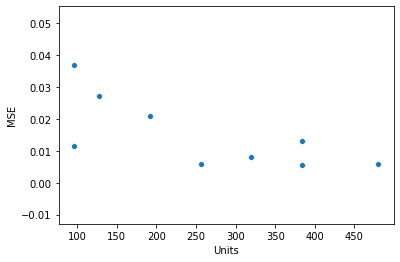

In [644]:
import seaborn as sb

results_trials2 = results_trials.copy()
results_trials2 = results_trials2.drop(results_trials2.index[5])

sb_plot = sb.scatterplot(x='Units', y='MSE', data=results_trials2)
fig = sb_plot.get_figure()
fig.savefig("Figure 6")

In [606]:
random_tuner3.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'units': 384, 'learning_rate': 0.001}

In [521]:
random_tuner.oracle.get_best_trials(num_trials=3)[0].hyperparameters.values

{'units': 256, 'learning_rate': 0.001}

In [607]:
best_model3_10 = random_tuner3.get_best_models()[0]

Compilation Time :  0.03692197799682617


In [680]:

# SAVING THE BEST MODEL

file_name = 'best_model3_10.h5'
best_model3_10.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `best_model3_10.h5` to disk


In [677]:
type(random_tuner3)

kerastuner.tuners.randomsearch.RandomSearch

In [681]:
file_name3 = 'random_tuner3_10.h5'
random_tuner3.save(file_name3)
print("Saved model `{}` to disk".format(file_name))

TypeError: save() takes 1 positional argument but 2 were given

In [445]:
# model.fit(X_train, y_train, batch_size=512, epochs = 10, validation_data = (X_test, y_test), verbose = 1)

In [385]:
# tuner = RandomSearch(
#     build_model(hp_, [5, window, 1]),
#     objective='val_accuracy',
#     max_trials=5,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='6787_rs_tuning')

In [609]:
difference = []
ratio = []
p = best_model3_10.predict(X_test)
for i in range(len(y_test)):
    # pd = prediction day for i
    pdd = p[i][0]
    # (y_test day i / pd) - 1
    ratio.append((y_test[i]/pdd)-1)
    difference.append(abs(y_test[i]-pdd))

In [610]:
# Denormalizing the data
import pandas as pd

df = pd.read_csv("AAPL.csv")
df['Date'] = df['Date'].to_numpy()
df = df.set_index(pd.DatetimeIndex(df['Date']))
df["adj close"] = df.Close
df.drop(['Close'], 1, inplace=True)
df.drop(['Date'], 1, inplace=True)
df.drop(['Adj Close'], 1, inplace=True)

idx = pd.isnull(df).any(1).nonzero()[0][0]
df = df.drop(df.index[idx])



/Users/vegen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  if sys.path[0] == '':


In [611]:
def denormalize(df, normalized_val):
    df = df['adj close'].values.reshape(-1, 1)
    normalized_val = normalized_val.reshape(-1, 1)
    
    # return df.shape, p.shape
    min_max_scaler = MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_val)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [612]:
import math

def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose =0)
    print(f"Train Score: {trainScore[0]} MSE ({math.sqrt(trainScore[0])} RMSE)")
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Score: {testScore[0]} MSE ({math.sqrt(testScore[0])} RMSE)")
    
model_score(best_model2, X_train, y_train, X_test, y_test)

Train Score: 4.989391539526843e-05 MSE (0.007063562514430549 RMSE)
Test Score: 0.00545389314338907 MSE (0.07385047828815376 RMSE)


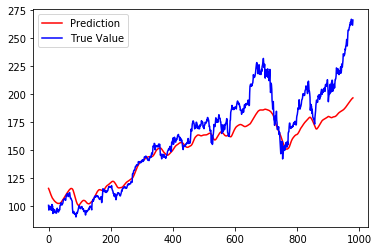

In [613]:

plt.plot(newp, color='red', label='Prediction')
plt.plot(newy_test, color='blue', label='True Value')
plt.legend(loc='best')
plt.show()


In [614]:
y_pred = best_model3_10.predict(X_train)

y_pred.shape, y_train.shape

((8820, 1), (8820,))

In [665]:
# BENCHMARK MODEL

def median_forecast(data_, lag):
    preds = np.zeros(len(data_)-lag)
    for i in range(len(data_)-lag):
        preds[i] = data_[i:(i+lag)].median()
    return preds

In [666]:
%%time
median_pred = median_forecast(df['adj close'], 22)


CPU times: user 1.55 s, sys: 42.6 ms, total: 1.59 s
Wall time: 1.56 s


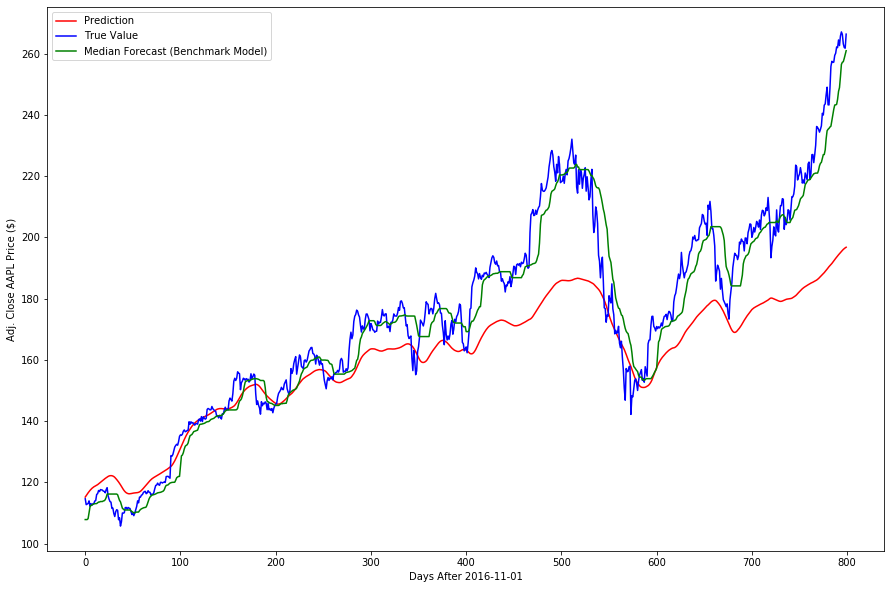

In [669]:
plt.figure(figsize=(15, 10))
plt.plot(newp[-800:], color='red', label='Prediction')
plt.plot(newy_test[-800:], color='blue', label='True Value')
plt.plot(median_pred[-800:], color='green', label='Median Forecast (Benchmark Model)')
plt.xlabel("Days After 2016-11-01")
plt.ylabel('Adj. Close AAPL Price ($)')
plt.legend(loc='best')
plt.savefig("Figure_5")
plt.show()



In [623]:
best_model3_10

In [616]:
accuracy_df = pd.DataFrame(best_model3_10[0].history.history)

accuracy_df[['mape', 'val_mape']].plot()
plt.title('Loss and Accuracy per Epoch for Model 2')
plt.xlabel('EPOCH')
plt.ylabel('loss')
plt.show()

TypeError: 'Sequential' object is not subscriptable

In [519]:
accuracy_df

,loss,mse,mape,val_loss,val_mse,val_mape
0,0.005227,0.005227,957.110107,0.038247,0.038247,26.019646
1,0.000400,0.000400,936.349548,0.046270,0.046270,27.024467
2,0.000173,0.000173,252.094131,0.023051,0.023051,17.313416
3,0.000100,0.000100,219.844009,0.015293,0.015293,13.401460
4,0.000084,0.000084,148.155258,0.013243,0.013242,12.197669
5,0.000085,0.000085,156.739960,0.013001,0.013001,12.413658
6,0.000080,0.000080,55.995144,0.008631,0.008631,9.513412
7,0.000074,0.000074,45.597305,0.007070,0.007070,8.420274
8,0.000073,0.000073,84.908577,0.009350,0.009350,10.982025
9,0.000084,0.000084,168.869919,0.004365,0.004365,7.128761


In [522]:
mse_by_trial = np.array([0.011356509340052702, 0.0054538926299737426, 0.006351642337228571])
units_by_trial = np.array([96, 256, 320])

In [526]:
plt.xplot(units_by_trial, mse_by_trial)
plt.xlabel("Number of Units")
plt.ylabel("MSE")
plt.legend(loc='best')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'xplot'

In [546]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 22, 256)           268288    
_________________________________________________________________
dropout (Dropout)            (None, 22, 256)           0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
Dense_2 (Dense)              (None, 1)                 3

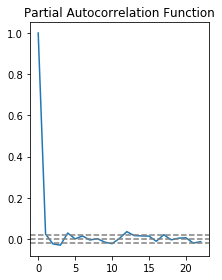

In [656]:
#Plot PACF:

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# p = 1

Text(0.5, 1.0, 'Autocorrelation Function')

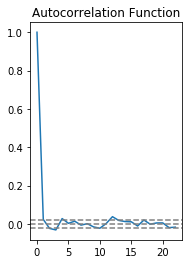

In [655]:
#Plot ACF: 

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# q = 1

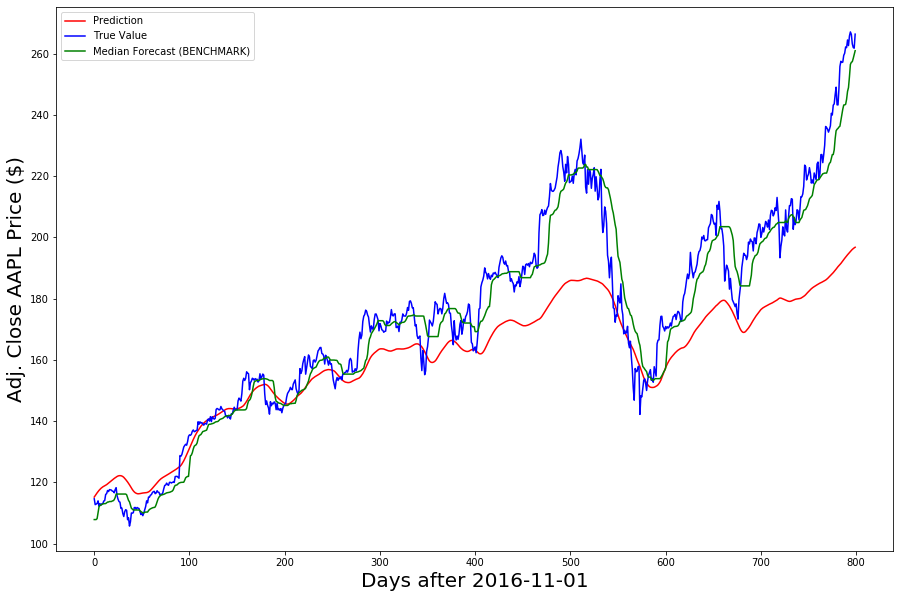

In [675]:
plt.figure(figsize=(15, 10))
plt.plot(newp[-800:], color='red', label='Prediction')
plt.plot(newy_test[-800:], color='blue', label='True Value')
plt.plot(median_pred[-800:], color='green', label = 'Median Forecast (BENCHMARK)')
plt.xlabel("Days after 2016-11-01", size=20)
plt.ylabel("Adj. Close AAPL Price ($)", size=20)
plt.legend(loc='best')
plt.savefig("Figure_5.png")
plt.show()

/Users/vegen/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/vegen/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 8.3238')

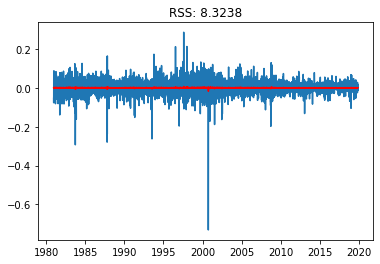

In [660]:
from statsmodels.tsa.arima_model import ARIMA

# AR model
model_AR = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model_AR.fit(disp=-1)  

plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))